In [1]:
import re
import numpy as np
import pandas as pd
import datasets
import openai 
import concurrent.futures

from typing import List, Dict
from tqdm import tqdm
from openai import OpenAI
from datasets import load_dataset

def multithread_openai_call(client, messages, model_name, max_workers=20, **kwargs):
    
    def call_openai(message: List[Dict[str, str]], **kwargs):
        response = client.chat.completions.create(
            model=model_name, 
            messages=message,
            **kwargs
        )
        # Handle multiple choices when n > 1
        if hasattr(response, 'choices') and len(response.choices) > 1:
            return [choice.message.content for choice in response.choices]
        else:
            return response.choices[0].message.content

    responses = []
    with concurrent.futures.ThreadPoolExecutor(max_workers=max_workers) as executor:
        future_to_message = {executor.submit(call_openai, message, **kwargs): i for i, message in enumerate(messages)}
        
        with tqdm(total=len(messages), desc="Processing messages") as pbar:
            for future in concurrent.futures.as_completed(future_to_message):
                message_idx = future_to_message[future]
                response = future.result()
                responses.append((message_idx, response))
                pbar.update(1)
    
    # Sort responses by original index and extract just the responses
    responses.sort(key=lambda x: x[0])
    return [r[1] for r in responses] 

client = OpenAI(base_url="http://22.1.41.53:30000/v1", api_key="EMPTY")

/root/miniconda3/envs/verl/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
from datasets import load_dataset
import json

def read_jsonl(file_path):
    data = []
    with open(file_path) as f:
        for line in f:
            if line.strip():
                item = json.loads(line)
                data.append(item)
    return data

# train_data = load_dataset("data/princeton-nlp/SWE-bench_oracle", split="train")
train_data = read_jsonl("data/augmented-data/nebius__SWE-bench-extra__style-2__fs-oracle.train.progress.jsonl")
print(len(train_data))
print(train_data[0])

6369
{'instance_id': '0b01001001__spectree-64', 'patch': "diff --git a/setup.py b/setup.py\nindex 1b3cb64..4ef21e6 100644\n--- a/setup.py\n+++ b/setup.py\n@@ -14,7 +14,7 @@ with open(path.join(here, 'requirements.txt'), encoding='utf-8') as f:\n \n setup(\n     name='spectree',\n-    version='0.3.7',\n+    version='0.3.8',\n     author='Keming Yang',\n     author_email='kemingy94@gmail.com',\n     description=('generate OpenAPI document and validate request&response '\ndiff --git a/spectree/utils.py b/spectree/utils.py\nindex bb5698d..73d6c71 100644\n--- a/spectree/utils.py\n+++ b/spectree/utils.py\n@@ -54,6 +54,7 @@ def parse_params(func, params, models):\n                 'in': 'query',\n                 'schema': schema,\n                 'required': name in query.get('required', []),\n+                'description': schema.get('description', ''),\n             })\n \n     if hasattr(func, 'headers'):\n@@ -64,6 +65,7 @@ def parse_params(func, params, models):\n                 'in':

In [5]:
from datasets import Dataset

for item in train_data:
    file_contents = item["file_contents"]
    item["file_names"] = list(file_contents.keys())
    item["file_contents"] = list(file_contents.values())

In [6]:
train_data = Dataset.from_list(train_data)

In [7]:
# Copyright (c) Meta Platforms, Inc. and affiliates. All rights reserved.

AGENTLESS_REPAIR = """We are currently solving the following issue within our repository. Here is the issue text:
--- BEGIN ISSUE ---
{problem_statement}
--- END ISSUE ---

Below are some code segments, each from a relevant file. One or more of these files may contain bugs.

--- BEGIN FILE ---
```
{content}
```
--- END FILE ---

Please first localize the bug based on the issue statement, and then generate *SEARCH/REPLACE* edits to fix the issue.

Every *SEARCH/REPLACE* edit must use this format:
1. The file path
2. The start of search block: <<<<<<< SEARCH
3. A contiguous chunk of lines to search for in the existing source code
4. The dividing line: =======
5. The lines to replace into the source code
6. The end of the replace block: >>>>>>> REPLACE

Here is an example:

```python
### mathweb/flask/app.py
<<<<<<< SEARCH
from flask import Flask
=======
import math
from flask import Flask
>>>>>>> REPLACE
```

Please note that the *SEARCH/REPLACE* edit REQUIRES PROPER INDENTATION. If you would like to add the line '        print(x)', you must fully write that out, with all those spaces before the code!
Wrap each *SEARCH/REPLACE* edit in a code block as shown in the example above. If you have multiple *SEARCH/REPLACE* edits, use a separate code block for each one.

Your response format must follow the template below:
<think>
Your thoughts or/and draft, like working through an exercise on scratch paper. Be as casual and as long as you want until you are confident to generate a correct solution.
</think>
<solution>
Final solution presented to the user.
</solution>"""

CODE_FILE = """
### {path}
{content}
""".strip()


In [8]:
from transformers import AutoTokenizer
tokenizer = AutoTokenizer.from_pretrained("/mnt/data/models/Qwen2.5-Coder-7B-Instruct")

In [12]:
import unittest
from unidiff import PatchSet
import io


def apply_patch_to_code_dict(code_dict, patch_text):
    """
    Applies a unidiff patch to the given code_dict.

    Args:
        code_dict (dict): Dictionary where keys are file paths and values are file contents (as strings).
        patch_text (str): Unified diff patch in string format.

    Returns:
        dict: Updated code_dict after applying the patch.
    """
    patched_code_dict = code_dict.copy()
    # Strip XML-like tags and trailing newlines from the patch text
    patch_text = patch_text.strip()
    if patch_text.startswith('<patch>'):
        patch_text = patch_text[7:]
    if patch_text.endswith('</patch>'):
        patch_text = patch_text[:-8]
    # patch_text = patch_text.rstrip('\n')
    patch = PatchSet(io.StringIO(patch_text))

    for patched_file in patch:
        # Remove leading a/ or b/ prefixes in filenames
        path = patched_file.path
        original_text = code_dict.get(path)
        if original_text is None:
            raise ValueError(f"File {path} not found in code_dict {code_dict.keys()}.")

        original_lines = original_text.splitlines(keepends=True)
        patched_lines = []
        i = 0  # Pointer for original_lines

        for hunk in patched_file:
            # Add lines before hunk
            while i < hunk.source_start - 1 and i < len(original_lines):
                patched_lines.append(original_lines[i])
                i += 1

            # Apply hunk changes
            for line in hunk:
                if line.is_context:
                    if i < len(original_lines):
                        patched_lines.append(original_lines[i])
                        i += 1
                elif line.is_removed:
                    if i < len(original_lines):
                        i += 1  # Skip the line (removal)
                elif line.is_added:
                    patched_lines.append(line.value)

        # Add remaining lines after last hunk
        patched_lines.extend(original_lines[i:])

        # Update the file content in the dict
        patched_code_dict[path] = ''.join(patched_lines)

    return patched_code_dict

In [13]:
def make_map_fn(split, data_source, tokenizer):

    def process_fn(example, idx):
        problem_statement = example["problem_statement"]
        file_names = example["file_names"]
        file_contents = example["file_contents"]
        code_dict = {file_name: content for file_name, content in zip(file_names, file_contents)}

        file_prompts = [CODE_FILE.format(path=name, content=content) for name, content in zip(file_names, file_contents)]
        file_prompts = "\n\n".join(file_prompts)
        prompt = AGENTLESS_REPAIR.format(problem_statement=problem_statement, content=file_prompts)
        messages = [dict(role="user", content=prompt)]
        message_prompt = tokenizer.apply_chat_template(messages, tokenize=False, add_generation_prompt=True)
        token_length = len(tokenizer.encode(message_prompt))

        from unidiff import UnidiffParseError
        try:
            answer = apply_patch_to_code_dict(code_dict, example["patch"])
            oracle_file_names = list(answer.keys())
            oracle_file_contents = list(answer.values())
        except ValueError as e:
            print(f"Found ValueError in {example['instance_id']}: {e}")
            oracle_file_names = []
            oracle_file_contents = []
        except UnidiffParseError as e:
            print(f"Found UnidiffParseError in {example['instance_id']}: {e}")
            oracle_file_names = []
            oracle_file_contents = []
            
        data = {
            "qwen_input_length": token_length,
            "data_source": data_source,
            "prompt": messages,
            "ability": "swe",
            "reward_model": {
                "style": "rule",
                "ground_truth": (oracle_file_names, oracle_file_contents),
            },
            "extra_info": {
                "split": split, "index": idx, "file_names": file_names, "file_contents": file_contents
            },
        }
        return data

    return process_fn

In [14]:
train_data = train_data.map(make_map_fn("train", "swe-oracle-search-replace", tokenizer), with_indices=True)

Map:   0%|          | 14/6369 [00:00<00:59, 107.28 examples/s]

Found UnidiffParseError in 15five__scim2-filter-parser-13: Hunk is shorter than expected
Found UnidiffParseError in ARM-software__mango-47: Hunk is shorter than expected
Found UnidiffParseError in ARMmbed__greentea-243: Hunk is shorter than expected
Found ValueError in ARMmbed__mbed-tools-138: File news/20201201142709.bugfix not found in code_dict dict_keys(['src/mbed_tools/build/_internal/templates/mbed_config.tmpl', '/dev/null']).
Found ValueError in ARMmbed__mbed-tools-154: File news/20201210131204.bugfix not found in code_dict dict_keys(['src/mbed_tools/build/build.py', '/dev/null', 'README.md']).
Found ValueError in ARMmbed__mbed-tools-190: File news/169.bugfix not found in code_dict dict_keys(['/dev/null', 'src/mbed_tools/project/mbed_program.py']).
Found ValueError in ARMmbed__mbed-tools-196: File news/20210218112043.bugfix not found in code_dict dict_keys(['src/mbed_tools/devices/exceptions.py', 'src/mbed_tools/devices/_internal/detect_candidate_devices.py', '/dev/null']).
Foun

Map:   1%|          | 32/6369 [00:00<01:29, 71.00 examples/s] 

Found ValueError in ARMmbed__mbed-tools-284: File news/20210524113403.bugfix not found in code_dict dict_keys(['src/mbed_tools/targets/_internal/data/board_database_snapshot.json', 'src/mbed_tools/build/_internal/templates/mbed_config.tmpl', 'src/mbed_tools/build/_internal/config/config.py', 'src/mbed_tools/build/_internal/config/source.py', '/dev/null', 'src/mbed_tools/build/_internal/cmake_file.py', 'CHANGELOG.md']).
Found ValueError in ARMmbed__mbed-tools-285: File news/20210524175020.bugfix not found in code_dict dict_keys(['src/mbed_tools/build/_internal/config/assemble_build_config.py', '/dev/null', 'src/mbed_tools/build/_internal/find_files.py']).
Found ValueError in ARMmbed__mbed-tools-288: File news/286.bugfix not found in code_dict dict_keys(['src/mbed_tools/cli/configure.py', '/dev/null']).
Found ValueError in ARMmbed__mbed-tools-292: File news/291.bugfix not found in code_dict dict_keys(['src/mbed_tools/cli/configure.py', '/dev/null', 'src/mbed_tools/cli/build.py']).
Found 

Map:   1%|          | 53/6369 [00:00<01:36, 65.18 examples/s]

Found ValueError in AngryMaciek__angry-moran-simulator-25: File moranpycess/exceptions.py not found in code_dict dict_keys(['moranpycess/__init__.py', 'moranpycess/MoranProcess2D.py', '/dev/null', 'moranpycess/MoranProcess.py', '.github/workflows/lint.yml', 'moranpycess/MoranProcess3D.py']).
Found ValueError in AnthonyBloomer__daftlistings-122: File examples/facilities.py not found in code_dict dict_keys(['README.md', '/dev/null', 'daftlistings/daft.py', 'daftlistings/enums.py']).
Found ValueError in Axelrod-Python__Axelrod-590: File CHANGES.md not found in code_dict dict_keys(['axelrod/plot.py', 'CHANGES.txt']).
Found ValueError in Axelrod-Python__Axelrod-653: File docs/tutorials/advanced/setting_a_seed.rst not found in code_dict dict_keys(['axelrod/strategies/titfortat.py', 'axelrod/__init__.py', 'axelrod/strategies/_strategies.py', '/dev/null', 'docs/tutorials/advanced/index.rst', 'axelrod/random_.py']).
Found UnidiffParseError in AzureAD__azure-activedirectory-library-for-python-57

Map:   1%|          | 61/6369 [00:01<02:03, 51.19 examples/s]

Found UnidiffParseError in Azure__azure-functions-python-worker-890: Hunk is shorter than expected
Found ValueError in Azure__iotedgedev-267: File .github/ISSUE_TEMPLATE/bug_report.md not found in code_dict dict_keys(['/dev/null', 'iotedgedev/envvars.py', 'iotedgedev/cli.py']).
Found UnidiffParseError in Azure__iotedgehubdev-159: Hunk is shorter than expected
Found UnidiffParseError in Azure__msrest-for-python-188: Hunk is shorter than expected
Found UnidiffParseError in Azure__msrest-for-python-189: Hunk is shorter than expected


Map:   1%|          | 78/6369 [00:01<02:54, 36.06 examples/s]

Found UnidiffParseError in Azure__msrest-for-python-43: Hunk is shorter than expected
Found UnidiffParseError in Azure__msrest-for-python-55: Hunk is shorter than expected
Found UnidiffParseError in Azure__msrest-for-python-62: Hunk is shorter than expected
Found UnidiffParseError in Azure__pykusto-20: Hunk is shorter than expected


Map:   1%|▏         | 93/6369 [00:01<02:38, 39.65 examples/s]

Found ValueError in Bachmann1234__diff_cover-235: File diff_cover/config_parser.py not found in code_dict dict_keys(['poetry.lock', 'diff_cover/diff_cover_tool.py', '/dev/null', 'pyproject.toml', 'diff_cover/diff_quality_tool.py', 'README.rst']).
Found UnidiffParseError in Bachmann1234__diff_cover-325: Hunk is shorter than expected
Found UnidiffParseError in Backblaze__B2_Command_Line_Tool-173: Hunk is shorter than expected


Map:   2%|▏         | 110/6369 [00:02<02:46, 37.49 examples/s]

Found ValueError in BelgianBiodiversityPlatform__python-dwca-reader-101: File dwca/star_record.py not found in code_dict dict_keys(['dwca/files.py', '/dev/null']).
Found UnidiffParseError in BlueBrain__NeuroM-1001: Hunk is shorter than expected
Found UnidiffParseError in BlueBrain__NeuroM-1064: Hunk is shorter than expected


Map:   2%|▏         | 125/6369 [00:02<02:17, 45.45 examples/s]

Found UnidiffParseError in BlueBrain__atlas-densities-61: Hunk is shorter than expected
Found ValueError in BraeWebb__allocate-8: File allocate/availability.py not found in code_dict dict_keys(['allocate/model.py', 'README.md', '/dev/null', 'allocate/doodle.py', 'allocate/allocation.py']).
Found UnidiffParseError in BurnzZ__scrapy-loader-upkeep-3: Hunk is shorter than expected
Found ValueError in CORE-GATECH-GROUP__serpent-tools-35: File serpentTools/objects/containers.py not found in code_dict dict_keys(['/dev/null']).
Found UnidiffParseError in CORE-GATECH-GROUP__serpent-tools-4: Hunk is shorter than expected


Map:   2%|▏         | 144/6369 [00:03<02:37, 39.56 examples/s]

Found UnidiffParseError in CSCfi__swift-browser-ui-41: Hunk is shorter than expected
Found ValueError in CTFd__CTFd-2269: File CTFd/themes/admin/templates/configs/pages.html not found in code_dict dict_keys(['CTFd/utils/initialization/__init__.py', 'CTFd/themes/admin/templates/config.html', '/dev/null', 'CTFd/views.py']).
Found UnidiffParseError in CTFd__CTFd-2333: Hunk is shorter than expected
Found UnidiffParseError in CTFd__ctfcli-148: Hunk is shorter than expected
Found ValueError in Cadair__parfive-16: File parfive/main.py not found in code_dict dict_keys(['docs/index.rst', 'README.rst', '/dev/null', 'setup.cfg']).
Found ValueError in CharJon__GeCO-126: File geco/graphs/lavrov_graph.py not found in code_dict dict_keys(['geco/graphs/__init__.py', '/dev/null']).


Map:   2%|▏         | 155/6369 [00:03<02:13, 46.49 examples/s]

Found ValueError in ContinualAI__avalanche-1598: File avalanche/benchmarks/scenarios/validation_scenario.py not found in code_dict dict_keys(['avalanche/benchmarks/scenarios/__init__.py', 'avalanche/benchmarks/scenarios/dataset_scenario.py', 'avalanche/benchmarks/scenarios/supervised.py', '/dev/null', 'avalanche/models/dynamic_modules.py']).
Found UnidiffParseError in CycloneDX__cyclonedx-python-367: Hunk is shorter than expected


Map:   3%|▎         | 162/6369 [00:03<02:16, 45.45 examples/s]

Found UnidiffParseError in DCC-Lab__RayTracing-196: Hunk is shorter than expected
Found UnidiffParseError in DCC-Lab__RayTracing-200: Hunk is shorter than expected
Found UnidiffParseError in DCC-Lab__RayTracing-204: Hunk is shorter than expected


Map:   3%|▎         | 168/6369 [00:03<02:42, 38.18 examples/s]

Found UnidiffParseError in DCC-Lab__RayTracing-273: Hunk is shorter than expected
Found UnidiffParseError in DKISTDC__dkist-288: Hunk is shorter than expected


Map:   3%|▎         | 182/6369 [00:04<02:45, 37.47 examples/s]

Found UnidiffParseError in DataBiosphere__toil-4445: Hunk is shorter than expected
Found UnidiffParseError in DataBiosphere__toil-4809: Hunk is shorter than expected


Map:   3%|▎         | 196/6369 [00:04<02:38, 38.91 examples/s]

Found UnidiffParseError in DataBiosphere__toil-4873: Hunk is shorter than expected
Found UnidiffParseError in DataDog__datadogpy-545: Hunk is shorter than expected
Found UnidiffParseError in Dorthu__openapi3-94: Hunk is shorter than expected


Map:   3%|▎         | 205/6369 [00:04<02:12, 46.52 examples/s]

Found ValueError in Duke-GCB__DukeDSClient-61: File ddsc/tests/empty_file not found in code_dict dict_keys(['ddsc/core/fileuploader.py', '/dev/null', 'ddsc/core/filedownloader.py', 'setup.py']).
Found UnidiffParseError in EFForg__starttls-policy-cli-24: Hunk is shorter than expected
Found UnidiffParseError in EFForg__starttls-policy-cli-26: Hunk is shorter than expected
Found UnidiffParseError in EFForg__starttls-policy-cli-27: Hunk is shorter than expected


Map:   4%|▎         | 233/6369 [00:06<03:01, 33.74 examples/s]

Found UnidiffParseError in EdinburghGenomics__EGCG-Core-52: Hunk is shorter than expected
Found UnidiffParseError in EdinburghGenomics__EGCG-Core-6: Hunk is shorter than expected
Found UnidiffParseError in EdinburghGenomics__EGCG-Core-64: Hunk is shorter than expected
Found ValueError in EricssonResearch__arms-38: File arms/misc/__init__.py not found in code_dict dict_keys(['arms/utils/log.py', '/dev/null', 'requirements.txt']).
Found ValueError in EricssonResearch__arms-41: File arms/units/__init__.py not found in code_dict dict_keys(['arms/utils/log.py', '/dev/null']).
Found ValueError in EricssonResearch__arms-63: File arms/units/alarms.py not found in code_dict dict_keys(['/dev/null', 'arms/units/abb.py', 'requirements.txt', 'arms/utils/log.py', 'arms/misc/socket.py']).
Found UnidiffParseError in Erotemic__ubelt-64: Hunk is shorter than expected
Found UnidiffParseError in European-XFEL__EXtra-data-165: Hunk is shorter than expected
Found UnidiffParseError in Eyepea__aiosip-111: Hun

Map:   4%|▍         | 262/6369 [00:06<02:46, 36.65 examples/s]

Found UnidiffParseError in GIScience__openrouteservice-py-17: Hunk is shorter than expected
Found ValueError in GSTT-CSC__hazen-312: File hazenlib/tasks/acr_geometric_accuracy.py not found in code_dict dict_keys(['/dev/null']).
Found UnidiffParseError in GazzolaLab__PyElastica-249: Hunk is shorter than expected
Found UnidiffParseError in GazzolaLab__PyElastica-98: Hunk is shorter than expected


Map:   4%|▍         | 269/6369 [00:07<02:30, 40.59 examples/s]

Found UnidiffParseError in GeneralMills__pytrends-478: Hunk is shorter than expected
Found ValueError in HEPCloud__decisionengine-391: File src/decisionengine/framework/modules/translate_product_name.py not found in code_dict dict_keys(['package/rpm/install_section', 'src/decisionengine/framework/modules/SourceProxy.py', 'src/decisionengine/framework/dataspace/datablock.py', 'src/decisionengine/framework/logicengine/Rule.py', '/dev/null', 'src/decisionengine/framework/dataspace/datasources/postgresql.py']).


Map:   4%|▍         | 281/6369 [00:07<02:57, 34.23 examples/s]

Found ValueError in ICB-DCM__pyPESTO-658: File pypesto/profile/validation_intervals.py not found in code_dict dict_keys(['pypesto/problem.py', '/dev/null', 'pypesto/profile/__init__.py']).
Found ValueError in INCATools__ontology-access-kit-183: File src/oaklib/utilities/label_utilities.py not found in code_dict dict_keys(['src/oaklib/cli.py', 'src/__init__.py', '/dev/null', 'src/oaklib/utilities/mapping/cross_ontology_diffs.py']).


Map:   5%|▍         | 287/6369 [00:07<02:39, 38.14 examples/s]

Found UnidiffParseError in Infinidat__munch-93: Hunk is shorter than expected


Map:   5%|▍         | 313/6369 [00:08<02:22, 42.51 examples/s]

Found ValueError in KATO-Hiro__Somen-Soupy-262: File snippets/math/matrix_rotation.py not found in code_dict dict_keys(['/dev/null']).
Found ValueError in KATO-Hiro__Somen-Soupy-300: File snippets/data_structure/sum_of_top_kth.py not found in code_dict dict_keys(['/dev/null']).
Found UnidiffParseError in Kinto__kinto-1015: Hunk is shorter than expected
Found ValueError in Kinto__kinto-emailer-37: File kinto_emailer/command_send.py not found in code_dict dict_keys(['README.rst', 'CHANGELOG.rst', '/dev/null', 'setup.py']).
Found UnidiffParseError in Knio__pynmea2-151: Hunk is shorter than expected
Found UnidiffParseError in Krukov__cashews-29: Hunk is shorter than expected


Map:   5%|▌         | 325/6369 [00:08<03:02, 33.10 examples/s]

Found UnidiffParseError in M0r13n__pyais-41: Hunk is shorter than expected


Map:   5%|▌         | 330/6369 [00:08<02:52, 34.94 examples/s]

Found UnidiffParseError in M3t0r__tpl-12: Hunk is shorter than expected
Found UnidiffParseError in Ma-r-co__savoia-11: Hunk is shorter than expected
Found ValueError in MagicStack__immutables-13: File immutables/_map.pyi not found in code_dict dict_keys(['/dev/null', 'immutables/map.py', 'immutables/_map.c']).


Map:   5%|▌         | 344/6369 [00:09<02:17, 43.84 examples/s]

Found ValueError in MatterMiners__tardis-125: File docs/source/changes/125.add_unified_configuration.yaml not found in code_dict dict_keys(['docs/source/changelog.rst', 'tardis/resources/poolfactory.py', 'tardis/configuration/configuration.py', '/dev/null', 'docs/source/index.rst', 'setup.py']).
Found ValueError in MatterMiners__tardis-145: File docs/source/changes/145.add_ssh_connection_sharing.yaml not found in code_dict dict_keys(['tardis/utilities/executors/sshexecutor.py', 'docs/source/executors/executors.rst', '/dev/null', 'docs/source/changelog.rst']).
Found ValueError in MatterMiners__tardis-150: File docs/source/api/tardis.plugins.prometheusmonitoring.rst not found in code_dict dict_keys(['tardis/adapters/sites/slurm.py', 'docs/source/api/tardis.plugins.rst', 'docs/source/adapters/site.rst', 'docs/source/changelog.rst', '/dev/null', 'tardis/utilities/utils.py']).
Found ValueError in MatterMiners__tardis-173: File docs/source/changes/173.fix_meta_data_translation_htcondor.yaml 

Map:   6%|▌         | 358/6369 [00:09<02:35, 38.61 examples/s]

Found UnidiffParseError in N-Wouda__ALNS-103: Hunk is shorter than expected
Found ValueError in N-Wouda__ALNS-156: File alns/accept/AdaptiveThreshold.py not found in code_dict dict_keys(['/dev/null']).
Found ValueError in NCAR__geocat-comp-65: File src/geocat/comp/month_to_season.py not found in code_dict dict_keys(['/dev/null']).


Map:   6%|▌         | 366/6369 [00:09<03:03, 32.64 examples/s]

Found UnidiffParseError in NCAS-CMS__cfdm-158: Hunk is shorter than expected


Map:   6%|▌         | 370/6369 [00:10<03:53, 25.69 examples/s]

Found UnidiffParseError in NCAS-CMS__cfdm-220: Hunk is shorter than expected
Found UnidiffParseError in NCAS-CMS__cfdm-247: Hunk is shorter than expected


Map:   6%|▌         | 382/6369 [00:11<08:01, 12.43 examples/s]

Found UnidiffParseError in NREL__hescore-hpxml-179: Hunk is shorter than expected


Map:   6%|▌         | 386/6369 [00:11<07:08, 13.97 examples/s]

Found UnidiffParseError in NVIDIA__hpc-container-maker-311: Hunk is shorter than expected
Found UnidiffParseError in NVIDIA__hpc-container-maker-312: Hunk is shorter than expected


Map:   6%|▋         | 399/6369 [00:12<03:48, 26.12 examples/s]

Found UnidiffParseError in NVIDIA__hpc-container-maker-472: Hunk is shorter than expected
Found UnidiffParseError in Netuitive__netuitive-statsd-14: Hunk is shorter than expected
Found UnidiffParseError in NeuralEnsemble__python-neo-1297: Hunk is shorter than expected


Map:   6%|▋         | 410/6369 [00:12<03:43, 26.68 examples/s]

Found UnidiffParseError in OpenGeoVis__omfvista-13: Hunk is shorter than expected
Found UnidiffParseError in Ouranosinc__xclim-339: Hunk is shorter than expected
Found UnidiffParseError in PEtab-dev__libpetab-python-156: Hunk is shorter than expected


Map:   7%|▋         | 415/6369 [00:12<03:18, 29.92 examples/s]

Found ValueError in PEtab-dev__libpetab-python-184: File petab/visualize/lint.py not found in code_dict dict_keys(['petab/lint.py', 'petab/petablint.py', '/dev/null', 'petab/C.py']).
Found ValueError in PGijsbers__gama-64: File gama/__version__.py not found in code_dict dict_keys(['gama/__init__.py', 'gama/gama.py', 'gama/data.py', '/dev/null', 'docs/source/releases.rst', 'setup.py', 'gama/utilities/preprocessing.py']).


Map:   7%|▋         | 425/6369 [00:13<03:06, 31.79 examples/s]

Found UnidiffParseError in PMEAL__porespy-378: Hunk is shorter than expected
Found UnidiffParseError in PMEAL__porespy-863: Hunk is shorter than expected
Found UnidiffParseError in PSLmodels__microdf-188: Hunk is shorter than expected
Found UnidiffParseError in Parquery__icontract-137: Hunk is shorter than expected


Map:   7%|▋         | 439/6369 [00:13<02:44, 36.00 examples/s]

Found UnidiffParseError in Parquery__icontract-151: Hunk is shorter than expected


Map:   7%|▋         | 451/6369 [00:13<02:36, 37.72 examples/s]

Found UnidiffParseError in Parquery__swagger-to-141: Hunk is shorter than expected
Found UnidiffParseError in PaulSchweizer__flowpipe-127: Hunk is shorter than expected
Found UnidiffParseError in PennChopMicrobiomeProgram__illqc-17: Hunk is shorter than expected
Found UnidiffParseError in PennyLaneAI__pennylane-3624: Hunk is shorter than expected


Map:   7%|▋         | 463/6369 [00:13<02:08, 45.94 examples/s]

Found UnidiffParseError in PennyLaneAI__pennylane-4295: Hunk is shorter than expected
Found UnidiffParseError in PermutaTriangle__Tilings-469: Hunk is shorter than expected
Found ValueError in PlasmaControl__DESC-613: File desc/random.py not found in code_dict dict_keys(['/dev/null']).
Found ValueError in PlasmaPy__PlasmaPy-2133: File changelog/2133.bugfix.rst not found in code_dict dict_keys(['CITATION.cff', '/dev/null', 'plasmapy/analysis/nullpoint.py']).
Found UnidiffParseError in PlasmaPy__PlasmaPy-228: Hunk is shorter than expected
Found ValueError in PlasmaPy__PlasmaPy-743: File changelog/743.feature.rst not found in code_dict dict_keys(['plasmapy/formulary/magnetostatics.py', '/dev/null', 'docs/about/credits.rst']).
Found ValueError in PrefectHQ__prefect-3518: File changes/issue3517.yaml not found in code_dict dict_keys(['src/prefect/cli/describe.py', 'docs/core/task_library/overview.md', 'src/prefect/cli/get.py', 'src/prefect/utilities/executors.py', '/dev/null']).
Found ValueE

Map:   7%|▋         | 469/6369 [00:14<02:36, 37.64 examples/s]

Found UnidiffParseError in PrefectHQ__prefect-3643: Hunk is shorter than expected
Found ValueError in PrefectHQ__prefect-3645: File changes/issue3519.yaml not found in code_dict dict_keys(['src/prefect/configuration.py', '/dev/null', 'src/prefect/engine/task_runner.py', 'src/prefect/utilities/executors.py']).
Found ValueError in PrefectHQ__prefect-3654: File changes/issue3655.yaml not found in code_dict dict_keys(['docs/core/getting_started/installation.md', '.circleci/config.yml', 'src/prefect/engine/executors/dask.py', '/dev/null', 'src/prefect/core/flow.py']).
Found ValueError in PrefectHQ__prefect-3681: File changes/pr3681.yaml not found in code_dict dict_keys(['src/prefect/serialization/run_config.py', '/dev/null', 'src/prefect/agent/ecs/agent.py', 'src/prefect/run_configs/ecs.py']).
Found UnidiffParseError in PrefectHQ__prefect-3869: Hunk is shorter than expected
Found ValueError in PrefectHQ__prefect-3923: File changes/pr3923.yaml not found in code_dict dict_keys(['/dev/null', '

Map:   7%|▋         | 475/6369 [00:14<02:24, 40.79 examples/s]

Found ValueError in PrefectHQ__prefect-3975: File changes/pr3975.yaml not found in code_dict dict_keys(['/dev/null', 'src/prefect/utilities/tasks.py']).
Found ValueError in PrefectHQ__prefect-4043: File changes/issue4031.yaml not found in code_dict dict_keys(['/dev/null', 'src/prefect/engine/task_runner.py']).
Found ValueError in PrefectHQ__prefect-4189: File changes/pr4189.yaml not found in code_dict dict_keys(['/dev/null', 'src/prefect/core/flow.py']).
Found ValueError in PrefectHQ__prefect-4232: File changes/pr4232.yaml not found in code_dict dict_keys(['/dev/null', 'package-lock.json', 'src/prefect/cli/agent.py', 'src/prefect/agent/docker/agent.py']).
Found ValueError in PrefectHQ__prefect-4287: File changes/pr4287.yaml not found in code_dict dict_keys(['src/prefect/engine/flow_runner.py', '/dev/null']).
Found ValueError in PrefectHQ__prefect-5237: File changes/pr5237.yaml not found in code_dict dict_keys(['docs/orchestration/flow-runs/inspection.md', '/dev/null', 'src/prefect/util

Map:   8%|▊         | 496/6369 [00:15<03:35, 27.28 examples/s]

Found ValueError in PyCQA__flake8-1440: File src/flake8/formatting/_windows_color.py not found in code_dict dict_keys(['src/flake8/formatting/default.py', 'tox.ini', 'src/flake8/formatting/base.py', 'src/flake8/main/options.py', '/dev/null', 'docs/source/user/options.rst', 'src/flake8/plugins/manager.py']).


Map:   8%|▊         | 517/6369 [00:16<03:16, 29.76 examples/s]

Found UnidiffParseError in PyCQA__pyflakes-275: Hunk is shorter than expected
Found UnidiffParseError in PyCQA__pyflakes-420: Hunk is shorter than expected


Map:   8%|▊         | 521/6369 [00:16<03:28, 28.07 examples/s]

Found UnidiffParseError in PyCQA__pyflakes-435: Hunk is shorter than expected


Map:   8%|▊         | 533/6369 [00:16<03:54, 24.85 examples/s]

Found UnidiffParseError in PyCQA__pyflakes-745: Hunk is shorter than expected
Found UnidiffParseError in PyFilesystem__pyfilesystem2-161: Hunk is shorter than expected


Map:   9%|▊         | 546/6369 [00:17<03:38, 26.65 examples/s]

Found ValueError in PyFilesystem__pyfilesystem2-330: File fs/_url_tools.py not found in code_dict dict_keys(['fs/zipfs.py', 'fs/base.py', '/dev/null', 'CONTRIBUTORS.md', 'fs/osfs.py', 'CHANGELOG.md', 'fs/tarfs.py']).
Found UnidiffParseError in PyFilesystem__pyfilesystem2-439: Hunk is shorter than expected
Found UnidiffParseError in PyFilesystem__pyfilesystem2-473: Hunk is shorter than expected
Found ValueError in PyFstat__PyFstat-489: File pyfstat/utils/atoms.py not found in code_dict dict_keys(['docs/source/pyfstat.utils.rst', 'pyfstat/utils/__init__.py', '/dev/null', 'pyfstat/core.py']).
Found UnidiffParseError in PyPSA__PyPSA-784: Hunk is shorter than expected
Found UnidiffParseError in PyThaiNLP__pythainlp-371: Hunk is shorter than expected


Map:   9%|▊         | 553/6369 [00:17<03:00, 32.14 examples/s]

Found ValueError in PyThaiNLP__pythainlp-849: File pythainlp/util/pronounce.py not found in code_dict dict_keys(['/dev/null', 'pythainlp/util/__init__.py', 'docs/api/util.rst']).
Found ValueError in PyThaiNLP__pythainlp-862: File pythainlp/util/remove_trailing_repeat_consonants.py not found in code_dict dict_keys(['/dev/null', 'pythainlp/util/__init__.py']).
Found UnidiffParseError in Pylons__colander-322: Hunk is shorter than expected


Map:   9%|▉         | 570/6369 [00:18<03:17, 29.35 examples/s]

Found UnidiffParseError in QuantStack__py2vega-25: Hunk is shorter than expected
Found UnidiffParseError in QuantStack__py2vega-29: Hunk is shorter than expected
Found UnidiffParseError in RDFLib__rdflib-1012: Hunk is shorter than expected


Map:   9%|▉         | 578/6369 [00:18<03:49, 25.19 examples/s]

Found UnidiffParseError in RDFLib__rdflib-1382: Hunk is shorter than expected
Found UnidiffParseError in RDFLib__rdflib-1386: Hunk is shorter than expected
Found UnidiffParseError in RDFLib__rdflib-1894: Hunk is shorter than expected


Map:   9%|▉         | 591/6369 [00:18<03:51, 24.91 examples/s]

Found ValueError in RDFLib__rdflib-2504: File CITATION.cff not found in code_dict dict_keys(['poetry.lock', '.pre-commit-config.yaml', 'rdflib/plugins/serializers/trig.py', 'docker/unstable/Dockerfile', '/dev/null', 'pyproject.toml', 'rdflib/paths.py']).
Found UnidiffParseError in RDFLib__rdflib-730: Hunk is shorter than expected
Found UnidiffParseError in RadioAstronomySoftwareGroup__pyradiosky-134: Hunk is shorter than expected


Map:   9%|▉         | 598/6369 [00:19<03:47, 25.34 examples/s]

Found ValueError in RasaHQ__rasa-sdk-237: File changelog/237.enhancement.rst not found in code_dict dict_keys(['rasa_sdk/forms.py', '/dev/null']).
Found UnidiffParseError in ReactiveX__RxPY-537: Hunk is shorter than expected


Map:  10%|▉         | 621/6369 [00:19<02:25, 39.45 examples/s]

Found UnidiffParseError in ResearchObject__ro-crate-py-109: Hunk is shorter than expected
Found UnidiffParseError in ResearchObject__ro-crate-py-116: Hunk is shorter than expected
Found UnidiffParseError in ResearchObject__ro-crate-py-75: Hunk is shorter than expected


Map:  10%|█         | 643/6369 [00:19<01:31, 62.62 examples/s]

Found ValueError in RhodiumGroup__rhg_compute_tools-15: File rhg_compute_tools/utils.py not found in code_dict dict_keys(['docs/conf.py', '.travis.yml', '/dev/null', 'docs/rhg_compute_tools.rst', 'docs/.gitignore']).
Found ValueError in RhodiumGroup__rhg_compute_tools-48: File rhg_compute_tools/cli.py not found in code_dict dict_keys(['requirements_dev.txt', 'rhg_compute_tools/gcs.py', 'HISTORY.rst', '/dev/null', 'requirements.txt', 'setup.py']).
Found ValueError in RockefellerArchiveCenter__DACSspace-39: File fixtures/multiple_invalid.json not found in code_dict dict_keys(['dacsspace/validator.py', 'dacsspace/reporter.py', 'tox.ini', 'fixtures/valid_resource.json', 'fixtures/invalid_resource.json', '/dev/null']).
Found UnidiffParseError in SAP__python-pyodata-149: Hunk is shorter than expected


Map:  10%|█         | 661/6369 [00:20<01:43, 55.04 examples/s]

Found UnidiffParseError in Sage-Bionetworks__Genie-438: Hunk is shorter than expected
Found ValueError in SalihTasdelen__paco-13: File src/paco/atomic.py not found in code_dict dict_keys(['examples/recursive_array.py', 'src/paco/__init__.py', 'src/paco/combinators.py', '/dev/null', 'src/paco/miscellaneous.py']).
Found UnidiffParseError in Sceptre__sceptre-1249: Hunk is shorter than expected


Map:  11%|█         | 682/6369 [00:20<01:52, 50.65 examples/s]

Found UnidiffParseError in SciCatProject__scitacean-57: Hunk is shorter than expected
Found UnidiffParseError in Scille__umongo-330: Hunk is shorter than expected
Found UnidiffParseError in ShailChoksi__text2digits-32: Hunk is shorter than expected


Map:  11%|█         | 702/6369 [00:21<01:23, 68.09 examples/s]

Found ValueError in Shopify__shopify_python_api-136: File tox.ini not found in code_dict dict_keys(['shopify/mixins.py', 'README.md', '/dev/null', '.travis.yml', 'setup.py']).
Found ValueError in Shopify__shopify_python_api-457: File shopify/resources/application_credit.py not found in code_dict dict_keys(['/dev/null', 'shopify/resources/__init__.py', 'CHANGELOG']).
Found UnidiffParseError in SpikeInterface__spikeinterface-961: Hunk is shorter than expected
Found UnidiffParseError in StellarCN__py-stellar-base-817: Hunk is shorter than expected


Map:  11%|█         | 713/6369 [00:21<01:30, 62.54 examples/s]

Found ValueError in StingraySoftware__stingray-814: File docs/changes/814.bugfix.rst not found in code_dict dict_keys(['/dev/null', 'stingray/base.py']).
Found UnidiffParseError in Stranger6667__pyanyapi-42: Hunk is shorter than expected
Found UnidiffParseError in SymbiFlow__FPGA-Tool-Performance-Visualization-Library-24: Hunk is shorter than expected
Found ValueError in TACC__agavepy-106: File agavepy/files/pems_delete.py not found in code_dict dict_keys(['docs/docsite/files/admin.rst', 'agavepy/agave.py', '/dev/null', 'agavepy/files/__init__.py']).
Found ValueError in TACC__agavepy-107: File agavepy/files/pems_update.py not found in code_dict dict_keys(['docs/docsite/files/admin.rst', 'agavepy/agave.py', 'agavepy/files/pems_delete.py', '/dev/null', 'agavepy/files/__init__.py']).
Found ValueError in TACC__agavepy-108: File agavepy/files/history.py not found in code_dict dict_keys(['docs/docsite/files/admin.rst', 'agavepy/agave.py', '/dev/null', 'agavepy/files/__init__.py', 'agavepy/te

Map:  11%|█▏        | 729/6369 [00:21<01:41, 55.29 examples/s]

Found UnidiffParseError in TDAmeritrade__stumpy-892: Hunk is shorter than expected
Found ValueError in TTitcombe__PrivacyPanda-20: File privacypanda/email.py not found in code_dict dict_keys(['privacypanda/report.py', '/dev/null', 'privacypanda/__init__.py', 'privacypanda/anonymize.py']).
Found ValueError in TTitcombe__PrivacyPanda-29: File privacypanda/errors.py not found in code_dict dict_keys(['privacypanda/report.py', '/dev/null', '.gitignore', 'CHANGELOG.md', 'privacypanda/anonymize.py']).
Found ValueError in TTitcombe__PrivacyPanda-7: File privacypanda/anonymize.py not found in code_dict dict_keys(['/dev/null', 'privacypanda/__init__.py', 'privacypanda/addresses.py']).


Map:  12%|█▏        | 736/6369 [00:21<02:10, 43.09 examples/s]

Found UnidiffParseError in Textualize__textual-219: Hunk is shorter than expected


Map:  12%|█▏        | 742/6369 [00:22<03:47, 24.74 examples/s]

Found ValueError in Textualize__textual-269: File src/textual/renderables/sparkline.py not found in code_dict dict_keys(['/dev/null']).


Map:  12%|█▏        | 753/6369 [00:23<04:54, 19.09 examples/s]

Found ValueError in Textualize__textual-319: File src/textual/_region_group.py not found in code_dict dict_keys(['/dev/null', '.gitignore']).
Found UnidiffParseError in Textualize__textual-3360: Hunk is shorter than expected
Found UnidiffParseError in Textualize__textual-3396: Hunk is shorter than expected


Map:  12%|█▏        | 756/6369 [00:23<05:09, 18.14 examples/s]

Found UnidiffParseError in Textualize__textual-3659: Hunk is shorter than expected
Found ValueError in Textualize__textual-3863: File examples/merlin.py not found in code_dict dict_keys(['docs/getting_started.md', '/dev/null', '.github/workflows/pythonpackage.yml', 'pyproject.toml', 'docs/widgets/text_area.md']).


Map:  12%|█▏        | 763/6369 [00:24<07:51, 11.89 examples/s]

Found UnidiffParseError in Textualize__textual-4183: Hunk is shorter than expected


Map:  12%|█▏        | 765/6369 [00:24<08:37, 10.82 examples/s]

Found UnidiffParseError in Textualize__textual-441: Hunk is shorter than expected
Found ValueError in Textualize__textual-445: File src/textual/suggestions.py not found in code_dict dict_keys(['src/textual/css/_help_text.py', '/dev/null', 'src/textual/css/_style_properties.py', 'src/textual/css/_styles_builder.py']).


Map:  12%|█▏        | 780/6369 [00:24<03:22, 27.62 examples/s]

Found ValueError in TheFriendlyCoder__friendlypins-101: File src/friendlypins/utils/base_object.py not found in code_dict dict_keys(['src/friendlypins/board.py', '/dev/null', 'src/friendlypins/pin.py']).
Found ValueError in TheUncleKai__bbutils-31: File bbutil/worker/__init__.py not found in code_dict dict_keys(['/dev/null', 'bbutil/__init__.py']).
Found ValueError in TheUncleKai__bbutils-32: File bbutil/execute.py not found in code_dict dict_keys(['/dev/null', 'bbutil/__init__.py']).
Found UnidiffParseError in Tinche__aiofiles-116: Hunk is shorter than expected
Found UnidiffParseError in TomasTomecek__ansible-bender-73: Hunk is shorter than expected
Found ValueError in UC-Davis-molecular-computing__scadnano-python-package-152: File examples/circular.py not found in code_dict dict_keys(['scadnano/scadnano.py', '/dev/null']).


Map:  12%|█▏        | 793/6369 [00:26<06:59, 13.28 examples/s]

Found UnidiffParseError in UCSBarchlab__PyRTL-365: Hunk is shorter than expected
Found ValueError in UFRN-URNAI__urnai-tools-78: File urnai/states/__init__.py not found in code_dict dict_keys(['/dev/null']).


Map:  13%|█▎        | 808/6369 [00:26<04:43, 19.64 examples/s]

Found UnidiffParseError in ValvePython__steam-359: Hunk is shorter than expected
Found ValueError in VictorPelaez__coral-reef-optimization-algorithm-45: File cro/reef_initialization.py not found in code_dict dict_keys(['cro/larvaemutation.py', '/dev/null', '.travis.yml', 'examples/example_advanced.py', 'cro/cro.py', 'cro/utils.py']).


Map:  13%|█▎        | 812/6369 [00:26<04:31, 20.46 examples/s]

Found UnidiffParseError in VirtusLab__git-machete-463: Hunk is shorter than expected


Map:  13%|█▎        | 824/6369 [00:27<03:45, 24.60 examples/s]

Found ValueError in WPI-MMR__gym_solo-6: File gym_solo/core/rewards.py not found in code_dict dict_keys(['/dev/null', 'gym_solo/solo_types.py']).
Found ValueError in Workday__prism-python-8: File prism/data/schema.json not found in code_dict dict_keys(['environment.yml', '/dev/null', 'setup.py', '.travis.yml']).
Found UnidiffParseError in WorksApplications__SudachiPy-158: Hunk is shorter than expected
Found UnidiffParseError in XKNX__xknx-1190: Hunk is shorter than expected
Found UnidiffParseError in XKNX__xknx-234: Hunk is shorter than expected
Found ValueError in XKNX__xknx-235: File examples/example_light_rgbw.py not found in code_dict dict_keys(['xknx/devices/remote_value_color_rgbw.py', 'xknx/knxip/cemi_frame.py', '/dev/null', 'xknx/exceptions/exception.py']).


Map:  13%|█▎        | 835/6369 [00:27<03:03, 30.19 examples/s]

Found UnidiffParseError in XKNX__xknx-572: Hunk is shorter than expected
Found UnidiffParseError in XKNX__xknx-832: Hunk is shorter than expected
Found UnidiffParseError in Yelp__virtualenv-tools-22: Hunk is shorter than expected
Found UnidiffParseError in a2i2__surround-106: Hunk is shorter than expected
Found UnidiffParseError in abantos__bolt-88: Hunk is shorter than expected
Found UnidiffParseError in abs-tudelft__vhdeps-21: Hunk is shorter than expected


Map:  13%|█▎        | 855/6369 [00:28<02:08, 42.92 examples/s]

Found ValueError in acorg__dark-matter-647: File bin/convert-diamond-to-sam.py not found in code_dict dict_keys(['dark/__init__.py', 'dark/diamond/conversion.py', '/dev/null', 'CHANGELOG.md', 'dark/reads.py', 'setup.py']).
Found UnidiffParseError in acorg__dark-matter-663: Hunk is shorter than expected
Found UnidiffParseError in acorg__dark-matter-680: Hunk is shorter than expected
Found ValueError in acorg__dark-matter-704: File bin/sam-coverage-depth.py not found in code_dict dict_keys(['dark/__init__.py', 'dark/sam.py', '/dev/null', 'dark/utils.py', 'CHANGELOG.md']).


Map:  14%|█▍        | 881/6369 [00:28<01:39, 54.97 examples/s]

Found UnidiffParseError in adamchainz__pip-lock-121: Hunk is shorter than expected
Found ValueError in adamgilman__furlong-5: File README.md not found in code_dict dict_keys(['/dev/null', '.gitignore']).
Found ValueError in adbar__simplemma-85: File training/dictionary_pickler.py not found in code_dict dict_keys(['eval/eval-requirements.txt', 'simplemma/dictionary_pickler.py', 'simplemma/__init__.py', 'eval/udscore.py']).
Found UnidiffParseError in aequitas__python-rflink-39: Hunk is shorter than expected


Map:  14%|█▍        | 890/6369 [00:28<01:36, 56.53 examples/s]

Found UnidiffParseError in aesara-devs__aesara-854: Hunk is shorter than expected
Found UnidiffParseError in aesara-devs__aesara-902: Hunk is shorter than expected


Map:  14%|█▍        | 904/6369 [00:29<02:50, 32.11 examples/s]

Found UnidiffParseError in agronholm__anyio-273: Hunk is shorter than expected
Found UnidiffParseError in agronholm__anyio-307: Hunk is shorter than expected


Map:  14%|█▍        | 909/6369 [00:29<03:22, 26.96 examples/s]

Found UnidiffParseError in agronholm__anyio-604: Hunk is shorter than expected


Map:  15%|█▍        | 925/6369 [00:30<02:39, 34.03 examples/s]

Found UnidiffParseError in agronholm__exceptiongroup-34: Hunk is shorter than expected
Found UnidiffParseError in agronholm__exceptiongroup-51: Hunk is shorter than expected
Found UnidiffParseError in aio-libs__aiodocker-607: Hunk is shorter than expected
Found UnidiffParseError in aio-libs__aioftp-110: Hunk is shorter than expected
Found UnidiffParseError in aio-libs__aioftp-113: Hunk is shorter than expected


Map:  15%|█▍        | 936/6369 [00:30<02:41, 33.70 examples/s]

Found UnidiffParseError in aio-libs__aiosmtpd-143: Hunk is shorter than expected
Found ValueError in aio-libs__aiosmtpd-207: File coverage.cfg not found in code_dict dict_keys(['aiosmtpd/smtp.py', 'housekeep.py', 'tox.ini', 'aiosmtpd/lmtp.py', 'MANIFEST.in', '.coveragerc', 'aiosmtpd/docs/NEWS.rst']).


Map:  15%|█▍        | 952/6369 [00:30<02:23, 37.67 examples/s]

Found ValueError in aio-libs__multidict-408: File CHANGES/310.feature not found in code_dict dict_keys(['/dev/null', 'multidict/_multidict_iter.c', 'multidict/_multidict_py.py']).
Found UnidiffParseError in aio-libs__multidict-449: Hunk is shorter than expected
Found UnidiffParseError in aio-libs__multidict-628: Hunk is shorter than expected
Found UnidiffParseError in aio-libs__multidict-89: Hunk is shorter than expected
Found UnidiffParseError in aio-libs__yarl-191: Hunk is shorter than expected
Found ValueError in aio-libs__yarl-959: File CHANGES/883.bugfix not found in code_dict dict_keys(['yarl/_url.py', '/dev/null']).


Map:  15%|█▌        | 964/6369 [00:31<02:42, 33.28 examples/s]

Found UnidiffParseError in airspeed-velocity__asv-683: Hunk is shorter than expected
Found ValueError in aiven__aiven-client-247: File .github/CODEOWNERS not found in code_dict dict_keys(['/dev/null', 'aiven/client/cli.py']).
Found ValueError in aj-white__cipher_typer-5: File dev-requirements.in not found in code_dict dict_keys(['cipher_typer/cipher.py', '/dev/null', 'setup.cfg']).


Map:  15%|█▌        | 976/6369 [00:31<02:13, 40.53 examples/s]

Found ValueError in akaihola__pgtricks-13: File pgtricks/mergesort.py not found in code_dict dict_keys(['mypy.ini', '/dev/null', 'pyproject.toml', 'CHANGES.rst', 'pgtricks/pg_dump_splitsort.py']).
Found UnidiffParseError in aklajnert__changelogd-26: Hunk is shorter than expected


Map:  15%|█▌        | 981/6369 [00:31<02:33, 35.20 examples/s]

Found UnidiffParseError in alanmcruickshank__sqlfluff-231: Hunk is shorter than expected
Found UnidiffParseError in alanmcruickshank__sqlfluff-336: Hunk is shorter than expected
Found UnidiffParseError in alanmcruickshank__sqlfluff-82: Hunk is shorter than expected


Map:  16%|█▌        | 990/6369 [00:31<02:03, 43.67 examples/s]

Found UnidiffParseError in albertyw__git-reviewers-30: Hunk is shorter than expected
Found UnidiffParseError in albumentations-team__albumentations-1310: Hunk is shorter than expected
Found UnidiffParseError in albumentations-team__albumentations-1379: Hunk is shorter than expected
Found UnidiffParseError in albumentations-team__albumentations-616: Hunk is shorter than expected


Map:  16%|█▌        | 1015/6369 [00:32<03:25, 26.00 examples/s]

Found UnidiffParseError in alexander-akhmetov__python-telegram-29: Hunk is shorter than expected
Found UnidiffParseError in alexander-akhmetov__python-telegram-73: Hunk is shorter than expected
Found ValueError in alexhsamuel__ntab-11: File ntab/fmt.py not found in code_dict dict_keys(['/dev/null', 'ntab/html.py', 'ntab/tab.py', 'ntab/lib/text.py']).


Map:  16%|█▌        | 1022/6369 [00:33<02:59, 29.76 examples/s]

Found ValueError in algorand__pyteal-153: File pyteal/ast/methodsig.py not found in code_dict dict_keys(['pyteal/ast/__init__.py', 'pyteal/ir/ops.py', 'pyteal/ast/subroutine.py', '/dev/null', 'pyteal/compiler/constants.py', 'pyteal/ir/tealop.py']).
Found ValueError in algorand__pyteal-33: File docs/scratch.rst not found in code_dict dict_keys(['docs/index.rst', 'pyteal/ast/__init__.py', 'pyteal/ast/scratch.py', '/dev/null', '.gitignore']).
Found UnidiffParseError in algorand__pyteal-45: Hunk is shorter than expected
Found ValueError in algorand__pyteal-79: File pyteal/ast/gload.py not found in code_dict dict_keys(['pyteal/__init__.py', 'pyteal/ast/__init__.py', 'pyteal/compiler/compiler.py', '/dev/null', 'pyteal/ast/scratch.py', 'pyteal/ast/scratchvar.py']).
Found ValueError in alife-data-standards__alife-std-dev-python-17: File ALifeStdDev/ALifeStdDev/__init__.py not found in code_dict dict_keys(['/dev/null', 'README.md', 'ALifeStdDev/__init__.py', 'setup.py']).
Found UnidiffParseErro

Map:  16%|█▋        | 1044/6369 [00:34<05:01, 17.64 examples/s]

Found UnidiffParseError in altair-viz__altair-3128: Hunk is shorter than expected
Found UnidiffParseError in altair-viz__altair-518: Hunk is shorter than expected
Found UnidiffParseError in alvinwan__TexSoup-132: Hunk is shorter than expected


Map:  17%|█▋        | 1056/6369 [00:35<03:38, 24.27 examples/s]

Found ValueError in amalfra__docker-hub-15: File docker_hub/__init__.py not found in code_dict dict_keys(['src/__init__.py', 'src/__main__.py', 'setup.py', 'src/cli.py']).
Found UnidiffParseError in amperser__proselint-1212: Hunk is shorter than expected


Map:  17%|█▋        | 1087/6369 [00:35<01:39, 52.99 examples/s]

Found ValueError in andreroggeri__pynubank-134: File pynubank/queries/create_money_request.gql not found in code_dict dict_keys(['pynubank/queries/account_feed.gql', '/dev/null', 'pynubank/nubank.py']).
Found ValueError in andreroggeri__pynubank-170: File pynubank/utils/mocked_responses/discovery_login_alternative.json not found in code_dict dict_keys(['pynubank/exception.py', '/dev/null', 'pynubank/nubank.py', 'pynubank/utils/mock_http.py']).
Found ValueError in andreroggeri__pynubank-243: File pynubank/utils/parsing.py not found in code_dict dict_keys(['/dev/null', 'pynubank/nubank.py']).
Found UnidiffParseError in arviz-devs__arviz-1076: Hunk is shorter than expected
Found ValueError in asmeurer__removestar-41: File removestar/output.py not found in code_dict dict_keys(['/dev/null', 'removestar/removestar.py', 'removestar/__main__.py']).
Found ValueError in asottile__add-trailing-comma-199: File add_trailing_comma/_plugins/_with.py not found in code_dict dict_keys(['README.md', '/de

Map:  17%|█▋        | 1110/6369 [00:35<01:12, 72.97 examples/s]

Found UnidiffParseError in asottile__add-trailing-comma-8: Hunk is shorter than expected
Found ValueError in asottile__all-repos-25: File all_repos/sed.py not found in code_dict dict_keys(['/dev/null', 'all_repos/find_files.py', 'setup.py']).
Found ValueError in asottile__all-repos-29: File all_repos/source/gitolite.py not found in code_dict dict_keys(['README.md', '/dev/null', 'tox.ini']).
Found ValueError in asottile__all-repos-72: File all_repos/push/readonly.py not found in code_dict dict_keys(['README.md', '/dev/null']).
Found UnidiffParseError in asottile__git-code-debt-85: Hunk is shorter than expected
Found UnidiffParseError in asottile__pyupgrade-112: Hunk is shorter than expected
Found UnidiffParseError in asottile__pyupgrade-120: Hunk is shorter than expected


Map:  18%|█▊        | 1121/6369 [00:36<01:52, 46.50 examples/s]

Found UnidiffParseError in asottile__pyupgrade-143: Hunk is shorter than expected
Found UnidiffParseError in asottile__pyupgrade-151: Hunk is shorter than expected
Found UnidiffParseError in asottile__pyupgrade-165: Hunk is shorter than expected
Found UnidiffParseError in asottile__pyupgrade-166: Hunk is shorter than expected


Map:  18%|█▊        | 1135/6369 [00:36<02:44, 31.78 examples/s]

Found UnidiffParseError in asottile__pyupgrade-263: Hunk is shorter than expected


Map:  18%|█▊        | 1165/6369 [00:38<02:32, 34.15 examples/s]

Found ValueError in asottile__pyupgrade-385: File pyupgrade/_plugins/typing_pep604.py not found in code_dict dict_keys(['/dev/null', 'pyupgrade/_token_helpers.py', 'pyupgrade/_main.py']).
Found UnidiffParseError in asottile__pyupgrade-53: Hunk is shorter than expected
Found ValueError in asottile__pyupgrade-855: File pyupgrade/_plugins/shlex_join.py not found in code_dict dict_keys(['README.md', '/dev/null']).
Found UnidiffParseError in asottile__pyupgrade-898: Hunk is shorter than expected
Found ValueError in asottile__pyupgrade-901: File pyupgrade/_plugins/defauldict_lambda.py not found in code_dict dict_keys(['README.md', '/dev/null', 'pyupgrade/_data.py']).


Map:  19%|█▊        | 1189/6369 [00:38<01:19, 65.14 examples/s]

Found UnidiffParseError in asottile__pyupgrade-933: Hunk is shorter than expected
Found UnidiffParseError in asottile__setup-cfg-fmt-54: Hunk is shorter than expected
Found UnidiffParseError in asottile__tokenize-rt-3: Hunk is shorter than expected
Found UnidiffParseError in asottile__yesqa-27: Hunk is shorter than expected
Found UnidiffParseError in asottile__yesqa-41: Hunk is shorter than expected
Found UnidiffParseError in asottile__yesqa-44: Hunk is shorter than expected


Map:  19%|█▉        | 1201/6369 [00:38<01:45, 49.22 examples/s]

Found UnidiffParseError in astanin__python-tabulate-221: Hunk is shorter than expected
Found ValueError in astrochun__chun_codes-11: File .coveragerc not found in code_dict dict_keys(['README.md', '/dev/null', 'chun_codes/__init__.py', 'chun_codes/cardelli.py', 'setup.py']).
Found UnidiffParseError in astropenguin__pandas-dataclasses-109: Hunk is shorter than expected
Found UnidiffParseError in astropenguin__pandas-dataclasses-23: Hunk is shorter than expected


Map:  19%|█▉        | 1213/6369 [00:38<01:31, 56.42 examples/s]

Found ValueError in astropenguin__xarray-dataclasses-113: File xarray_dataclasses/dataoptions.py not found in code_dict dict_keys(['xarray_dataclasses/typing.py', 'xarray_dataclasses/dataarray.py', 'xarray_dataclasses/dataset.py', 'README.md', '/dev/null', 'xarray_dataclasses/datamodel.py', 'xarray_dataclasses/__init__.py']).
Found ValueError in astropenguin__xarray-dataclasses-163: File xarray_dataclasses/specs.py not found in code_dict dict_keys(['xarray_dataclasses/datamodel.py', 'xarray_dataclasses/__init__.py', 'xarray_dataclasses/typing.py', '/dev/null']).
Found ValueError in astropenguin__xarray-dataclasses-173: File xarray_dataclasses/v2/__init__.py not found in code_dict dict_keys(['/dev/null']).
Found UnidiffParseError in astropy__astroquery-2318: Hunk is shorter than expected
Found UnidiffParseError in astropy__astroquery-2444: Hunk is shorter than expected


Map:  19%|█▉        | 1230/6369 [00:39<01:55, 44.38 examples/s]

Found UnidiffParseError in astropy__ccdproc-775: Hunk is shorter than expected
Found UnidiffParseError in astropy__pyvo-357: Hunk is shorter than expected
Found UnidiffParseError in astropy__reproject-349: Hunk is shorter than expected
Found UnidiffParseError in astropy__sphinx-automodapi-51: Hunk is shorter than expected
Found UnidiffParseError in ateliedocodigo__py-healthcheck-35: Hunk is shorter than expected


Map:  20%|█▉        | 1258/6369 [00:39<01:12, 70.15 examples/s]

Found UnidiffParseError in auth0__auth0-python-484: Hunk is shorter than expected
Found UnidiffParseError in auth0__auth0-python-500: Hunk is shorter than expected
Found UnidiffParseError in awdeorio__mailmerge-101: Hunk is shorter than expected
Found UnidiffParseError in awdeorio__mailmerge-155: Hunk is shorter than expected
Found UnidiffParseError in aws-cloudformation__cloudformation-cli-937: Hunk is shorter than expected
Found UnidiffParseError in aws-cloudformation__cloudformation-cli-958: Hunk is shorter than expected
Found ValueError in aws__aws-cli-3139: File .changes/next-release/bugfix-Configuration-17224.json not found in code_dict dict_keys(['/dev/null', 'awscli/customizations/configure/writer.py']).


Map:  20%|█▉        | 1273/6369 [00:39<01:06, 76.35 examples/s]

Found UnidiffParseError in aws__aws-cli-6603: Hunk is shorter than expected
Found ValueError in aws__aws-cli-7342: File .changes/next-release/bugfix-docs-61070.json not found in code_dict dict_keys(['/dev/null', 'awscli/clidocs.py']).
Found UnidiffParseError in aws__aws-cli-7612: Hunk is shorter than expected
Found UnidiffParseError in awslabs__aws-cfn-template-flip-43: Hunk is shorter than expected
Found ValueError in barbosa__clorox-21: File requirements-dev.txt not found in code_dict dict_keys(['clorox/matcher.py', '/dev/null', 'clorox/clorox.py']).


Map:  20%|██        | 1282/6369 [00:39<01:17, 65.35 examples/s]

Found UnidiffParseError in batfish__pybatfish-232: Hunk is shorter than expected
Found UnidiffParseError in bear__python-twitter-416: Hunk is shorter than expected
Found UnidiffParseError in beartype__beartype-88: Hunk is shorter than expected
Found UnidiffParseError in beartype__plum-106: Hunk is shorter than expected
Found UnidiffParseError in beetbox__beets-2270: Hunk is shorter than expected
Found UnidiffParseError in beetbox__beets-3209: Hunk is shorter than expected
Found UnidiffParseError in beetbox__beets-3688: Hunk is shorter than expected


Map:  20%|██        | 1290/6369 [00:40<02:33, 33.05 examples/s]

Found UnidiffParseError in beetbox__beets-3805: Hunk is shorter than expected
Found UnidiffParseError in beetbox__beets-3863: Hunk is shorter than expected


Map:  20%|██        | 1296/6369 [00:41<04:59, 16.96 examples/s]

Found UnidiffParseError in beetbox__beets-4359: Hunk is shorter than expected


Map:  21%|██        | 1317/6369 [00:43<04:28, 18.79 examples/s]

Found ValueError in beeware__briefcase-1237: File changes/1232.misc.rst not found in code_dict dict_keys(['/dev/null', 'src/briefcase/commands/base.py', 'src/briefcase/platforms/linux/system.py']).
Found ValueError in beeware__briefcase-1348: File changes/1347.bugfix.rst not found in code_dict dict_keys(['/dev/null', 'src/briefcase/commands/new.py']).
Found ValueError in beeware__briefcase-1373: File changes/1361.bugfix.rst not found in code_dict dict_keys(['/dev/null', 'src/briefcase/platforms/linux/appimage.py']).
Found ValueError in beeware__briefcase-1378: File changes/1157.bugfix.rst not found in code_dict dict_keys(['/dev/null', 'src/briefcase/integrations/android_sdk.py']).
Found ValueError in beeware__briefcase-1514: File changes/1513.bugfix.rst not found in code_dict dict_keys(['src/briefcase/integrations/flatpak.py', '/dev/null', 'src/briefcase/platforms/linux/system.py']).
Found ValueError in beeware__briefcase-1709: File changes/1674.feature.rst not found in code_dict dict_

Map:  21%|██        | 1326/6369 [00:43<03:19, 25.29 examples/s]

Found ValueError in beeware__briefcase-771: File changes/749.bugfix.rst not found in code_dict dict_keys(['/dev/null', 'src/briefcase/platforms/windows/msi.py']).
Found ValueError in beeware__briefcase-775: File changes/382.feature.rst not found in code_dict dict_keys(['docs/reference/platforms/windows/msi.rst', '/dev/null', 'src/briefcase/platforms/windows/msi.py', 'src/briefcase/integrations/docker.py']).
Found ValueError in beeware__briefcase-844: File changes/841.bugfix.rst not found in code_dict dict_keys(['.github/workflows/ci.yml', '/dev/null', 'src/briefcase/integrations/android_sdk.py', 'tox.ini']).
Found ValueError in beeware__briefcase-845: File changes/837.bugfix.rst not found in code_dict dict_keys(['/dev/null', 'src/briefcase/platforms/macOS/__init__.py', 'src/briefcase/integrations/android_sdk.py', 'src/briefcase/platforms/iOS/xcode.py', 'src/briefcase/integrations/rcedit.py']).
Found UnidiffParseError in benjamincorcoran__sasdocs-37: Hunk is shorter than expected


Map:  21%|██        | 1342/6369 [00:43<02:19, 36.12 examples/s]

Found UnidiffParseError in benmaier__binpacking-12: Hunk is shorter than expected
Found UnidiffParseError in benmoran56__esper-81: Hunk is shorter than expected


Map:  21%|██        | 1348/6369 [00:43<02:30, 33.26 examples/s]

Found UnidiffParseError in bids-standard__pybids-574: Hunk is shorter than expected
Found UnidiffParseError in bids-standard__pybids-611: Hunk is shorter than expected
Found UnidiffParseError in bids-standard__pybids-615: Hunk is shorter than expected
Found UnidiffParseError in bids-standard__pybids-836: Hunk is shorter than expected


Map:  21%|██▏       | 1363/6369 [00:44<02:13, 37.40 examples/s]

Found UnidiffParseError in bimpression__sosw-96: Hunk is shorter than expected


Map:  22%|██▏       | 1382/6369 [00:46<04:26, 18.74 examples/s]

Found ValueError in bird-house__birdy-116: File notebooks/Interactive.ipynb not found in code_dict dict_keys(['birdy/client/base.py', 'notebooks/emu-example.ipynb', '/dev/null', 'birdy/client/__init__.py', 'birdy/client/notebook.py']).
Found UnidiffParseError in blairconrad__dicognito-158: Hunk is shorter than expected
Found UnidiffParseError in blairconrad__dicognito-65: Hunk is shorter than expected
Found UnidiffParseError in blairconrad__dicognito-73: Hunk is shorter than expected
Found UnidiffParseError in blairconrad__dicognito-87: Hunk is shorter than expected


Map:  22%|██▏       | 1424/6369 [00:46<01:34, 52.54 examples/s]

Found UnidiffParseError in briggySmalls__pyflipdot-5: Hunk is shorter than expected
Found ValueError in broadinstitute__cromshell-203: File src/cromshell/update_server/__init__.py not found in code_dict dict_keys(['src/cromshell/__main__.py', '/dev/null', 'src/cromshell/utilities/cromshellconfig.py']).
Found UnidiffParseError in bskinn__sphobjinv-160: Hunk is shorter than expected
Found ValueError in bst-mug__acres-101: File acres/fastngram/fastngram.py not found in code_dict dict_keys(['/dev/null', 'acres/preprocess/resource_factory.py', 'acres/resolution/resolver.py']).
Found ValueError in btel__svg_utils-104: File src/svgutils/common.py not found in code_dict dict_keys(['.pre-commit-config.yaml', 'src/svgutils/compose.py', '/dev/null', 'src/svgutils/transform.py']).
Found ValueError in bttner__kanelbulle-5: File kanelbulle/config/__init__.py not found in code_dict dict_keys(['/dev/null']).
Found ValueError in bttner__kanelbulle-6: File kanelbulle/utils/log.py not found in code_dict 

Map:  22%|██▏       | 1433/6369 [00:46<01:23, 58.82 examples/s]

Found ValueError in bwhmather__python-validation-90: File validation/uuid.py not found in code_dict dict_keys(['validation/__init__.py', '/dev/null']).
Found UnidiffParseError in bycycle-tools__bycycle-136: Hunk is shorter than expected
Found UnidiffParseError in caleb531__automata-123: Hunk is shorter than expected


Map:  23%|██▎       | 1450/6369 [00:47<01:53, 43.49 examples/s]

Found UnidiffParseError in canonical__charmcraft-869: Hunk is shorter than expected
Found UnidiffParseError in canonical__charmcraft-917: Hunk is shorter than expected


Map:  23%|██▎       | 1461/6369 [00:47<02:20, 34.85 examples/s]

Found UnidiffParseError in canonical__operator-475: Hunk is shorter than expected
Found UnidiffParseError in canonical__operator-492: Hunk is shorter than expected


Map:  23%|██▎       | 1466/6369 [00:47<02:38, 30.86 examples/s]

Found UnidiffParseError in canonical__operator-702: Hunk is shorter than expected


Map:  23%|██▎       | 1485/6369 [00:48<02:22, 34.31 examples/s]

Found UnidiffParseError in caronc__apprise-324: Hunk is shorter than expected
Found ValueError in catalystneuro__roiextractors-127: File src/roiextractors/multiimagingextractor.py not found in code_dict dict_keys(['/dev/null']).
Found ValueError in catalystneuro__roiextractors-248: File src/roiextractors/volumetricimagingextractor.py not found in code_dict dict_keys(['src/roiextractors/extractorlist.py', '/dev/null']).
Found ValueError in catmaid__catpy-31: File catpy/applications/relation_identifier.py not found in code_dict dict_keys(['catpy/client.py', 'catpy/applications/export.py', 'HISTORY.rst', '/dev/null', 'catpy/__init__.py', 'catpy/image.py']).
Found UnidiffParseError in cdent__gabbi-200: Hunk is shorter than expected


Map:  24%|██▎       | 1508/6369 [00:48<01:29, 54.27 examples/s]

Found UnidiffParseError in cdent__gabbi-303: Hunk is shorter than expected
Found UnidiffParseError in cekit__cekit-220: Hunk is shorter than expected
Found UnidiffParseError in cekit__cekit-226: Hunk is shorter than expected
Found UnidiffParseError in cekit__cekit-373: Hunk is shorter than expected
Found UnidiffParseError in cekit__cekit-417: Hunk is shorter than expected
Found UnidiffParseError in cekit__cekit-507: Hunk is shorter than expected


Map:  24%|██▍       | 1517/6369 [00:49<01:30, 53.43 examples/s]

Found ValueError in celery__billiard-344: File t/skip.py not found in code_dict dict_keys(['/dev/null']).
Found ValueError in celery__py-amqp-364: File t/mocks.py not found in code_dict dict_keys(['/dev/null']).
Found UnidiffParseError in celery__py-amqp-379: Hunk is shorter than expected


Map:  24%|██▍       | 1533/6369 [00:49<01:33, 51.68 examples/s]

Found UnidiffParseError in chapinb__chickadee-55: Hunk is shorter than expected
Found UnidiffParseError in cherrypy__cherrypy-1596: Hunk is shorter than expected
Found UnidiffParseError in cherrypy__cherrypy-2006: Hunk is shorter than expected
Found ValueError in chezou__tabula-py-188: File .pre-commit-config.yaml not found in code_dict dict_keys(['/dev/null', 'tabula/wrapper.py', 'setup.cfg', '.travis.yml']).


Map:  24%|██▍       | 1548/6369 [00:49<01:26, 55.64 examples/s]

Found UnidiffParseError in childsish__dynamic-yaml-18: Hunk is shorter than expected
Found UnidiffParseError in chrahunt__hlp-15: Hunk is shorter than expected
Found UnidiffParseError in chrahunt__hlp-16: Hunk is shorter than expected
Found UnidiffParseError in chriskuehl__rustenv-12: Hunk is shorter than expected
Found UnidiffParseError in chriskuehl__rustenv-15: Hunk is shorter than expected


Map:  24%|██▍       | 1556/6369 [00:49<01:21, 59.09 examples/s]

Found UnidiffParseError in circus-tent__circus-1128: Hunk is shorter than expected
Found UnidiffParseError in cityofaustin__knackpy-110: Hunk is shorter than expected
Found UnidiffParseError in clarketm__wait-for-it-26: Hunk is shorter than expected


Map:  25%|██▍       | 1573/6369 [00:50<01:47, 44.60 examples/s]

Found UnidiffParseError in clarketm__wait-for-it-29: Hunk is shorter than expected
Found ValueError in cldf__csvw-49: File src/csvw/frictionless.py not found in code_dict dict_keys(['src/csvw/utils.py', '/dev/null', 'README.md', 'src/csvw/metadata.py']).


Map:  25%|██▍       | 1583/6369 [00:50<01:51, 42.79 examples/s]

Found ValueError in cloud-custodian__cloud-custodian-7832: File c7n/varfmt.py not found in code_dict dict_keys(['c7n/utils.py', '/dev/null', 'c7n/policy.py']).
Found UnidiffParseError in cloud-custodian__cloud-custodian-7975: Hunk is shorter than expected


Map:  25%|██▌       | 1605/6369 [00:50<01:17, 61.18 examples/s]

Found UnidiffParseError in cltk__cltk-666: Hunk is shorter than expected
Found UnidiffParseError in coady__multimethod-26: Hunk is shorter than expected
Found ValueError in codesankalp__dsalgo-73: File dsalgo/search.py not found in code_dict dict_keys(['/dev/null']).
Found ValueError in codesankalp__dsalgo-78: File dsalgo/doubly_linked_list.py not found in code_dict dict_keys(['/dev/null']).
Found ValueError in codesankalp__dsalgo-9: File SECURITY.md not found in code_dict dict_keys(['/dev/null', 'dsalgo/sort.py']).
Found ValueError in codingedward__flask-sieve-20: File flask_sieve/conditional_inclusion_rules.py not found in code_dict dict_keys(['/dev/null', 'flask_sieve/rules_processor.py']).
Found ValueError in cogeotiff__rio-cogeo-44: File rio_cogeo/errors.py not found in code_dict dict_keys(['rio_cogeo/scripts/cli.py', 'rio_cogeo/profiles.py', '/dev/null', 'CHANGES.txt', 'README.rst']).


Map:  26%|██▌       | 1633/6369 [00:51<01:19, 59.27 examples/s]

Found ValueError in comic__evalutils-55: File evalutils/scorers.py not found in code_dict dict_keys(['evalutils/template/hooks/post_gen_project.py', 'evalutils/utils.py', 'evalutils/evalutils.py', '/dev/null']).
Found UnidiffParseError in commitizen-tools__commitizen-497: Hunk is shorter than expected


Map:  26%|██▌       | 1640/6369 [00:51<01:37, 48.52 examples/s]

Found UnidiffParseError in common-workflow-language__schema_salad-476: Hunk is shorter than expected
Found UnidiffParseError in conda__conda-pack-151: Hunk is shorter than expected
Found UnidiffParseError in conda__conda-pack-26: Hunk is shorter than expected
Found UnidiffParseError in construct__construct-277: Hunk is shorter than expected


Map:  26%|██▌       | 1661/6369 [00:52<01:58, 39.79 examples/s]

Found ValueError in cookiecutter__cookiecutter-1626: File docs/advanced/boolean_variables.rst not found in code_dict dict_keys(['/dev/null', 'cookiecutter/prompt.py', 'docs/advanced/index.rst']).
Found UnidiffParseError in corelight__pycommunityid-4: Hunk is shorter than expected


Map:  26%|██▋       | 1675/6369 [00:52<02:02, 38.46 examples/s]

Found ValueError in cosimoNigro__agnpy-151: File .pre-commit-config.yaml not found in code_dict dict_keys(['agnpy/emission_regions/blob.py', '/dev/null', 'environment.yml']).
Found UnidiffParseError in couler-proj__couler-83: Hunk is shorter than expected
Found UnidiffParseError in coverahealth__dataspec-4: Hunk is shorter than expected


Map:  26%|██▋       | 1685/6369 [00:52<02:40, 29.19 examples/s]

Found UnidiffParseError in coverahealth__dataspec-56: Hunk is shorter than expected
Found UnidiffParseError in coverahealth__dataspec-59: Hunk is shorter than expected
Found UnidiffParseError in coverahealth__dataspec-62: Hunk is shorter than expected


Map:  27%|██▋       | 1703/6369 [00:53<01:36, 48.47 examples/s]

Found UnidiffParseError in coverahealth__dataspec-80: Hunk is shorter than expected
Found UnidiffParseError in coverahealth__dataspec-88: Hunk is shorter than expected
Found UnidiffParseError in cta-observatory__pyirf-188: Hunk is shorter than expected
Found ValueError in cta-observatory__pyirf-231: File docs/changes/231.bugfix.rst not found in code_dict dict_keys(['/dev/null', 'pyirf/benchmarks/angular_resolution.py']).


Map:  27%|██▋       | 1714/6369 [00:53<01:24, 55.06 examples/s]

Found UnidiffParseError in cunla__fakeredis-py-214: Hunk is shorter than expected
Found ValueError in cunla__fakeredis-py-281: File fakeredis/stack/_topk_mixin.py not found in code_dict dict_keys(['/dev/null', 'fakeredis/_fakesocket.py', 'fakeredis/stack/__init__.py']).
Found UnidiffParseError in cunybpl__isdparser-4: Hunk is shorter than expected


Map:  27%|██▋       | 1727/6369 [00:56<08:54,  8.68 examples/s]

Found UnidiffParseError in cuthbertLab__music21-314: Hunk is shorter than expected


Map:  27%|██▋       | 1745/6369 [00:58<07:49,  9.84 examples/s]

Found UnidiffParseError in cytomining__pycytominer-62: Hunk is shorter than expected
Found UnidiffParseError in d-Rickyy-b__pyBrematic-22: Hunk is shorter than expected
Found UnidiffParseError in da4089__simplefix-17: Hunk is shorter than expected
Found ValueError in dabl__dabl-335: File dabl/_available_if.py not found in code_dict dict_keys(['.github/workflows/ci.yml', 'dabl/preprocessing.py', 'dabl/plot/utils.py', 'dabl/models.py', '/dev/null', '.gitignore', 'setup.py']).
Found UnidiffParseError in dag-hammarskjold-library__dlx-227: Hunk is shorter than expected
Found ValueError in daleal__zum-19: File zum/requests/helpers.py not found in code_dict dict_keys(['zum/requests/core.py', '/dev/null', 'zum/requests/errors.py', 'zum/requests/validations.py', 'zum/constants.py']).


Map:  28%|██▊       | 1759/6369 [00:58<04:34, 16.78 examples/s]

Found ValueError in dandi__dandi-cli-480: File dandi/cli/cmd_digest.py not found in code_dict dict_keys(['dandi/cli/command.py', '/dev/null']).
Found UnidiffParseError in dandi__dandi-cli-654: Hunk is shorter than expected
Found UnidiffParseError in dandi__dandi-cli-96: Hunk is shorter than expected


Map:  28%|██▊       | 1775/6369 [00:58<02:38, 29.05 examples/s]

Found ValueError in danqing__dqpy-13: File dq/cache.py not found in code_dict dict_keys(['docs/index.rst', 'docs/conf.py', 'dq/redis.py', '/dev/null', 'dq/orm.py', 'config/local.toml', 'setup.py']).
Found ValueError in datahq__dataflows-101: File data/duplicate_headers.csv not found in code_dict dict_keys(['PROCESSORS.md', 'tox.ini', '.gitignore', '/dev/null', 'dataflows/processors/load.py', 'setup.py']).
Found UnidiffParseError in datalad__datalad-5580: Hunk is shorter than expected


Map:  28%|██▊       | 1789/6369 [00:59<02:22, 32.25 examples/s]

Found UnidiffParseError in datalad__datalad-6242: Hunk is shorter than expected
Found ValueError in datalad__datalad-7226: File changelog.d/pr-7226.md not found in code_dict dict_keys(['.appveyor.yml', '/dev/null', 'datalad/cli/interface.py', 'datalad/interface/base.py']).
Found ValueError in datalad__datalad-next-338: File changelog.d/20230505_074522_michael.hanke_httphdrs.md not found in code_dict dict_keys(['datalad_next/url_operations/http.py', '/dev/null']).
Found ValueError in datalad__datalad-next-340: File changelog.d/20230508_072605_michael.hanke_cerror.md not found in code_dict dict_keys(['datalad_next/constraints/dataset.py', 'datalad_next/constraints/git.py', 'datalad_next/constraints/basic.py', 'datalad_next/constraints/exceptions.py', '/dev/null', 'datalad_next/constraints/__init__.py', 'datalad_next/constraints/compound.py']).


Map:  28%|██▊       | 1806/6369 [00:59<01:37, 46.93 examples/s]

Found ValueError in datalad__datalad-next-371: File datalad_next/config/__init__.py not found in code_dict dict_keys(['datalad_next/url_operations/__init__.py', 'datalad_next/url_operations/any.py', '/dev/null', 'datalad_next/credman/manager.py', 'docs/source/pyutils.rst']).
Found ValueError in datalad__datalad-next-377: File datalad_next/types/__init__.py not found in code_dict dict_keys(['/dev/null', 'docs/source/pyutils.rst']).
Found ValueError in datalad__datalad-next-381: File datalad_next/types/archivist.py not found in code_dict dict_keys(['datalad_next/types/annexkey.py', '/dev/null', 'docs/source/pyutils.rst']).
Found ValueError in datalad__datalad-next-399: File datalad_next/config/utils.py not found in code_dict dict_keys(['.appveyor.yml', '/dev/null', 'datalad_next/patches/enabled.py']).
Found ValueError in datalad__datalad-next-464: File changelog.d/20231003_111547_michael.hanke_bf_462.md not found in code_dict dict_keys(['datalad_next/iter_collections/utils.py', '/dev/nul

Map:  29%|██▊       | 1818/6369 [00:59<01:51, 41.00 examples/s]

Found ValueError in dave-shawley__setupext-janitor-14: File setupext_janitor/__init__.py not found in code_dict dict_keys(['docs/conf.py', 'setupext/__init__.py', 'setupext/janitor.py', '/dev/null', 'README.rst', 'setup.py']).
Found ValueError in dave-shawley__setupext-janitor-8: File setupext_janitor/__init__.py not found in code_dict dict_keys(['docs/conf.py', 'setupext/__init__.py', '/dev/null', 'README.rst', 'setup.py']).
Found UnidiffParseError in daviddrysdale__python-phonenumbers-182: Hunk is shorter than expected
Found ValueError in dbcli__athenacli-42: File .github/pull_request_template.md not found in code_dict dict_keys(['docs/develop.rst', 'athenacli/packages/completion_engine.py', 'AUTHORS.rst', '/dev/null', 'changelog.md']).
Found UnidiffParseError in dbcli__athenacli-50: Hunk is shorter than expected
Found UnidiffParseError in dbcli__litecli-113: Hunk is shorter than expected


Map:  29%|██▊       | 1826/6369 [00:59<01:38, 46.07 examples/s]

Found UnidiffParseError in decargroup__pykoop-132: Hunk is shorter than expected
Found ValueError in deepset-ai__haystack-6594: File releasenotes/notes/document-writer-default-policy-693027781629fc73.yaml not found in code_dict dict_keys(['haystack/components/writers/document_writer.py', '/dev/null', 'haystack/core/component/connection.py']).
Found ValueError in deepset-ai__haystack-6717: File releasenotes/notes/component-kw-only-run-args-eedee8907232d2d4.yaml not found in code_dict dict_keys(['/dev/null', 'haystack/core/component/component.py', 'haystack/document_stores/in_memory/document_store.py']).


Map:  29%|██▉       | 1835/6369 [01:00<01:44, 43.51 examples/s]

Found ValueError in deepset-ai__haystack-6941: File releasenotes/notes/component-repr-a6486af81530bc3b.yaml not found in code_dict dict_keys(['haystack/core/component/sockets.py', '/dev/null', 'haystack/components/extractors/named_entity_extractor.py', 'haystack/core/component/component.py']).
Found ValueError in deepset-ai__haystack-6963: File releasenotes/notes/enhance-repr-0c5efa1e2ca6bafa.yaml not found in code_dict dict_keys(['haystack/core/pipeline/pipeline.py', '/dev/null']).
Found ValueError in deepset-ai__haystack-7381: File haystack/components/evaluators/__init__.py not found in code_dict dict_keys(['/dev/null']).
Found ValueError in deepset-ai__haystack-7424: File haystack/components/evaluators/faithfulness.py not found in code_dict dict_keys(['haystack/components/evaluators/__init__.py', '/dev/null']).
Found ValueError in deepset-ai__haystack-7519: File haystack/components/evaluators/context_relevance.py not found in code_dict dict_keys(['docs/pydoc/config/evaluators_api.ym

Map:  29%|██▉       | 1851/6369 [01:00<01:31, 49.15 examples/s]

Found UnidiffParseError in deppen8__pandas-vet-127: Hunk is shorter than expected
Found ValueError in deshima-dev__decode-132: File decode/utils.py not found in code_dict dict_keys(['decode/qlook.py', '/dev/null', 'decode/__init__.py']).
Found ValueError in desihub__desitransfer-10: File bin/desi_transfer_status_restore not found in code_dict dict_keys(['doc/api.rst', 'py/desitransfer/daily.py', 'doc/changes.rst', '/dev/null', 'requirements.txt', 'py/desitransfer/status.py']).


Map:  29%|██▉       | 1857/6369 [01:00<01:47, 42.00 examples/s]

Found UnidiffParseError in dev-cafe__parselglossy-52: Hunk is shorter than expected
Found UnidiffParseError in developmentseed__cogeo-mosaic-228: Hunk is shorter than expected


Map:  29%|██▉       | 1869/6369 [01:01<01:55, 38.91 examples/s]

Found ValueError in dfm__tess-atlas-108: File src/tess_atlas/batch_job_generator/__init__.py not found in code_dict dict_keys(['/dev/null', 'setup.py', 'src/tess_atlas/notebook_preprocessors/run_toi.py']).
Found ValueError in dgasmith__opt_einsum-145: File opt_einsum/backends/object_arrays.py not found in code_dict dict_keys(['opt_einsum/backends/dispatch.py', 'docs/source/backends.rst', '/dev/null']).
Found UnidiffParseError in dgasmith__opt_einsum-196: Hunk is shorter than expected


Map:  29%|██▉       | 1875/6369 [01:01<02:04, 36.16 examples/s]

Found UnidiffParseError in dgasmith__opt_einsum-48: Hunk is shorter than expected
Found UnidiffParseError in dgilland__pydash-164: Hunk is shorter than expected


Map:  30%|██▉       | 1900/6369 [01:02<02:08, 34.79 examples/s]

Found UnidiffParseError in django-json-api__django-rest-framework-json-api-1162: Hunk is shorter than expected


Map:  30%|███       | 1915/6369 [01:02<01:33, 47.44 examples/s]

Found ValueError in django__channels_redis-274: File channels_redis/utils.py not found in code_dict dict_keys(['/dev/null', 'channels_redis/core.py', 'channels_redis/pubsub.py']).
Found UnidiffParseError in django__daphne-406: Hunk is shorter than expected
Found ValueError in dlce-eva__python-newick-45: File CHANGELOG.md not found in code_dict dict_keys(['/dev/null', 'README.md', 'src/newick.py']).
Found UnidiffParseError in dlce-eva__python-nexus-27: Hunk is shorter than expected
Found UnidiffParseError in dls-controls__aioca-25: Hunk is shorter than expected


Map:  30%|███       | 1929/6369 [01:02<01:25, 51.64 examples/s]

Found UnidiffParseError in doccano__doccano-1557: Hunk is shorter than expected
Found ValueError in docker__docker-py-1130: File docker/utils/socket.py not found in code_dict dict_keys(['docker/api/exec_api.py', 'docker/client.py', '/dev/null', 'docker/api/container.py']).
Found UnidiffParseError in docker__docker-py-1178: Hunk is shorter than expected


Map:  30%|███       | 1942/6369 [01:02<01:35, 46.36 examples/s]

Found UnidiffParseError in docker__docker-py-2917: Hunk is shorter than expected
Found UnidiffParseError in docker__docker-py-3200: Hunk is shorter than expected
Found ValueError in dogsheep__twitter-to-sqlite-24: File twitter_to_sqlite/migrations.py not found in code_dict dict_keys(['twitter_to_sqlite/cli.py', '/dev/null', 'twitter_to_sqlite/utils.py']).


Map:  31%|███       | 1949/6369 [01:03<01:34, 46.71 examples/s]

Found UnidiffParseError in dpkp__kafka-python-1507: Hunk is shorter than expected
Found ValueError in dr-prodigy__python-holidays-1087: File holidays/registry.py not found in code_dict dict_keys(['holidays/utils.py', '/dev/null', 'holidays/__init__.py', '.github/workflows/ci-cd.yml']).
Found ValueError in dr-prodigy__python-holidays-1278: File holidays/countries/burkina_faso.py not found in code_dict dict_keys(['README.rst', 'holidays/countries/__init__.py', '/dev/null', 'holidays/registry.py']).
Found ValueError in dr-prodigy__python-holidays-1279: File holidays/countries/chad.py not found in code_dict dict_keys(['README.rst', 'holidays/countries/__init__.py', '/dev/null', 'holidays/registry.py']).


Map:  31%|███       | 1960/6369 [01:03<01:43, 42.64 examples/s]

Found ValueError in dr-prodigy__python-holidays-469: File holidays/countries/venezuela.py not found in code_dict dict_keys(['holidays/countries/__init__.py', 'holidays/countries/spain.py', 'CHANGES', '/dev/null', 'README.rst']).
Found ValueError in dr-prodigy__python-holidays-474: File holidays/countries/venezuela.py not found in code_dict dict_keys(['holidays/countries/__init__.py', 'holidays/countries/spain.py', 'CHANGES', '/dev/null', 'holidays/countries/united_states.py', 'README.rst']).
Found UnidiffParseError in dr-prodigy__python-holidays-555: Hunk is shorter than expected
Found UnidiffParseError in drdoctr__doctr-123: Hunk is shorter than expected
Found ValueError in dreynolds__local-lambda-17: File src/scripts/call_command.py not found in code_dict dict_keys(['src/server.py', 'src/config.py', '/dev/null', 'src/config_schema.py', 'src/utils.py', 'src/lambda_server.py', 'setup.py']).


Map:  31%|███       | 1976/6369 [01:03<01:21, 53.78 examples/s]

Found UnidiffParseError in dropbox__pyannotate-64: Hunk is shorter than expected
Found UnidiffParseError in duartegroup__autodE-185: Hunk is shorter than expected


Map:  31%|███▏      | 1993/6369 [01:04<01:38, 44.26 examples/s]

Found UnidiffParseError in duecredit__duecredit-86: Hunk is shorter than expected
Found UnidiffParseError in duo-labs__parliament-177: Hunk is shorter than expected
Found UnidiffParseError in duo-labs__parliament-6: Hunk is shorter than expected


Map:  31%|███▏      | 2004/6369 [01:05<04:17, 16.96 examples/s]

Found UnidiffParseError in dwavesystems__dwave-cloud-client-307: Hunk is shorter than expected
Found UnidiffParseError in dwavesystems__dwave-cloud-client-309: Hunk is shorter than expected
Found UnidiffParseError in dwavesystems__dwave-cloud-client-335: Hunk is shorter than expected
Found UnidiffParseError in dwavesystems__dwave-cloud-client-338: Hunk is shorter than expected


Map:  32%|███▏      | 2015/6369 [01:05<03:59, 18.20 examples/s]

Found UnidiffParseError in dwavesystems__dwave-cloud-client-431: Hunk is shorter than expected
Found ValueError in dwavesystems__dwave-cloud-client-567: File releasenotes/notes/support-urllib3-v2-5c5a2cb29a47b43d.yaml not found in code_dict dict_keys(['dwave/cloud/client/base.py', 'dwave/cloud/api/client.py', '/dev/null']).
Found ValueError in dwavesystems__dwave-cloud-client-606: File releasenotes/notes/fix-pkce-missing-code-verifier-in-fetch-token-b5cc871cc9d6dfac.yaml not found in code_dict dict_keys(['/dev/null', 'dwave/cloud/auth/flows.py']).


Map:  32%|███▏      | 2027/6369 [01:05<02:22, 30.43 examples/s]

Found UnidiffParseError in e2nIEE__pandapipes-501: Hunk is shorter than expected
Found ValueError in eEcoLiDAR__laserchicken-131: File laserchicken/normalization.py not found in code_dict dict_keys(['laserchicken/utils.py', 'laserchicken/feature_extractor/__init__.py', '/dev/null', 'CHANGELOG.md', 'laserchicken/keys.py']).
Found ValueError in eEcoLiDAR__laserchicken-181: File .github/workflows/pypi.yml not found in code_dict dict_keys(['laserchicken/feature_extractor/band_ratio_feature_extractor.py', '/dev/null']).
Found UnidiffParseError in eWaterCycle__era5cli-102: Hunk is shorter than expected
Found UnidiffParseError in eWaterCycle__era5cli-131: Hunk is shorter than expected
Found ValueError in eWaterCycle__era5cli-154: File .pre-commit-config.yaml not found in code_dict dict_keys(['docs/CHANGELOG.md', 'CITATION.cff', 'era5cli/__version__.py', '/dev/null', 'docs/general_development.md', '.bumpversion.cfg', 'era5cli/key_management.py']).


Map:  32%|███▏      | 2038/6369 [01:06<02:19, 31.05 examples/s]

Found UnidiffParseError in ebroecker__canmatrix-475: Hunk is shorter than expected
Found UnidiffParseError in edgi-govdata-archiving__wayback-139: Hunk is shorter than expected


Map:  32%|███▏      | 2051/6369 [01:06<01:43, 41.59 examples/s]

Found UnidiffParseError in eerimoq__bincopy-41: Hunk is shorter than expected
Found UnidiffParseError in eigenfoo__littlemcmc-63: Hunk is shorter than expected
Found ValueError in einsteinpy__einsteinpy-84: File docs/source/api/plotting/geodesics_static.rst not found in code_dict dict_keys(['/dev/null', 'src/einsteinpy/plotting/__init__.py', 'docs/source/api/plotting/geodesics.rst', 'docs/source/api/plotting/plotting_index.rst']).
Found ValueError in ejulio__spider-feeder-22: File spider_feeder/store/file_handler/http.py not found in code_dict dict_keys(['spider_feeder/loaders.py', 'spider_feeder/store/file_store.py', 'README.md', '/dev/null', 'CHANGES.md']).
Found ValueError in elastic__elasticsearch-py-1143: File utils/templates/overrides/cluster/state not found in code_dict dict_keys(['elasticsearch/client/cluster.py', '/dev/null']).
Found ValueError in elastic__elasticsearch-py-1157: File utils/templates/overrides/tasks/get not found in code_dict dict_keys(['/dev/null', 'elasticsea

Map:  32%|███▏      | 2059/6369 [01:06<02:09, 33.27 examples/s]

Found UnidiffParseError in elastic__elasticsearch-py-2030: Hunk is shorter than expected
Found UnidiffParseError in elastic__elasticsearch-py-628: Hunk is shorter than expected


Map:  32%|███▏      | 2069/6369 [01:07<02:19, 30.92 examples/s]

Found UnidiffParseError in eliben__pycparser-236: Hunk is shorter than expected
Found UnidiffParseError in eliben__pycparser-255: Hunk is shorter than expected
Found ValueError in emissions-api__sentinel5dl-29: File .coveragerc not found in code_dict dict_keys(['sentinel5dl/__init__.py', '/dev/null', '.travis.yml', 'docs/source/index.rst', 'README.rst', 'docs/Makefile', 'setup.py']).
Found UnidiffParseError in emsig__emg3d-325: Hunk is shorter than expected
Found UnidiffParseError in en0__dnry-config-4: Hunk is shorter than expected


Map:  33%|███▎      | 2093/6369 [01:07<01:50, 38.83 examples/s]

Found UnidiffParseError in encode__httpx-2156: Hunk is shorter than expected
Found UnidiffParseError in encode__starlette-1106: Hunk is shorter than expected


Map:  33%|███▎      | 2110/6369 [01:07<01:22, 51.55 examples/s]

Found ValueError in encode__starlette-1617: File starlette/middleware/exceptions.py not found in code_dict dict_keys(['starlette/applications.py', 'starlette/formparsers.py', '/dev/null', 'starlette/requests.py', 'starlette/exceptions.py']).
Found UnidiffParseError in encode__starlette-195: Hunk is shorter than expected
Found UnidiffParseError in encode__starlette-208: Hunk is shorter than expected
Found ValueError in encode__starlette-221: File starlette/convertors.py not found in code_dict dict_keys(['starlette/routing.py', 'starlette/__init__.py', '/dev/null']).
Found UnidiffParseError in encode__starlette-269: Hunk is shorter than expected
Found ValueError in encode__starlette-292: File CONTRIBUTING.md not found in code_dict dict_keys(['starlette/responses.py', '/dev/null']).
Found UnidiffParseError in encode__starlette-339: Hunk is shorter than expected


Map:  33%|███▎      | 2121/6369 [01:08<01:14, 56.66 examples/s]

Found UnidiffParseError in encode__starlette-409: Hunk is shorter than expected
Found ValueError in encode__starlette-65: File docs/background.md not found in code_dict dict_keys(['starlette/responses.py', 'docs/endpoints.md', 'starlette/endpoints.py', '/dev/null', 'starlette/debug.py']).
Found ValueError in encode__starlette-83: File docs/middleware.md not found in code_dict dict_keys(['starlette/middleware/cors.py', 'docs/background.md', 'starlette/datastructures.py', 'starlette/middleware/httpsredirect.py', '/dev/null', 'starlette/middleware/trustedhost.py']).
Found UnidiffParseError in encode__typesystem-122: Hunk is shorter than expected
Found UnidiffParseError in encode__uvicorn-114: Hunk is shorter than expected


Map:  34%|███▎      | 2144/6369 [01:08<01:09, 60.76 examples/s]

Found ValueError in encode__uvicorn-228: File uvicorn/protocols/utils.py not found in code_dict dict_keys(['uvicorn/protocols/websockets/websockets_impl.py', 'uvicorn/protocols/http/httptools_impl.py', 'uvicorn/protocols/websockets/wsproto_impl.py', 'uvicorn/protocols/http/h11_impl.py', '/dev/null']).
Found UnidiffParseError in enthought__traits-futures-125: Hunk is shorter than expected
Found ValueError in enthought__traits-futures-173: File docs/source/guide/contexts.rst not found in code_dict dict_keys(['/dev/null', 'traits_futures/api.py', 'docs/source/index.rst', 'examples/slow_squares.py']).
Found ValueError in enthought__traits-futures-298: File traits_futures/i_pingee.py not found in code_dict dict_keys(['traits_futures/wx/pinger.py', 'traits_futures/null/pinger.py', 'traits_futures/multiprocessing_router.py', 'traits_futures/multithreading_router.py', '/dev/null', 'traits_futures/qt/pinger.py']).
Found UnidiffParseError in enthought__traits-futures-317: Hunk is shorter than ex

Map:  34%|███▍      | 2152/6369 [01:08<01:19, 53.35 examples/s]

Found UnidiffParseError in epogrebnyak__weo-reader-12: Hunk is shorter than expected
Found UnidiffParseError in equinor__webviz-config-275: Hunk is shorter than expected
Found ValueError in equinor__webviz-config-333: File webviz_config/plugins/_utils.py not found in code_dict dict_keys(['CHANGELOG.md', '/dev/null', 'webviz_config/plugins/__init__.py']).
Found ValueError in equinor__webviz-config-626: File webviz_config/utils/_callback_typecheck.py not found in code_dict dict_keys(['webviz_config/generic_plugins/_example_wlf_plugin/_shared_settings/_shared_settings.py', 'webviz_config/webviz_plugin_subclasses/_callback_typecheck.py', 'webviz_config/utils/__init__.py', 'webviz_config/generic_plugins/_example_wlf_plugin/_views/_plot/_view.py', 'webviz_config/generic_plugins/_example_wlf_plugin/_views/_table/_view.py', 'webviz_config/webviz_plugin_subclasses/__init__.py']).
Found UnidiffParseError in erikrose__parsimonious-202: Hunk is shorter than expected


Map:  34%|███▍      | 2165/6369 [01:08<01:31, 45.89 examples/s]

Found UnidiffParseError in esi-neuroscience__syncopy-457: Hunk is shorter than expected
Found UnidiffParseError in espdev__csaps-3: Hunk is shorter than expected
Found ValueError in ethereum__eth-account-260: File newsfragments/260.removal.rst not found in code_dict dict_keys(['eth_account/account.py', 'eth_account/signers/base.py', '/dev/null', 'eth_account/messages.py', 'eth_account/signers/local.py', 'eth_account/datastructures.py']).
Found ValueError in ethereum__eth-account-266: File newsfragments/266.deprecation.rst not found in code_dict dict_keys(['/dev/null', 'eth_account/account.py', 'eth_account/datastructures.py']).
Found ValueError in ethereum__eth-utils-265: File newsfragments/265.breaking.rst not found in code_dict dict_keys(['eth_utils/address.py', '/dev/null']).
Found UnidiffParseError in ettoreleandrotognoli__python-cdi-9: Hunk is shorter than expected


Map:  34%|███▍      | 2177/6369 [01:09<01:09, 60.04 examples/s]

Found UnidiffParseError in evansde77__cirrus-198: Hunk is shorter than expected
Found ValueError in evopy__evopy-11: File evopy/progress_report.py not found in code_dict dict_keys(['.pylintrc', '/dev/null', 'evopy/evopy.py', 'evopy/__init__.py']).
Found ValueError in executablebooks__mdit-py-plugins-94: File .coveragerc not found in code_dict dict_keys(['mdit_py_plugins/admon/index.py', '/dev/null']).
Found UnidiffParseError in eyeseast__python-frontmatter-56: Hunk is shorter than expected


Map:  34%|███▍      | 2195/6369 [01:15<11:22,  6.11 examples/s]

Found UnidiffParseError in facebookincubator__Bowler-123: Hunk is shorter than expected
Found UnidiffParseError in facebookincubator__Bowler-44: Hunk is shorter than expected


Map:  35%|███▍      | 2201/6369 [01:16<08:34,  8.10 examples/s]

Found ValueError in facebookresearch__hydra-605: File news/574.feature not found in code_dict dict_keys(['hydra/experimental/compose.py', 'website/versioned_docs/version-0.11/advanced/hydra_compose.md', 'website/docs/experimental/hydra_compose.md', 'examples/advanced/ad_hoc_composition/hydra_compose_example.py', '/dev/null', 'examples/notebook/hydra_notebook_example.ipynb']).
Found ValueError in facebookresearch__hydra-609: File news/575.feature not found in code_dict dict_keys(['hydra/main.py', '/dev/null']).
Found ValueError in facebookresearch__hydra-614: File news/325.feature not found in code_dict dict_keys(['website/docs/configure_hydra/Intro.md', 'website/docs/tutorials/basic/your_first_app/config_groups.md', 'hydra/core/hydra_config.py', '/dev/null', 'hydra/core/utils.py']).
Found ValueError in facebookresearch__hydra-616: File news/324.feature not found in code_dict dict_keys(['hydra/_internal/config_loader_impl.py', 'website/docs/terminology.md', 'hydra/conf/__init__.py', '/d

Map:  35%|███▍      | 2207/6369 [01:16<06:48, 10.18 examples/s]

Found UnidiffParseError in facelessuser__pymdown-extensions-889: Hunk is shorter than expected
Found ValueError in fair-workflows__fairworkflows-113: File .github/workflows/build.yml not found in code_dict dict_keys(['fairworkflows/fairstep.py', 'README.md', '.github/workflows/fairworkflows.yml', 'fairworkflows/fairworkflow.py', 'fairworkflows/rdf_wrapper.py']).


Map:  35%|███▍      | 2222/6369 [01:16<03:59, 17.34 examples/s]

Found ValueError in fair-workflows__fairworkflows-184: File fairworkflows/prov.py not found in code_dict dict_keys(['fairworkflows/fairstep.py', 'fairworkflows/linguistic_system.py', '/dev/null', 'fairworkflows/fairworkflow.py']).
Found UnidiffParseError in fair-workflows__nanopub-91: Hunk is shorter than expected


Map:  35%|███▍      | 2228/6369 [01:16<03:28, 19.89 examples/s]

Found ValueError in falconry__falcon-1157: File falcon/routing/static.py not found in code_dict dict_keys(['falcon/api.py', 'falcon/response_helpers.py', '/dev/null', 'falcon/response.py', 'falcon/routing/__init__.py']).
Found ValueError in falconry__falcon-1574: File docs/_newsfragments/1574-add-link-crossorigin.feature.rst not found in code_dict dict_keys(['/dev/null', 'falcon/response.py']).
Found ValueError in falconry__falcon-1682: File docs/_newsfragments/1492.newandimproved.rst not found in code_dict dict_keys(['falcon/request.py', '/dev/null', 'falcon/util/misc.py']).
Found ValueError in falconry__falcon-1734: File docs/_newsfragments/1594.bugfix.rst not found in code_dict dict_keys(['falcon/util/uri.py', '/dev/null']).
Found ValueError in falconry__falcon-1735: File docs/_newsfragments/1135.newandimproved.rst not found in code_dict dict_keys(['falcon/response.py', 'falcon/app.py', '/dev/null', 'falcon/util/misc.py']).


Map:  35%|███▌      | 2235/6369 [01:17<03:13, 21.41 examples/s]

Found ValueError in falconry__falcon-1750: File docs/_newsfragments/1749.bugfix.rst not found in code_dict dict_keys(['/dev/null', 'falcon/response_helpers.py', 'falcon/response.py']).
Found ValueError in falconry__falcon-1769: File docs/_newsfragments/1372.newandimproved.rst not found in code_dict dict_keys(['falcon/app.py', 'falcon/inspect.py', '/dev/null', 'falcon/asgi/app.py']).
Found ValueError in falconry__falcon-1780: File docs/_newsfragments/1779.bugfix.rst not found in code_dict dict_keys(['/dev/null', 'falcon/routing/compiled.py']).
Found ValueError in falconry__falcon-1785: File docs/_newsfragments/1717.newandimproved.rst not found in code_dict dict_keys(['/dev/null', 'falcon/media/handlers.py']).
Found UnidiffParseError in falconry__falcon-1829: Hunk is shorter than expected
Found UnidiffParseError in falconry__falcon-1873: Hunk is shorter than expected


Map:  35%|███▌      | 2251/6369 [01:17<01:59, 34.60 examples/s]

Found ValueError in falconry__falcon-1914: File docs/_newsfragments/1911.bugfix.rst not found in code_dict dict_keys(['falcon/asgi/response.py', 'falcon/cyutil/misc.pyx', '/dev/null', 'falcon/asgi/_request_helpers.py', 'docs/_newsfragments/1902.bugfix.rst', 'falcon/util/misc.py', 'falcon/asgi/request.py']).
Found UnidiffParseError in fastmonkeys__stellar-76: Hunk is shorter than expected
Found ValueError in fatiando__boule-42: File boule/sphere.py not found in code_dict dict_keys(['boule/__init__.py', 'tutorials/overview.py', '/dev/null', 'doc/api/index.rst', 'boule/ellipsoid.py', 'doc/references.rst']).
Found ValueError in fatiando__harmonica-17: File examples/isostasy_airy.py not found in code_dict dict_keys(['harmonica/__init__.py', '/dev/null', 'doc/api/index.rst']).
Found ValueError in fatiando__harmonica-28: File harmonica/coordinates.py not found in code_dict dict_keys(['harmonica/__init__.py', '/dev/null', 'doc/api/index.rst', 'doc/references.rst']).
Found UnidiffParseError in 

Map:  35%|███▌      | 2257/6369 [01:17<01:49, 37.57 examples/s]

Found UnidiffParseError in fatiando__harmonica-479: Hunk is shorter than expected
Found ValueError in fatiando__harmonica-81: File harmonica/forward/utils.py not found in code_dict dict_keys(['/dev/null', 'harmonica/forward/point_mass.py', 'harmonica/forward/tesseroid.py']).


Map:  36%|███▌      | 2275/6369 [01:17<01:41, 40.53 examples/s]

Found ValueError in fatiando__verde-163: File verde/distances.py not found in code_dict dict_keys(['verde/__init__.py', '/dev/null', 'doc/api/index.rst']).
Found ValueError in fatiando__verde-169: File verde/io.py not found in code_dict dict_keys(['verde/__init__.py', '/dev/null', 'doc/api/index.rst']).
Found ValueError in fatiando__verde-237: File examples/convex_hull_mask.py not found in code_dict dict_keys(['examples/spline_weights.py', 'examples/vector_uncoupled.py', 'tutorials/weights.py', '/dev/null', 'doc/api/index.rst', 'verde/__init__.py', 'verde/mask.py']).
Found ValueError in fatiando__verde-31: File examples/scipygridder.py not found in code_dict dict_keys(['Makefile', 'verde/__init__.py', 'verde/base/gridder.py', '/dev/null']).
Found ValueError in fatiando__verde-378: File doc/gallery_src/kneighbors_gridder.py not found in code_dict dict_keys(['verde/__init__.py', '/dev/null', 'doc/api/index.rst', 'AUTHORS.md']).


Map:  36%|███▌      | 2288/6369 [01:18<01:34, 43.00 examples/s]

Found ValueError in fatiando__verde-44: File examples/chain_trend.py not found in code_dict dict_keys(['examples/data/sample_rio_magnetic_anomaly.py', '/dev/null', 'verde/scipy_bridge.py', 'verde/__init__.py', 'verde/base.py']).
Found UnidiffParseError in feature-engine__feature_engine-339: Hunk is shorter than expected
Found UnidiffParseError in feature-engine__feature_engine-456: Hunk is shorter than expected
Found UnidiffParseError in feature-engine__feature_engine-500: Hunk is shorter than expected
Found UnidiffParseError in feature-engine__feature_engine-531: Hunk is shorter than expected


Map:  36%|███▌      | 2308/6369 [01:18<01:03, 63.91 examples/s]

Found UnidiffParseError in feature-engine__feature_engine-665: Hunk is shorter than expected
Found UnidiffParseError in feature-engine__feature_engine-666: Hunk is shorter than expected
Found ValueError in fetchai__ledger-api-py-39: File fetchai/ledger/api/bootstrap.py not found in code_dict dict_keys(['fetchai/ledger/__init__.py', 'fetchai/ledger/api/__init__.py', 'fetchai/ledger/api/common.py', '/dev/null', 'fetchai/ledger/api/server.py', 'fetchai/ledger/api/tx.py']).
Found ValueError in fgmacedo__python-statemachine-343: File statemachine/signature.py not found in code_dict dict_keys(['docs/releases/2.0.0.md', 'statemachine/dispatcher.py', '/dev/null']).
Found ValueError in fgmacedo__python-statemachine-370: File docs/releases/2.0.1.md not found in code_dict dict_keys(['/dev/null', 'docs/releases/index.md', 'statemachine/signature.py']).


Map:  36%|███▋      | 2316/6369 [01:18<01:00, 66.50 examples/s]

Found UnidiffParseError in firebase__firebase-admin-python-96: Hunk is shorter than expected
Found UnidiffParseError in fitbenchmarking__fitbenchmarking-539: Hunk is shorter than expected
Found UnidiffParseError in florimondmanca__asgi-caches-21: Hunk is shorter than expected


Map:  37%|███▋      | 2356/6369 [01:19<01:00, 66.73 examples/s]

Found UnidiffParseError in fniessink__next-action-99: Hunk is shorter than expected
Found UnidiffParseError in fnl__syntok-24: Hunk is shorter than expected
Found UnidiffParseError in fonttools__ufoLib2-246: Hunk is shorter than expected
Found ValueError in frankie567__httpx-oauth-274: File httpx_oauth/clients/discord.py not found in code_dict dict_keys(['/dev/null', 'docs/oauth2.md']).


Map:  37%|███▋      | 2378/6369 [01:19<01:35, 41.83 examples/s]

Found ValueError in frictionlessdata__frictionless-py-548: File data/Table With Data.csv not found in code_dict dict_keys(['/dev/null', 'frictionless/helpers.py']).
Found ValueError in fronzbot__blinkpy-222: File codecov.yml not found in code_dict dict_keys(['/dev/null', 'blinkpy/helpers/util.py', 'blinkpy/helpers/errors.py', 'tox.ini']).
Found UnidiffParseError in fronzbot__blinkpy-331: Hunk is shorter than expected
Found UnidiffParseError in fronzbot__blinkpy-401: Hunk is shorter than expected


Map:  37%|███▋      | 2385/6369 [01:20<01:28, 44.87 examples/s]

Found UnidiffParseError in fsspec__filesystem_spec-1452: Hunk is shorter than expected
Found UnidiffParseError in fsspec__filesystem_spec-1465: Hunk is shorter than expected
Found UnidiffParseError in fsspec__filesystem_spec-926: Hunk is shorter than expected


Map:  38%|███▊      | 2402/6369 [01:20<01:22, 48.32 examples/s]

Found UnidiffParseError in gahjelle__pyplugs-29: Hunk is shorter than expected


Map:  38%|███▊      | 2415/6369 [01:20<01:57, 33.75 examples/s]

Found UnidiffParseError in geomet__geomet-101: Hunk is shorter than expected
Found UnidiffParseError in geomstats__geomstats-1411: Hunk is shorter than expected
Found ValueError in geomstats__geomstats-1740: File geomstats/geometry/scalar_product_metric.py not found in code_dict dict_keys(['geomstats/geometry/riemannian_metric.py', '/dev/null']).


Map:  38%|███▊      | 2424/6369 [01:21<03:01, 21.70 examples/s]

Found UnidiffParseError in geopandas__geopandas-2151: Hunk is shorter than expected


Map:  38%|███▊      | 2444/6369 [01:24<05:26, 12.01 examples/s]

Found ValueError in geowurster__pyin-43: File setup.cfg not found in code_dict dict_keys(['LICENSE.txt', 'pyin/cli.py', '/dev/null', '.travis.yml', 'pyin/__init__.py']).


Map:  38%|███▊      | 2451/6369 [01:24<04:34, 14.28 examples/s]

Found UnidiffParseError in getnikola__nikola-3624: Hunk is shorter than expected
Found ValueError in getpatchwork__git-pw-67: File releasenotes/notes/add-before-since-options-c67799ef2ad89c0c.yaml not found in code_dict dict_keys(['git_pw/utils.py', 'git_pw/patch.py', '/dev/null', 'git_pw/series.py']).
Found UnidiffParseError in getsentry__responses-235: Hunk is shorter than expected
Found UnidiffParseError in getsentry__responses-298: Hunk is shorter than expected
Found ValueError in getsentry__responses-363: File .github/workflows/ci.yml not found in code_dict dict_keys(['responses/__init__.pyi', '/dev/null', '.travis.yml', 'responses/__init__.py', 'README.rst', 'setup.py']).
Found ValueError in getsentry__responses-397: File responses/matchers.py not found in code_dict dict_keys(['/dev/null', '.gitignore', 'responses/__init__.py', 'README.rst', 'responses/__init__.pyi']).


Map:  39%|███▊      | 2463/6369 [01:24<02:34, 25.35 examples/s]

Found UnidiffParseError in getsentry__responses-444: Hunk is shorter than expected
Found UnidiffParseError in getsentry__responses-498: Hunk is shorter than expected
Found UnidiffParseError in getsentry__responses-507: Hunk is shorter than expected


Map:  39%|███▉      | 2479/6369 [01:25<02:24, 26.92 examples/s]

Found ValueError in gillejw__PDBT-10: File pdbt/exceptions.py not found in code_dict dict_keys(['/dev/null', 'pyproject.toml']).


Map:  39%|███▉      | 2494/6369 [01:26<01:58, 32.58 examples/s]

Found UnidiffParseError in gitpython-developers__GitPython-1780: Hunk is shorter than expected
Found ValueError in globaldothealth__list-1454: File ingestion/functions/parsing/brazil_distrito_federal/dictionaries.json not found in code_dict dict_keys(['ingestion/functions/parsing/brazil_distrito_federal/distrito_federal.py', '/dev/null', 'ingestion/functions/parsing/brazil_distrito_federal/input_event.json']).
Found ValueError in globocom__auror-core-9: File auror_core/v2/loader.py not found in code_dict dict_keys(['README.md', 'auror_core/v2/__init__.py', '/dev/null', '.travis.yml', 'auror_core/v2/job.py', 'setup.py']).
Found UnidiffParseError in globocom__m3u8-149: Hunk is shorter than expected


Map:  39%|███▉      | 2501/6369 [01:26<01:43, 37.55 examples/s]

Found UnidiffParseError in globocom__m3u8-194: Hunk is shorter than expected
Found ValueError in globus__globus-cli-929: File changelog.d/20240103_182435_sirosen_handle_non_dict_gcs_detail.md not found in code_dict dict_keys(['/dev/null', 'src/globus_cli/commands/collection/create/guest.py']).
Found UnidiffParseError in globus__globus-sdk-python-143: Hunk is shorter than expected
Found ValueError in globus__globus-sdk-python-172: File globus_sdk/auth/oauth2_flow_manager.py not found in code_dict dict_keys(['globus_sdk/auth/client_types/base.py', 'globus_sdk/auth/oauth2_native_app.py', 'globus_sdk/auth/oauth_flow_manager.py', 'globus_sdk/authorizers/client_credentials.py', 'globus_sdk/auth/oauth2_authorization_code.py', 'globus_sdk/authorizers/renewing.py', 'globus_sdk/authorizers/refresh_token.py']).
Found ValueError in globus__globus-sdk-python-251: File globus_sdk/utils/__init__.py not found in code_dict dict_keys(['/dev/null', 'globus_sdk/authorizers/basic.py']).


Map:  39%|███▉      | 2508/6369 [01:26<01:33, 41.44 examples/s]

Found UnidiffParseError in glotzerlab__rowan-18: Hunk is shorter than expected


Map:  40%|███▉      | 2517/6369 [01:26<02:47, 23.05 examples/s]

Found UnidiffParseError in glotzerlab__signac-622: Hunk is shorter than expected
Found ValueError in glotzerlab__signac-877: File signac/_config.py not found in code_dict dict_keys(['signac/__main__.py', 'signac/config.py', 'signac/migration/v1_to_v2.py', 'signac/project.py', 'changelog.txt']).


Map:  40%|███▉      | 2538/6369 [01:27<01:37, 39.17 examples/s]

Found UnidiffParseError in goodmami__wn-174: Hunk is shorter than expected
Found UnidiffParseError in google-research__arxiv-latex-cleaner-96: Hunk is shorter than expected
Found ValueError in google__cyanobyte-128: File docs/content/docs/Reference/Peripheral Docs/_index.md not found in code_dict dict_keys(['/dev/null', 'cloudbuild-deploy.yaml', 'templates/doc.md']).
Found UnidiffParseError in google__docker-explorer-64: Hunk is shorter than expected
Found UnidiffParseError in google__latexify_py-47: Hunk is shorter than expected
Found ValueError in google__latexify_py-64: File src/latexify/transformers/__init__.py not found in code_dict dict_keys(['src/latexify/frontend.py', '/dev/null', 'src/latexify/latexify_visitor.py']).
Found ValueError in google__mobly-134: File mobly/controllers/android_device_lib/snippet_event.py not found in code_dict dict_keys(['/dev/null', 'mobly/controllers/android_device_lib/callback_handler.py']).


Map:  40%|████      | 2566/6369 [01:27<01:09, 54.37 examples/s]

Found UnidiffParseError in google__mobly-279: Hunk is shorter than expected
Found UnidiffParseError in google__mobly-311: Hunk is shorter than expected
Found UnidiffParseError in google__mobly-323: Hunk is shorter than expected


Map:  40%|████      | 2573/6369 [01:28<01:22, 46.04 examples/s]

Found UnidiffParseError in google__yapf-438: Hunk is shorter than expected


Map:  41%|████      | 2599/6369 [01:28<01:12, 52.32 examples/s]

Found ValueError in googleapis__python-api-core-621: File google/api_core/universe.py not found in code_dict dict_keys(['/dev/null']).
Found UnidiffParseError in googleapis__python-firestore-821: Hunk is shorter than expected
Found UnidiffParseError in googleapis__python-spanner-317: Hunk is shorter than expected
Found UnidiffParseError in googleapis__python-spanner-340: Hunk is shorter than expected


Map:  41%|████      | 2620/6369 [01:29<01:25, 44.09 examples/s]

Found UnidiffParseError in gorakhargosh__watchdog-515: Hunk is shorter than expected
Found UnidiffParseError in gorakhargosh__watchdog-747: Hunk is shorter than expected


Map:  41%|████▏     | 2628/6369 [01:29<01:30, 41.23 examples/s]

Found UnidiffParseError in grabbles__grabbit-81: Hunk is shorter than expected


Map:  42%|████▏     | 2650/6369 [01:29<01:25, 43.65 examples/s]

Found UnidiffParseError in graphql-python__graphene-957: Hunk is shorter than expected
Found ValueError in graycarl__hbkit-22: File hbkit/ip.py not found in code_dict dict_keys(['hbkit/__init__.py', '/dev/null', 'hbkit/lib.py']).
Found ValueError in gristlabs__asttokens-101: File asttokens/astroid_compat.py not found in code_dict dict_keys(['setup.cfg', '/dev/null', 'asttokens/mark_tokens.py', 'pyproject.toml', 'asttokens/util.py']).


Map:  42%|████▏     | 2666/6369 [01:30<01:08, 54.00 examples/s]

Found ValueError in hCaptcha__hmt-basemodels-47: File basemodels/manifest/data/preprocess.py not found in code_dict dict_keys(['basemodels/pydantic/__init__.py', 'basemodels/manifest/manifest.py', '/dev/null', 'pyproject.toml', 'setup.py']).
Found ValueError in hackebrot__labels-10: File src/labels/utils.py not found in code_dict dict_keys(['/dev/null', 'src/labels/cli.py']).
Found UnidiffParseError in haddocking__arctic3d-234: Hunk is shorter than expected
Found UnidiffParseError in haddocking__haddock3-88: Hunk is shorter than expected


Map:  42%|████▏     | 2674/6369 [01:30<01:16, 48.26 examples/s]

Found UnidiffParseError in haney__python-ansel-10: Hunk is shorter than expected
Found UnidiffParseError in heavenshell__py-doq-70: Hunk is shorter than expected


Map:  42%|████▏     | 2681/6369 [01:30<01:13, 50.33 examples/s]

Found UnidiffParseError in hetznercloud__hcloud-python-276: Hunk is shorter than expected
Found UnidiffParseError in hgrecco__pint-630: Hunk is shorter than expected


Map:  42%|████▏     | 2702/6369 [01:31<01:20, 45.74 examples/s]

Found UnidiffParseError in hgrecco__pint-pandas-207: Hunk is shorter than expected
Found UnidiffParseError in hhursev__recipe-scrapers-500: Hunk is shorter than expected
Found UnidiffParseError in hhursev__recipe-scrapers-723: Hunk is shorter than expected
Found UnidiffParseError in hidrokit__hidrokit-121: Hunk is shorter than expected
Found UnidiffParseError in hidrokit__hidrokit-122: Hunk is shorter than expected
Found ValueError in honeycombio__beeline-python-199: File beeline/propagation/default.py not found in code_dict dict_keys(['beeline/__init__.py', '/dev/null', 'beeline/trace.py']).
Found ValueError in honeycombio__beeline-python-213: File examples/hello-world/README.md not found in code_dict dict_keys(['beeline/propagation/honeycomb.py', 'beeline/__init__.py', '/dev/null', 'beeline/propagation/__init__.py']).


Map:  43%|████▎     | 2714/6369 [01:31<01:17, 47.11 examples/s]

Found ValueError in hsahovic__poke-env-127: File fixture_data/gmax.showdown not found in code_dict dict_keys(['fixture_data/teams.json', 'src/poke_env/teambuilder/teambuilder_pokemon.py', '/dev/null', 'src/poke_env/teambuilder/teambuilder.py']).
Found ValueError in htcondor__htmap-200: File docs/source/versions/v0_6_0.rst not found in code_dict dict_keys(['docs/source/dependencies.rst', 'htmap/__init__.py', 'docker/entrypoint.sh', '/dev/null', '.travis.yml', 'htmap/options.py']).
Found UnidiffParseError in html5lib__html5lib-python-259: Hunk is shorter than expected


Map:  43%|████▎     | 2722/6369 [01:31<01:38, 37.12 examples/s]

Found UnidiffParseError in hugovk__pypistats-41: Hunk is shorter than expected
Found ValueError in hydrosquall__tiingo-python-107: File tools/__init__.py not found in code_dict dict_keys(['CONTRIBUTING.rst', '/dev/null']).
Found UnidiffParseError in hylang__hy-2326: Hunk is shorter than expected


Map:  43%|████▎     | 2727/6369 [01:32<02:17, 26.51 examples/s]

Found UnidiffParseError in hylang__hy-2389: Hunk is shorter than expected


Map:  43%|████▎     | 2731/6369 [01:32<02:53, 20.96 examples/s]

Found UnidiffParseError in hylang__hy-2514: Hunk is shorter than expected


Map:  43%|████▎     | 2743/6369 [01:32<02:08, 28.24 examples/s]

Found UnidiffParseError in hynek__doc2dash-200: Hunk is shorter than expected
Found UnidiffParseError in hynek__doc2dash-201: Hunk is shorter than expected
Found ValueError in hynek__structlog-236: File docs/contextvars.rst not found in code_dict dict_keys(['docs/index.rst', '/dev/null', 'setup.py', 'tox.ini']).
Found UnidiffParseError in hynek__structlog-240: Hunk is shorter than expected


Map:  43%|████▎     | 2748/6369 [01:32<01:59, 30.18 examples/s]

Found UnidiffParseError in hynek__structlog-478: Hunk is shorter than expected
Found UnidiffParseError in hynek__structlog-586: Hunk is shorter than expected


Map:  43%|████▎     | 2762/6369 [01:33<01:29, 40.39 examples/s]

Found ValueError in iaroslavscript__elk-confd-parser-12: File elkconfdparser/__main__.py not found in code_dict dict_keys(['elkconfdparser/cli.py', '/dev/null', 'elkconfdparser/parser.py']).
Found UnidiffParseError in ifosch__accloudtant-104: Hunk is shorter than expected
Found ValueError in ifosch__accloudtant-81: File requirements.txt not found in code_dict dict_keys(['/dev/null', 'accloudtant/aws/instance.py']).
Found UnidiffParseError in ikalnytskyi__picobox-79: Hunk is shorter than expected
Found UnidiffParseError in ikamensh__flynt-189: Hunk is shorter than expected


Map:  44%|████▍     | 2792/6369 [01:33<01:06, 53.53 examples/s]

Found ValueError in imapex__ciscosparkbot-12: File ciscosparkbot/models.py not found in code_dict dict_keys(['sample.py', 'ciscosparkbot/Spark.py', 'ciscosparkbot/__about__.py', '/dev/null', 'requirements.txt']).
Found UnidiffParseError in inducer__pycparserext-53: Hunk is shorter than expected
Found UnidiffParseError in influxdata__influxdb-client-python-238: Hunk is shorter than expected


Map:  44%|████▍     | 2811/6369 [01:33<01:03, 56.44 examples/s]

Found UnidiffParseError in influxdata__influxdb-client-python-631: Hunk is shorter than expected
Found UnidiffParseError in influxdata__influxdb-client-python-93: Hunk is shorter than expected
Found ValueError in intel__dffml-555: File dffml/source/ini.py not found in code_dict dict_keys(['CHANGELOG.md', '/dev/null', 'setup.py']).
Found UnidiffParseError in invenia__TagBotGitLab-24: Hunk is shorter than expected
Found UnidiffParseError in ionelmc__python-holdup-2: Hunk is shorter than expected


Map:  44%|████▍     | 2818/6369 [01:34<01:28, 40.12 examples/s]

Found UnidiffParseError in ipython__ipyparallel-465: Hunk is shorter than expected
Found UnidiffParseError in ipython__ipyparallel-466: Hunk is shorter than expected
Found UnidiffParseError in ipython__ipyparallel-467: Hunk is shorter than expected
Found UnidiffParseError in ipython__ipyparallel-469: Hunk is shorter than expected


Map:  44%|████▍     | 2825/6369 [01:34<01:29, 39.53 examples/s]

Found ValueError in ipython__ipython-10267: File docs/source/whatsnew/pr/debugger-ctrl-z.rst not found in code_dict dict_keys(['IPython/terminal/debugger.py', '/dev/null', 'IPython/terminal/interactiveshell.py', 'IPython/terminal/shortcuts.py', 'IPython/core/excolors.py', 'IPython/core/inputsplitter.py', 'setup.py']).
Found UnidiffParseError in ipython__ipython-11358: Hunk is shorter than expected
Found UnidiffParseError in ipython__ipython-11374: Hunk is shorter than expected
Found UnidiffParseError in ipython__ipython-11398: Hunk is shorter than expected
Found UnidiffParseError in ipython__ipython-11425: Hunk is shorter than expected
Found ValueError in ipython__ipython-11650: File docs/source/whatsnew/pr/optional-audio-normalization.rst not found in code_dict dict_keys(['IPython/lib/display.py', '/dev/null']).


Map:  44%|████▍     | 2830/6369 [01:34<01:42, 34.56 examples/s]

Found ValueError in ipython__ipython-12884: File docs/source/whatsnew/pr/vi-prompt-strip.rst not found in code_dict dict_keys(['IPython/core/inputtransformer2.py', '/dev/null']).
Found ValueError in ipython__ipython-14108: File docs/source/whatsnew/pr/native_fallback_exceptiongroup.rst not found in code_dict dict_keys(['IPython/core/interactiveshell.py', 'docs/environment.yml', '/dev/null', 'setup.cfg']).


Map:  45%|████▍     | 2856/6369 [01:35<01:36, 36.53 examples/s]

Found UnidiffParseError in isi-vista__adam-147: Hunk is shorter than expected
Found UnidiffParseError in isi-vista__adam-166: Hunk is shorter than expected


Map:  45%|████▌     | 2879/6369 [01:36<01:42, 34.00 examples/s]

Found UnidiffParseError in isi-vista__immutablecollections-36: Hunk is shorter than expected
Found ValueError in isi-vista__immutablecollections-57: File immutablecollections/converter_utils.py not found in code_dict dict_keys(['CHANGELOG.md', '/dev/null', 'immutablecollections/version.py', 'immutablecollections/_immutableset.py']).
Found ValueError in isi-vista__immutablecollections-9: File immutablecollections/newsfragments/8.feature not found in code_dict dict_keys(['/dev/null', 'immutablecollections/immutablemultidict.py']).
Found ValueError in isi-vista__vistautils-108: File vistautils/scripts/directory_to_key_value_store.py not found in code_dict dict_keys(['/dev/null']).
Found ValueError in isi-vista__vistautils-18: File vistautils/iter_utils.py not found in code_dict dict_keys(['docs/index.rst', '/dev/null', 'vistautils/iterutils.py']).
Found ValueError in isi-vista__vistautils-72: File vistautils/newsfragments/71.feature not found in code_dict dict_keys(['/dev/null', 'vistauti

Map:  45%|████▌     | 2885/6369 [01:36<01:34, 36.98 examples/s]

Found UnidiffParseError in itamarst__crochet-109: Hunk is shorter than expected
Found ValueError in itamarst__crochet-116: File tox.ini not found in code_dict dict_keys(['crochet/_eventloop.py', 'docs/news.rst', 'docs/api.rst', '/dev/null', '.gitignore']).
Found ValueError in itamarst__eliot-333: File eliot/_json.py not found in code_dict dict_keys(['/dev/null', 'eliot/_output.py', 'docs/source/news.rst', 'tox.ini']).
Found ValueError in itamarst__eliot-348: File eliot/parse.py not found in code_dict dict_keys(['eliot/__init__.py', 'docs/source/reading/reading.rst', 'eliot/_parse.py', 'eliot/_action.py', 'docs/source/news.rst']).
Found UnidiffParseError in itamarst__eliot-458: Hunk is shorter than expected


Map:  46%|████▌     | 2910/6369 [01:36<01:04, 53.92 examples/s]

Found UnidiffParseError in iterative__dvc-2254: Hunk is shorter than expected
Found UnidiffParseError in iterative__dvc-2298: Hunk is shorter than expected
Found UnidiffParseError in iterative__dvc-2304: Hunk is shorter than expected
Found UnidiffParseError in iterative__dvc-2338: Hunk is shorter than expected
Found UnidiffParseError in iterative__dvc-2403: Hunk is shorter than expected
Found UnidiffParseError in iterative__dvc-2424: Hunk is shorter than expected


Map:  46%|████▌     | 2934/6369 [01:37<00:45, 75.90 examples/s]

Found UnidiffParseError in iterative__dvc-2525: Hunk is shorter than expected
Found UnidiffParseError in iterative__dvc-3097: Hunk is shorter than expected
Found ValueError in iterative__dvc-3246: File dvc/command/ls.py not found in code_dict dict_keys(['dvc/cli.py', 'dvc/repo/__init__.py', 'dvc/exceptions.py', '/dev/null']).


Map:  46%|████▋     | 2955/6369 [01:37<00:43, 77.73 examples/s]

Found ValueError in iterative__dvc-3351: File dvc/command/ls/__init__.py not found in code_dict dict_keys(['/dev/null', 'dvc/repo/ls.py', 'dvc/command/ls.py']).
Found UnidiffParseError in iterative__dvc-3405: Hunk is shorter than expected
Found ValueError in iterative__dvc-3406: File dvc/command/git_hook.py not found in code_dict dict_keys(['dvc/cli.py', 'dvc/scm/base.py', 'dvc/repo/install.py', 'dvc/scm/git/__init__.py', '/dev/null', 'dvc/command/install.py', 'setup.py']).
Found UnidiffParseError in iterative__dvc-3428: Hunk is shorter than expected
Found UnidiffParseError in iterative__dvc-3524: Hunk is shorter than expected


Map:  47%|████▋     | 2974/6369 [01:37<00:48, 69.92 examples/s]

Found ValueError in iterative__dvc-3573: File dvc/command/params.py not found in code_dict dict_keys(['dvc/cli.py', 'dvc/scm/tree.py', 'dvc/dependency/param.py', 'dvc/remote/local.py', 'dvc/command/metrics.py', 'dvc/repo/metrics/diff.py', '/dev/null', 'dvc/repo/__init__.py', 'dvc/stage.py']).
Found UnidiffParseError in iterative__dvc-3576: Hunk is shorter than expected
Found UnidiffParseError in iterative__dvc-3650: Hunk is shorter than expected
Found ValueError in iterative__dvc-3852: File dvc/dependency/azure.py not found in code_dict dict_keys(['dvc/remote/azure.py', '/dev/null', 'dvc/dependency/__init__.py']).


Map:  47%|████▋     | 2998/6369 [01:37<00:42, 80.19 examples/s]

Found UnidiffParseError in iterative__dvc-3998: Hunk is shorter than expected
Found UnidiffParseError in iterative__dvc-4086: Hunk is shorter than expected
Found UnidiffParseError in iterative__dvc-4114: Hunk is shorter than expected
Found ValueError in iterative__dvc-4120: File dvc/pathspec_math.py not found in code_dict dict_keys(['dvc/ignore.py', '/dev/null']).
Found UnidiffParseError in iterative__dvc-4149: Hunk is shorter than expected


Map:  47%|████▋     | 3008/6369 [01:38<02:09, 25.97 examples/s]

Found ValueError in iterative__dvc-4282: File dvc/command/check_ignore.py not found in code_dict dict_keys(['dvc/cli.py', '/dev/null', 'dvc/ignore.py', 'dvc/pathspec_math.py']).
Found UnidiffParseError in iterative__dvc-4309: Hunk is shorter than expected
Found UnidiffParseError in iterative__dvc-4323: Hunk is shorter than expected
Found ValueError in iterative__dvc-4415: File dvc/utils/serialize/_common.py not found in code_dict dict_keys(['dvc/dependency/param.py', 'dvc/utils/serialize/_toml.py', 'dvc/utils/serialize/__init__.py', 'dvc/scm/git.py', 'dvc/repo/plots/data.py', 'dvc/stage/cache.py', 'dvc/utils/__init__.py', 'dvc/utils/serialize/_yaml.py', '/dev/null', 'dvc/repo/metrics/show.py', 'dvc/repo/reproduce.py', 'dvc/repo/params/show.py', 'dvc/exceptions.py', 'setup.py']).
Found UnidiffParseError in iterative__dvc-4435: Hunk is shorter than expected
Found ValueError in iterative__dvc-4536: File dvc/info.py not found in code_dict dict_keys(['dvc/main.py', 'dvc/command/version.py',

Map:  47%|████▋     | 3016/6369 [01:39<01:55, 29.00 examples/s]

Found UnidiffParseError in iterative__dvc-4543: Hunk is shorter than expected
Found UnidiffParseError in iterative__dvc-4568: Hunk is shorter than expected
Found ValueError in iterative__dvc-4747: File dvc/dependency/webhdfs.py not found in code_dict dict_keys(['dvc/cache/__init__.py', 'dvc/config.py', 'dvc/dependency/__init__.py', 'dvc/scheme.py', '/dev/null', 'dvc/output/__init__.py', 'dvc/tree/__init__.py', 'setup.py']).
Found UnidiffParseError in iterative__dvc-4778: Hunk is shorter than expected


Map:  48%|████▊     | 3039/6369 [01:39<01:22, 40.13 examples/s]

Found UnidiffParseError in iterative__dvc-5148: Hunk is shorter than expected
Found ValueError in iterative__dvc-5263: File dvc/command/stage.py not found in code_dict dict_keys(['dvc/cli.py', 'dvc/repo/run.py', 'dvc/stage/utils.py', '/dev/null', 'dvc/command/run.py']).
Found UnidiffParseError in iterative__dvc-5264: Hunk is shorter than expected
Found UnidiffParseError in iterative__dvc-5335: Hunk is shorter than expected
Found ValueError in iterative__dvc-5378: File dvc/utils/conversions.py not found in code_dict dict_keys(['/dev/null', 'dvc/config_schema.py', 'dvc/tree/s3.py']).


Map:  48%|████▊     | 3062/6369 [01:39<01:02, 53.09 examples/s]

Found UnidiffParseError in iterative__dvc-5907: Hunk is shorter than expected
Found UnidiffParseError in iterative__dvc-6706: Hunk is shorter than expected


Map:  49%|████▊     | 3089/6369 [01:40<00:49, 65.62 examples/s]

Found UnidiffParseError in iterative__dvc-6855: Hunk is shorter than expected
Found ValueError in iterative__dvc-6933: File dvc/render/plotly.py not found in code_dict dict_keys(['dvc/command/experiments/show.py', '/dev/null', 'dvc/compare.py']).
Found UnidiffParseError in iterative__dvc-7103: Hunk is shorter than expected
Found UnidiffParseError in iterative__dvc-7432: Hunk is shorter than expected
Found UnidiffParseError in iterative__dvc-7501: Hunk is shorter than expected
Found UnidiffParseError in iterative__dvc-7554: Hunk is shorter than expected


Map:  49%|████▉     | 3111/6369 [01:40<00:48, 67.30 examples/s]

Found ValueError in iterative__dvc-7734: File dvc/objects/cache.py not found in code_dict dict_keys(['dvc/objects/state.py', 'dvc/cli/__init__.py', '/dev/null', 'dvc/utils/decorators.py', 'dvc/data/db/index.py']).
Found UnidiffParseError in iterative__dvc-7965: Hunk is shorter than expected
Found UnidiffParseError in iterative__dvc-7971: Hunk is shorter than expected
Found UnidiffParseError in iterative__dvc-8129: Hunk is shorter than expected
Found UnidiffParseError in iterative__dvc-8152: Hunk is shorter than expected
Found UnidiffParseError in iterative__dvc-8166: Hunk is shorter than expected


Map:  49%|████▉     | 3139/6369 [01:41<00:53, 60.91 examples/s]

Found UnidiffParseError in iterative__dvc-8849: Hunk is shorter than expected
Found UnidiffParseError in iterative__dvc-9000: Hunk is shorter than expected
Found UnidiffParseError in iterative__dvc-9220: Hunk is shorter than expected
Found ValueError in iterative__dvc-9356: File dvc/api/scm.py not found in code_dict dict_keys(['dvc/ui/table.py', 'dvc/repo/experiments/show.py', 'dvc/compare.py', '/dev/null', 'dvc/api/__init__.py', 'dvc/api/experiments.py']).


Map:  49%|████▉     | 3152/6369 [01:41<01:01, 52.20 examples/s]

Found UnidiffParseError in iterative__dvc-9365: Hunk is shorter than expected
Found UnidiffParseError in iterative__dvc-9646: Hunk is shorter than expected


Map:  50%|████▉     | 3176/6369 [01:41<00:43, 73.04 examples/s]

Found ValueError in jabesq__netatmo-api-python-95: File fixtures/home_status_error_disconnected.json not found in code_dict dict_keys(['src/pyatmo/thermostat.py', '/dev/null']).
Found ValueError in jameslamb__doppel-cli-84: File doppel/PackageAPI.py not found in code_dict dict_keys(['doppel/reporters.py', 'doppel/PackageCollection.py', 'demo.sh', 'doppel/__init__.py', '/dev/null', 'doppel/cli.py', '.codecov.yml']).
Found UnidiffParseError in jamesoff__simplemonitor-1316: Hunk is shorter than expected
Found UnidiffParseError in jamielennox__requests-mock-116: Hunk is shorter than expected
Found UnidiffParseError in janehmueller__python-json-config-11: Hunk is shorter than expected
Found ValueError in janehmueller__python-json-config-12: File python_json_config/transformers/__init__.py not found in code_dict dict_keys(['python_json_config/__init__.py', 'README.md', '/dev/null']).
Found UnidiffParseError in janehmueller__python-json-config-20: Hunk is shorter than expected


Map:  50%|█████     | 3196/6369 [01:42<00:47, 66.61 examples/s]

Found ValueError in jaraco__path-216: File newsfragments/216.feature.rst not found in code_dict dict_keys(['/dev/null', 'path/__init__.py']).
Found UnidiffParseError in jaraco__portend-11: Hunk is shorter than expected
Found UnidiffParseError in jaraco__zipp-59: Hunk is shorter than expected
Found ValueError in jaraco__zipp-99: File newsfragments/98.bugfix.rst not found in code_dict dict_keys(['docs/index.rst', 'zipp/__init__.py', '/dev/null']).
Found UnidiffParseError in jborean93__smbprotocol-262: Hunk is shorter than expected
Found UnidiffParseError in jborean93__smbprotocol-264: Hunk is shorter than expected
Found UnidiffParseError in jbradberry__universe-26: Hunk is shorter than expected
Found ValueError in jbradberry__universe-29: File universe/exceptions.py not found in code_dict dict_keys(['/dev/null', 'universe/fields.py', 'universe/engine.py', 'universe/components.py']).
Found ValueError in jcklie__slurmee-4: File .gitignore not found in code_dict dict_keys(['/dev/null', 'slu

Map:  50%|█████     | 3215/6369 [01:42<00:44, 70.72 examples/s]

Found ValueError in jd__tenacity-236: File releasenotes/notes/allow-mocking-of-nap-sleep-6679c50e702446f1.yaml not found in code_dict dict_keys(['/dev/null', 'tenacity/nap.py']).
Found ValueError in jd__tenacity-342: File releasenotes/notes/support-timedelta-wait-unit-type-5ba1e9fc0fe45523.yaml not found in code_dict dict_keys(['/dev/null', 'tenacity/wait.py']).
Found UnidiffParseError in jdkandersson__OpenAlchemy-128: Hunk is shorter than expected
Found UnidiffParseError in jdkandersson__OpenAlchemy-135: Hunk is shorter than expected
Found ValueError in jdkandersson__OpenAlchemy-136: File open_alchemy/utility_base/repr_.py not found in code_dict dict_keys(['README.md', '/dev/null', 'docs/source/index.rst', 'open_alchemy/utility_base/__init__.py', 'CHANGELOG.md']).
Found ValueError in jdkandersson__OpenAlchemy-97: File open_alchemy/facades/jsonschema/__init__.py not found in code_dict dict_keys(['open_alchemy/helpers/get_ext_prop/__init__.py', 'open_alchemy/utility_base.py', 'open_alch

Map:  51%|█████     | 3231/6369 [01:42<01:17, 40.65 examples/s]

Found UnidiffParseError in jmcnamara__XlsxWriter-956: Hunk is shorter than expected


Map:  51%|█████     | 3246/6369 [01:43<01:21, 38.51 examples/s]

Found UnidiffParseError in joblib__joblib-1254: Hunk is shorter than expected
Found UnidiffParseError in john-kurkowski__tldextract-258: Hunk is shorter than expected
Found UnidiffParseError in johnthagen__cppcheck-junit-6: Hunk is shorter than expected


Map:  51%|█████     | 3254/6369 [01:43<01:09, 44.59 examples/s]

Found UnidiffParseError in joke2k__django-environ-325: Hunk is shorter than expected
Found UnidiffParseError in joke2k__django-environ-332: Hunk is shorter than expected
Found UnidiffParseError in joke2k__django-environ-361: Hunk is shorter than expected
Found UnidiffParseError in joke2k__django-environ-468: Hunk is shorter than expected


Map:  51%|█████     | 3264/6369 [01:43<01:04, 48.35 examples/s]

Found UnidiffParseError in joke2k__faker-1047: Hunk is shorter than expected
Found UnidiffParseError in joke2k__faker-1050: Hunk is shorter than expected


Map:  51%|█████▏    | 3278/6369 [01:44<01:13, 42.22 examples/s]

Found UnidiffParseError in joke2k__faker-1741: Hunk is shorter than expected
Found UnidiffParseError in joke2k__faker-1821: Hunk is shorter than expected
Found UnidiffParseError in joke2k__faker-1991: Hunk is shorter than expected
Found ValueError in joke2k__faker-519: File faker/providers/person/et_EE/__init__.py not found in code_dict dict_keys(['docs/index.rst', 'README.rst', '/dev/null', 'faker/providers/person/pl_PL/__init__.py']).
Found ValueError in joke2k__faker-535: File faker/providers/color/hr_HR/__init__.py not found in code_dict dict_keys(['/dev/null', 'faker/providers/misc/__init__.py', 'faker/providers/date_time/__init__.py']).


Map:  52%|█████▏    | 3292/6369 [01:44<01:01, 49.66 examples/s]

Found UnidiffParseError in joke2k__faker-775: Hunk is shorter than expected
Found ValueError in joke2k__faker-836: File faker/providers/job/th_TH/__init__.py not found in code_dict dict_keys(['/dev/null', 'faker/providers/phone_number/pt_BR/__init__.py', 'faker/providers/internet/__init__.py']).
Found ValueError in joke2k__faker-930: File faker/providers/company/nl_NL/__init__.py not found in code_dict dict_keys(['/dev/null']).
Found ValueError in jonathanj__cacofonix-8: File .github/workflows/main.yaml not found in code_dict dict_keys(['src/cacofonix/_app.py', 'src/cacofonix/_types.py', 'src/cacofonix/_log.py', 'src/cacofonix/_effects.py', '/dev/null', 'setup.py']).
Found ValueError in jonathanj__eliottree-89: File src/eliottree/_theme.py not found in code_dict dict_keys(['src/eliottree/_render.py', 'README.rst', '/dev/null', 'src/eliottree/_cli.py']).


Map:  52%|█████▏    | 3310/6369 [01:44<00:47, 64.87 examples/s]

Found ValueError in jorisroovers__gitlint-312: File gitlint-core/gitlint/contrib/rules/disallow_cleanup_commits.py not found in code_dict dict_keys(['/dev/null', 'docs/contrib_rules.md']).
Found ValueError in joshbarrass__SkyrimCrafting-4: File app.py not found in code_dict dict_keys(['database/database.py', '/dev/null', 'database/models.py']).
Found UnidiffParseError in josiah-wolf-oberholtzer__uqbar-94: Hunk is shorter than expected
Found UnidiffParseError in jparise__flake8-assertive-8: Hunk is shorter than expected
Found ValueError in jrobichaud__django-structlog-263: File .readthedocs.yaml not found in code_dict dict_keys(['django_structlog/__init__.py', 'django_structlog/celery/receivers.py', 'docs/changelog.rst', '/dev/null', 'docs/events.rst']).
Found ValueError in jrobichaud__django-structlog-309: File docs/configuration.rst not found in code_dict dict_keys(['docs/index.rst', 'docs/changelog.rst', 'django_structlog/middlewares/request.py', '/dev/null', 'docs/events.rst', 'djan

Map:  52%|█████▏    | 3331/6369 [01:44<00:46, 65.40 examples/s]

Found ValueError in jugmac00__hibpcli-35: File hibpcli/exceptions.py not found in code_dict dict_keys(['hibpcli/password.py', 'CHANGELOG.md', '/dev/null', 'hibpcli/cli.py']).
Found UnidiffParseError in juju__python-libjuju-582: Hunk is shorter than expected
Found UnidiffParseError in juju__python-libjuju-666: Hunk is shorter than expected
Found ValueError in jupyterhub__binderhub-264: File requirements.txt not found in code_dict dict_keys(['binderhub/repoproviders.py', '/dev/null', '.travis.yml', 'setup.py', 'CONTRIBUTING.md']).


Map:  53%|█████▎    | 3353/6369 [01:45<00:42, 71.13 examples/s]

Found ValueError in jupyterhub__ltiauthenticator-43: File ltiauthenticator/utils.py not found in code_dict dict_keys(['/dev/null', 'setup.py']).
Found UnidiffParseError in jupyterhub__oauthenticator-449: Hunk is shorter than expected
Found UnidiffParseError in just-work__fffw-136: Hunk is shorter than expected
Found UnidiffParseError in just-work__fffw-64: Hunk is shorter than expected
Found UnidiffParseError in just-work__fffw-75: Hunk is shorter than expected


Map:  53%|█████▎    | 3363/6369 [01:45<00:40, 74.71 examples/s]

Found ValueError in kangasta__fdbk-51: File fdbk/data_tools/_aggregate.py not found in code_dict dict_keys(['fdbk/data_tools/_utils.py', 'fdbk/server/_server_handlers.py', 'fdbk/_db_connection.py', '/dev/null', 'fdbk/data_tools/__init__.py', 'setup.py']).
Found UnidiffParseError in karlicoss__promnesia-277: Hunk is shorter than expected
Found UnidiffParseError in kaste__mockito-python-44: Hunk is shorter than expected


Map:  53%|█████▎    | 3387/6369 [01:45<00:44, 66.57 examples/s]

Found UnidiffParseError in kevin1024__vcrpy-488: Hunk is shorter than expected
Found ValueError in kgaughan__komorebi-11: File komorebi/futz.py not found in code_dict dict_keys(['Makefile', '/dev/null', 'komorebi/templates/macros.html', 'komorebi/blog.py']).
Found UnidiffParseError in kinegratii__borax-21: Hunk is shorter than expected


Map:  53%|█████▎    | 3404/6369 [01:46<00:55, 53.45 examples/s]

Found UnidiffParseError in kinnala__scikit-fem-634: Hunk is shorter than expected
Found UnidiffParseError in kinnala__scikit-fem-985: Hunk is shorter than expected
Found ValueError in kislyuk__argcomplete-204: File argcomplete/_check_module.py not found in code_dict dict_keys(['argcomplete/__init__.py', '/dev/null', 'README.rst', 'argcomplete/bash_completion.d/python-argcomplete.sh']).


Map:  54%|█████▍    | 3424/6369 [01:46<01:03, 46.65 examples/s]

Found UnidiffParseError in kjd__idna-112: Hunk is shorter than expected
Found UnidiffParseError in klen__peewee_migrate-212: Hunk is shorter than expected
Found ValueError in koaning__bulk-12: File bulk/download.py not found in code_dict dict_keys(['bulk/__main__.py', 'Makefile', '/dev/null', 'bulk/util.py', 'bulk/_bokeh_utils.py']).
Found UnidiffParseError in koxudaxi__datamodel-code-generator-1248: Hunk is shorter than expected


Map:  54%|█████▍    | 3439/6369 [01:46<00:53, 54.62 examples/s]

Found UnidiffParseError in krayzpipes__txt-ferret-29: Hunk is shorter than expected
Found ValueError in kronenthaler__mod-pbxproj-320: File pbxproj/pbxsections/PBXBuildRule.py not found in code_dict dict_keys(['pbxproj/pbxsections/__init__.py', '/dev/null', 'pbxproj/pbxsections/XCConfigurationList.py']).
Found ValueError in kyan001__ping3-39: File ping3/__init__.py not found in code_dict dict_keys(['UPDATES.md', 'command_line_ping3.py', 'ping3.py', 'errors.py', 'enums.py', 'setup.py']).
Found ValueError in kylef__goji-19: File goji/auth.py not found in code_dict dict_keys(['README.md', 'goji/client.py', '/dev/null', 'goji/commands.py']).
Found UnidiffParseError in kytos__kytos-1163: Hunk is shorter than expected


Map:  55%|█████▍    | 3478/6369 [01:47<00:43, 66.17 examples/s]

Found ValueError in lace__vg-158: File vg/compat/v1.py not found in code_dict dict_keys(['README.md', '/dev/null', 'doc/index.md']).
Found UnidiffParseError in lark-parser__lark-1013: Hunk is shorter than expected
Found UnidiffParseError in larq__zookeeper-124: Hunk is shorter than expected


Map:  55%|█████▍    | 3486/6369 [01:47<00:43, 66.02 examples/s]

Found UnidiffParseError in lavr__python-emails-151: Hunk is shorter than expected
Found UnidiffParseError in lbl-srg__BuildingsPy-181: Hunk is shorter than expected
Found UnidiffParseError in learningequality__kolibri-6089: Hunk is shorter than expected


Map:  55%|█████▍    | 3495/6369 [01:47<00:49, 57.91 examples/s]

Found ValueError in learningequality__kolibri-8753: File kolibri/utils/constants/__init__.py not found in code_dict dict_keys(['kolibri/core/assets/src/views/TextTruncatorCss.vue', 'kolibri/plugins/learn/assets/src/views/LearningActivityBar.vue', 'kolibri/utils/server.py', 'kolibri/plugins/facility/assets/src/views/DataPage/SyncInterface/index.vue', '/dev/null']).
Found UnidiffParseError in learningequality__ricecooker-394: Hunk is shorter than expected
Found UnidiffParseError in lebrice__SimpleParsing-50: Hunk is shorter than expected
Found UnidiffParseError in lebrice__SimpleParsing-51: Hunk is shorter than expected


Map:  55%|█████▌    | 3511/6369 [01:48<01:06, 42.73 examples/s]

Found UnidiffParseError in lektor__lektor-960: Hunk is shorter than expected
Found UnidiffParseError in lemon24__reader-244: Hunk is shorter than expected
Found ValueError in leonardt__hwtypes-148: File hwtypes/smt_int.py not found in code_dict dict_keys(['hwtypes/__init__.py', '/dev/null', 'hwtypes/smt_bit_vector.py']).
Found ValueError in leonardt__hwtypes-39: File hwtypes/modifiers.py not found in code_dict dict_keys(['hwtypes/fp_vector.py', 'hwtypes/__init__.py', 'hwtypes/fp_vector_abc.py', '/dev/null', 'hwtypes/adt.py', 'setup.py']).


Map:  55%|█████▌    | 3531/6369 [01:48<00:50, 56.25 examples/s]

Found UnidiffParseError in leonardt__hwtypes-61: Hunk is shorter than expected
Found ValueError in level12__keg-191: File docs/source/readme/internationalization.rst not found in code_dict dict_keys(['keg/web.py', 'keg_apps/web/views/routing.py', 'docs/source/readme/installation.rst', '/dev/null', 'keg/blueprints/__init__.py', 'docs/source/index.rst', 'keg/app.py']).
Found UnidiffParseError in lidatong__dataclasses-json-394: Hunk is shorter than expected
Found ValueError in lifeomic__phc-sdk-py-102: File phc/easy/omics/__init__.py not found in code_dict dict_keys(['phc/easy/genomic_test.py', 'phc/easy/__init__.py', 'phc/easy/genomic_short_variant.py', '/dev/null']).


Map:  56%|█████▌    | 3546/6369 [01:48<00:53, 53.16 examples/s]

Found UnidiffParseError in lightkurve__lightkurve-1331: Hunk is shorter than expected
Found UnidiffParseError in lightkurve__lightkurve-996: Hunk is shorter than expected
Found UnidiffParseError in lightstep__lightstep-tracer-python-109: Hunk is shorter than expected
Found UnidiffParseError in lightstep__lightstep-tracer-python-98: Hunk is shorter than expected
Found UnidiffParseError in line__line-bot-sdk-python-148: Hunk is shorter than expected
Found UnidiffParseError in line__line-bot-sdk-python-303: Hunk is shorter than expected


Map:  56%|█████▌    | 3565/6369 [01:48<00:45, 61.07 examples/s]

Found UnidiffParseError in linkedin__shiv-94: Hunk is shorter than expected
Found ValueError in linkml__linkml-1048: File linkml/_version.py not found in code_dict dict_keys(['linkml/utils/converter.py', '/dev/null', 'pyproject.toml']).
Found ValueError in linkml__linkml-1418: File linkml/generators/golanggen.py not found in code_dict dict_keys(['/dev/null', 'linkml/validators/jsonschemavalidator.py', 'linkml/generators/README.md', 'pyproject.toml']).


Map:  56%|█████▌    | 3575/6369 [01:49<00:51, 54.74 examples/s]

Found UnidiffParseError in linkml__linkml-1795: Hunk is shorter than expected
Found ValueError in linkml__linkml-781: File docs/faq/python.md not found in code_dict dict_keys(['linkml/generators/docgen/slot.md.jinja2', 'linkml/generators/docgen/common_metadata.md.jinja2', 'linkml/generators/docgen.py', '/dev/null', 'linkml/utils/converter.py']).
Found UnidiffParseError in linkml__linkml-994: Hunk is shorter than expected


Map:  56%|█████▋    | 3584/6369 [01:49<00:46, 59.82 examples/s]

Found ValueError in linw1995__data_extractor-10: File data_extractor/utils.py not found in code_dict dict_keys(['data_extractor/exceptions.py', 'data_extractor/lxml.py', 'data_extractor/item.py', 'data_extractor/json.py', '/dev/null', 'data_extractor/abc.py']).
Found UnidiffParseError in linw1995__data_extractor-22: Hunk is shorter than expected
Found ValueError in lmc2179__bayesian_bootstrap-20: File .gitignore not found in code_dict dict_keys(['README.md', '/dev/null', 'requirements.txt', 'bayesian_bootstrap/__init__.py', 'setup.py']).


Map:  56%|█████▋    | 3598/6369 [01:49<01:00, 45.75 examples/s]

Found UnidiffParseError in lmfit__lmfit-py-821: Hunk is shorter than expected
Found UnidiffParseError in locustio__locust-1380: Hunk is shorter than expected
Found ValueError in logzio__logzio-python-handler-70: File .github/workflows/auto-release.yml not found in code_dict dict_keys(['logzio/logger.py', 'tox.ini', 'README.md', 'logzio/handler.py', '/dev/null', 'logzio/sender.py', 'setup.py']).
Found UnidiffParseError in lokal-profil__runeberg-10: Hunk is shorter than expected


Map:  57%|█████▋    | 3617/6369 [01:49<00:44, 61.50 examples/s]

Found ValueError in lovasoa__marshmallow_dataclass-165: File marshmallow_dataclass/lazy_class_attribute.py not found in code_dict dict_keys(['.pre-commit-config.yaml', 'marshmallow_dataclass/__init__.py', 'README.md', '/dev/null', '.github/workflows/python-package.yml', 'setup.py']).
Found UnidiffParseError in lovasoa__marshmallow_dataclass-53: Hunk is shorter than expected
Found UnidiffParseError in lovasoa__marshmallow_dataclass-76: Hunk is shorter than expected
Found ValueError in lundberg__respx-252: File respx/utils.py not found in code_dict dict_keys(['docs/api.md', '/dev/null', 'respx/patterns.py']).
Found UnidiffParseError in lundberg__respx-259: Hunk is shorter than expected
Found UnidiffParseError in lyft__cartography-680: Hunk is shorter than expected
Found ValueError in lzakharov__csv2md-12: File csv2md/utils.py not found in code_dict dict_keys(['LICENSE', 'README.md', 'csv2md/__main__.py', 'csv2md/table.py', '/dev/null', 'setup.py']).


Map:  57%|█████▋    | 3628/6369 [01:50<00:39, 70.21 examples/s]

Found ValueError in lzakharov__csv2md-16: File csv2md/exceptions.py not found in code_dict dict_keys(['csv2md/table.py', '/dev/null', 'csv2md/__main__.py']).
Found UnidiffParseError in macbre__sql-metadata-164: Hunk is shorter than expected


Map:  57%|█████▋    | 3647/6369 [01:50<00:39, 69.76 examples/s]

Found UnidiffParseError in macbre__sql-metadata-387: Hunk is shorter than expected
Found UnidiffParseError in macisamuele__language-formatters-pre-commit-hooks-160: Hunk is shorter than expected
Found UnidiffParseError in macisamuele__language-formatters-pre-commit-hooks-29: Hunk is shorter than expected
Found UnidiffParseError in macports__upt-macports-48: Hunk is shorter than expected
Found UnidiffParseError in mahmoud__boltons-244: Hunk is shorter than expected


Map:  58%|█████▊    | 3671/6369 [01:50<00:39, 68.85 examples/s]

Found ValueError in maikelboogerd__eventcore-kafka-7: File eventcore_kafka/header.py not found in code_dict dict_keys(['eventcore_kafka/consumer.py', 'eventcore_kafka/producer.py', '/dev/null', 'eventcore_kafka/__init__.py', 'setup.py']).
Found UnidiffParseError in malte-soe__dataclass-cli-6: Hunk is shorter than expected
Found UnidiffParseError in manicmaniac__sqlalchemy-repr-7: Hunk is shorter than expected
Found ValueError in mapbox__mapbox-sdk-py-136: File mapbox/utils.py not found in code_dict dict_keys(['/dev/null', 'mapbox/polyline/README.rst', 'mapbox/services/static.py']).
Found UnidiffParseError in mapbox__untiler-28: Hunk is shorter than expected


Map:  58%|█████▊    | 3682/6369 [01:50<00:43, 61.45 examples/s]

Found ValueError in marcoplaisier__QuotePad-27: File .travis.yml not found in code_dict dict_keys(['app.py', '/dev/null']).
Found UnidiffParseError in marcosschroh__dataclasses-avroschema-172: Hunk is shorter than expected
Found UnidiffParseError in marcosschroh__dataclasses-avroschema-244: Hunk is shorter than expected
Found UnidiffParseError in marcosschroh__dataclasses-avroschema-403: Hunk is shorter than expected
Found UnidiffParseError in marrink-lab__vermouth-martinize-205: Hunk is shorter than expected


Map:  58%|█████▊    | 3702/6369 [01:51<00:43, 61.03 examples/s]

Found UnidiffParseError in marshmallow-code__apispec-365: Hunk is shorter than expected
Found UnidiffParseError in marshmallow-code__apispec-677: Hunk is shorter than expected


Map:  58%|█████▊    | 3719/6369 [01:51<00:39, 67.19 examples/s]

Found UnidiffParseError in marshmallow-code__apispec-716: Hunk is shorter than expected
Found UnidiffParseError in marshmallow-code__apispec-807: Hunk is shorter than expected
Found UnidiffParseError in marshmallow-code__apispec-webframeworks-64: Hunk is shorter than expected
Found UnidiffParseError in marshmallow-code__marshmallow-jsonapi-289: Hunk is shorter than expected
Found UnidiffParseError in marshmallow-code__webargs-428: Hunk is shorter than expected


Map:  59%|█████▊    | 3728/6369 [01:51<00:45, 57.44 examples/s]

Found UnidiffParseError in marshmallow-code__webargs-463: Hunk is shorter than expected
Found UnidiffParseError in marshmallow-code__webargs-555: Hunk is shorter than expected


Map:  59%|█████▊    | 3741/6369 [01:52<00:55, 47.75 examples/s]

Found UnidiffParseError in marshmallow-code__webargs-682: Hunk is shorter than expected
Found ValueError in matchms__matchms-215: File matchms/exporting/save_as_msp.py not found in code_dict dict_keys(['conda/environment-dev.yml', 'matchms/exporting/__init__.py', '/dev/null', '.github/workflows/CI_build.yml', 'CHANGELOG.md']).
Found ValueError in matchms__matchms-265: File matchms/filtering/add_retention.py not found in code_dict dict_keys(['matchms/utils.py', '/dev/null', 'matchms/filtering/add_precursor_mz.py', 'matchms/filtering/add_parent_mass.py', 'matchms/filtering/__init__.py', 'CHANGELOG.md']).


Map:  59%|█████▉    | 3757/6369 [01:52<00:58, 44.31 examples/s]

Found UnidiffParseError in mathLab__EZyRB-213: Hunk is shorter than expected
Found UnidiffParseError in matrix-org__matrix-synapse-ldap3-163: Hunk is shorter than expected
Found ValueError in matrix-org__sydent-461: File changelog.d/461.misc not found in code_dict dict_keys(['/dev/null', 'sydent/http/servlets/__init__.py', 'sydent/http/servlets/emailservlet.py']).


Map:  59%|█████▉    | 3763/6369 [01:52<01:00, 43.33 examples/s]

Found ValueError in matrix-org__sygnal-292: File changelog.d/285.doc not found in code_dict dict_keys(['sygnal/apnspushkin.py', 'docs/applications.md', '/dev/null', 'sygnal/gcmpushkin.py']).
Found ValueError in matrix-org__sygnal-315: File changelog.d/315.misc not found in code_dict dict_keys(['README.md', 'sygnal/gcmpushkin.py', 'sygnal/apnspushkin.py', '/dev/null', 'CONTRIBUTING.md']).
Found UnidiffParseError in matrix-org__synapse-12358: Hunk is shorter than expected
Found ValueError in matrix-org__synapse-12657: File changelog.d/12656.misc not found in code_dict dict_keys(['synapse/util/wheel_timer.py', 'synapse/handlers/room.py', 'synapse/handlers/presence.py', '/dev/null', 'synapse/events/utils.py']).


Map:  59%|█████▉    | 3770/6369 [01:52<01:11, 36.42 examples/s]

Found ValueError in matrix-org__synapse-13223: File changelog.d/13223.bugfix not found in code_dict dict_keys(['/dev/null', 'synapse/storage/databases/main/event_push_actions.py']).
Found ValueError in matrix-org__synapse-4618: File changelog.d/4618.bugfix not found in code_dict dict_keys(['synapse/app/_base.py', '/dev/null', 'synapse/config/tls.py']).
Found ValueError in matrix-org__synapse-4942: File changelog.d/4942.bugfix not found in code_dict dict_keys(['synapse/federation/sender/__init__.py', '/dev/null', 'synapse/handlers/presence.py', 'synapse/federation/send_queue.py']).
Found UnidiffParseError in matrix-org__synapse-5593: Hunk is shorter than expected
Found ValueError in matrix-org__synapse-6888: File changelog.d/6888.feature not found in code_dict dict_keys(['synapse/events/spamcheck.py', '/dev/null', 'changelog.d/6905.doc', 'docs/spam_checker.md', 'synapse/handlers/user_directory.py']).
Found ValueError in matrix-org__synapse-7045: File changelog.d/6309.misc not found in c

Map:  59%|█████▉    | 3777/6369 [01:53<01:12, 35.67 examples/s]

Found ValueError in matrix-org__synapse-8591: File changelog.d/8569.misc not found in code_dict dict_keys(['synapse/util/caches/lrucache.py', '/dev/null', 'synapse/handlers/auth.py', 'tox.ini']).
Found ValueError in matrix-org__synapse-8708: File changelog.d/8706.doc not found in code_dict dict_keys(['docs/workers.md', 'mypy.ini', '/dev/null', 'synapse/handlers/message.py', 'synapse/events/validator.py']).
Found UnidiffParseError in matthewwardrop__formulaic-166: Hunk is shorter than expected
Found UnidiffParseError in matthewwithanm__python-markdownify-114: Hunk is shorter than expected
Found UnidiffParseError in matze__pkgconfig-39: Hunk is shorter than expected
Found ValueError in maxfischer2781__asyncstdlib-105: File .codecov.yml not found in code_dict dict_keys(['/dev/null', 'pyproject.toml', 'asyncstdlib/itertools.py']).


Map:  60%|█████▉    | 3799/6369 [01:53<00:45, 56.61 examples/s]

Found UnidiffParseError in maxfischer2781__asyncstdlib-24: Hunk is shorter than expected
Found UnidiffParseError in maxfischer2781__asyncstdlib-85: Hunk is shorter than expected
Found UnidiffParseError in maxfischer2781__asyncstdlib-87: Hunk is shorter than expected
Found ValueError in maxfischer2781__bootpeg-16: File bootpeg/grammars/__init__.py not found in code_dict dict_keys(['bootpeg/pika/boot.peg', 'bootpeg/peg.peg', 'bootpeg/pika/front.py', '/dev/null', 'bootpeg/pika/act.py', 'bootpeg/pika/boot.py']).
Found ValueError in maxfischer2781__cms_perf-6: File cms_perf/net_load.py not found in code_dict dict_keys(['cms_perf/cli.py', '/dev/null', 'cms_perf/xrd_load.py']).
Found UnidiffParseError in maximkulkin__lollipop-55: Hunk is shorter than expected


Map:  60%|█████▉    | 3817/6369 [01:53<00:38, 66.29 examples/s]

Found ValueError in mciepluc__cocotb-coverage-70: File .github/workflows/main.yml not found in code_dict dict_keys(['tox.ini', 'README.md', '/dev/null', '.travis.yml', 'cocotb_coverage/coverage.py']).
Found ValueError in mdowds__python-mock-firestore-13: File mockfirestore/transaction.py not found in code_dict dict_keys(['mockfirestore/client.py', 'mockfirestore/__init__.py', '/dev/null', 'mockfirestore/document.py', 'mockfirestore/query.py']).
Found UnidiffParseError in mdowds__python-mock-firestore-28: Hunk is shorter than expected
Found UnidiffParseError in meerk40t__svgelements-216: Hunk is shorter than expected


Map:  60%|██████    | 3840/6369 [01:54<01:08, 36.95 examples/s]

Found ValueError in megajanlott__cbor-decoder-46: File cbor/type/Tag.py not found in code_dict dict_keys(['/dev/null', 'cbor/MajorType.py', 'cbor/type/Array.py']).
Found ValueError in megajanlott__cbor-decoder-47: File cbor/type/Map.py not found in code_dict dict_keys(['/dev/null', 'cbor/MajorType.py']).
Found UnidiffParseError in melexis__warnings-plugin-9: Hunk is shorter than expected
Found ValueError in mercadona__rele-49: File docs/modules/publish.rst not found in code_dict dict_keys(['docs/index.rst', 'rele/client.py', 'docs/worker.rst', 'docs/publish.rst', 'docs/subscription.rst']).
Found UnidiffParseError in mgcth__mysgen-59: Hunk is shorter than expected


Map:  61%|██████    | 3860/6369 [01:55<01:10, 35.63 examples/s]

Found UnidiffParseError in mhostetter__galois-323: Hunk is shorter than expected
Found UnidiffParseError in mhostetter__galois-324: Hunk is shorter than expected
Found ValueError in michaelbukachi__flask-vuesfc-4: File example/app_with_escaping.py not found in code_dict dict_keys(['README.rst', '/dev/null', 'flask_vue_sfc/utils.py', 'flask_vue_sfc/helpers.py']).
Found UnidiffParseError in microsoft__debugpy-1147: Hunk is shorter than expected
Found UnidiffParseError in microsoft__debugpy-918: Hunk is shorter than expected


Map:  61%|██████    | 3875/6369 [01:55<00:58, 42.56 examples/s]

Found UnidiffParseError in microsoft__electionguard-python-169: Hunk is shorter than expected


Map:  61%|██████    | 3882/6369 [01:55<00:54, 45.41 examples/s]

Found UnidiffParseError in microsoft__torchgeo-675: Hunk is shorter than expected
Found UnidiffParseError in mie-lab__trackintel-217: Hunk is shorter than expected
Found ValueError in mie-lab__trackintel-274: File trackintel/model/util.py not found in code_dict dict_keys(['trackintel/model/trips.py', 'trackintel/model/triplegs.py', 'trackintel/model/locations.py', '/dev/null', 'docs/modules/model.rst', 'trackintel/model/staypoints.py', 'trackintel/model/positionfixes.py']).


Map:  61%|██████    | 3897/6369 [01:55<00:52, 47.21 examples/s]

Found UnidiffParseError in mie-lab__trackintel-344: Hunk is shorter than expected
Found UnidiffParseError in mie-lab__trackintel-345: Hunk is shorter than expected
Found UnidiffParseError in mie-lab__trackintel-347: Hunk is shorter than expected
Found UnidiffParseError in mie-lab__trackintel-411: Hunk is shorter than expected
Found UnidiffParseError in mie-lab__trackintel-497: Hunk is shorter than expected


Map:  62%|██████▏   | 3928/6369 [01:56<00:33, 72.57 examples/s]

Found ValueError in mirumee__ariadne-1057: File ariadne/inputs.py not found in code_dict dict_keys(['CHANGELOG.md', '/dev/null', 'ariadne/__init__.py', 'ariadne/executable_schema.py']).
Found UnidiffParseError in mirumee__ariadne-1080: Hunk is shorter than expected
Found UnidiffParseError in mirumee__ariadne-172: Hunk is shorter than expected
Found UnidiffParseError in mirumee__ariadne-266: Hunk is shorter than expected
Found UnidiffParseError in mirumee__ariadne-661: Hunk is shorter than expected
Found ValueError in mirumee__ariadne-67: File ariadne/utils.py not found in code_dict dict_keys(['ariadne/__init__.py', 'README.md', '/dev/null', 'docs/introduction.rst', 'CHANGELOG.md']).
Found ValueError in mirumee__ariadne-75: File ariadne/load_schema.py not found in code_dict dict_keys(['CHANGELOG.md', 'ariadne/exceptions.py', '/dev/null', 'ariadne/__init__.py']).
Found UnidiffParseError in mirumee__ariadne-990: Hunk is shorter than expected


Map:  62%|██████▏   | 3936/6369 [01:56<00:53, 45.60 examples/s]

Found UnidiffParseError in mit-ll-responsible-ai__hydra-zen-459: Hunk is shorter than expected
Found UnidiffParseError in miurahr__aqtinstall-364: Hunk is shorter than expected


Map:  62%|██████▏   | 3943/6369 [01:56<01:07, 36.09 examples/s]

Found UnidiffParseError in miurahr__aqtinstall-458: Hunk is shorter than expected


Map:  62%|██████▏   | 3961/6369 [01:57<01:14, 32.37 examples/s]

Found UnidiffParseError in mjs__imapclient-307: Hunk is shorter than expected
Found UnidiffParseError in mjs__imapclient-338: Hunk is shorter than expected
Found ValueError in mjs__imapclient-451: File examples/idle_selector_example.py not found in code_dict dict_keys(['/dev/null', 'imapclient/imapclient.py']).


Map:  62%|██████▏   | 3976/6369 [01:57<00:55, 42.85 examples/s]

Found UnidiffParseError in mkdocs__mkdocs-2852: Hunk is shorter than expected
Found ValueError in mkdocs__mkdocs-3578: File mkdocs/utils/rendering.py not found in code_dict dict_keys(['/dev/null', 'mkdocs/structure/pages.py', 'pyproject.toml']).
Found UnidiffParseError in mkorpela__overrides-59: Hunk is shorter than expected


Map:  63%|██████▎   | 3997/6369 [01:57<00:42, 55.73 examples/s]

Found UnidiffParseError in mlenzen__collections-extended-152: Hunk is shorter than expected
Found UnidiffParseError in mmngreco__IneqPy-17: Hunk is shorter than expected
Found ValueError in mosecorg__mosec-205: File mosec/mixin/__init__.py not found in code_dict dict_keys(['/dev/null', 'mosec/worker.py', 'requirements/plugin.txt', 'mosec/errors.py']).


Map:  63%|██████▎   | 4012/6369 [01:58<01:05, 35.73 examples/s]

Found UnidiffParseError in mozilla__bleach-410: Hunk is shorter than expected
Found UnidiffParseError in mozilla__bleach-423: Hunk is shorter than expected
Found UnidiffParseError in mozilla__bleach-721: Hunk is shorter than expected


Map:  63%|██████▎   | 4028/6369 [01:58<00:48, 48.60 examples/s]

Found UnidiffParseError in mozman__steputils-3: Hunk is shorter than expected
Found ValueError in mpdavis__python-jose-165: File CHANGELOG.rst not found in code_dict dict_keys(['jose/backends/pycrypto_backend.py', 'jose/jwk.py', 'jose/backends/rsa_backend.py', 'jose/backends/cryptography_backend.py', '/dev/null', 'jose/backends/ecdsa_backend.py', 'CHANGELOG.md']).
Found UnidiffParseError in mplanchard__pydecor-20: Hunk is shorter than expected
Found ValueError in mrf345__flask_minify-80: File flask_minify/exceptions.py not found in code_dict dict_keys(['flask_minify/about.py', 'README.md', 'flask_minify/main.py', 'Makefile', '/dev/null']).


Map:  63%|██████▎   | 4035/6369 [01:59<01:08, 34.12 examples/s]

Found UnidiffParseError in mscroggs__symfem-229: Hunk is shorter than expected
Found UnidiffParseError in msgpack__msgpack-python-331: Hunk is shorter than expected
Found UnidiffParseError in mtgjson__mtgjson-1148: Hunk is shorter than expected


Map:  64%|██████▎   | 4059/6369 [01:59<00:45, 50.41 examples/s]

Found ValueError in mwouts__jupytext-405: File environment.yml not found in code_dict dict_keys(['jupytext/header.py', '/dev/null', 'CONTRIBUTING.md']).
Found UnidiffParseError in mwouts__jupytext-472: Hunk is shorter than expected
Found UnidiffParseError in mystor__git-revise-53: Hunk is shorter than expected
Found UnidiffParseError in nagisc007__storybuilder-181: Hunk is shorter than expected
Found UnidiffParseError in nagisc007__storybuilder-196: Hunk is shorter than expected
Found UnidiffParseError in nagisc007__storybuilder-199: Hunk is shorter than expected
Found UnidiffParseError in nagisc007__storybuilder-54: Hunk is shorter than expected


Map:  64%|██████▍   | 4073/6369 [01:59<00:44, 52.18 examples/s]

Found ValueError in namaggarwal__splitwise-68: File splitwise/notification.py not found in code_dict dict_keys(['README.md', '/dev/null', 'splitwise/__init__.py']).
Found ValueError in ncclient__ncclient-420: File examples/ericsson_nc_prefix_example.py not found in code_dict dict_keys(['/dev/null']).


Map:  64%|██████▍   | 4079/6369 [01:59<00:47, 48.45 examples/s]

Found UnidiffParseError in neo4j__neo4j-python-driver-803: Hunk is shorter than expected
Found UnidiffParseError in neogeny__TatSu-309: Hunk is shorter than expected
Found UnidiffParseError in neovasili__tflens-34: Hunk is shorter than expected
Found UnidiffParseError in neovasili__tflens-35: Hunk is shorter than expected
Found UnidiffParseError in neovasili__tflens-37: Hunk is shorter than expected
Found ValueError in neovasili__tflens-46: File tflens/helper/location.py not found in code_dict dict_keys(['tflens/__main__.py', '/dev/null', 'tflens/service/tfstate.py', 'tflens/exception/exception.py']).


Map:  64%|██████▍   | 4093/6369 [02:00<01:03, 35.93 examples/s]

Found UnidiffParseError in networkx__networkx-2713: Hunk is shorter than expected
Found UnidiffParseError in networkx__networkx-3822: Hunk is shorter than expected
Found ValueError in networkx__networkx-4461: File networkx/algorithms/approximation/maxcut.py not found in code_dict dict_keys(['networkx/algorithms/approximation/__init__.py', 'networkx/generators/classic.py', '/dev/null', 'doc/reference/algorithms/approximation.rst']).


Map:  64%|██████▍   | 4106/6369 [02:00<01:08, 32.86 examples/s]

Found UnidiffParseError in networkx__networkx-5523: Hunk is shorter than expected
Found UnidiffParseError in networkx__networkx-5988: Hunk is shorter than expected


Map:  65%|██████▍   | 4120/6369 [02:01<01:13, 30.42 examples/s]

Found ValueError in networkx__networkx-6937: File doc/README.rst not found in code_dict dict_keys(['networkx/algorithms/graphical.py', 'networkx/classes/reportviews.py', 'doc/README.md', 'CONTRIBUTING.rst', 'doc/developer/deprecations.rst', 'networkx/readwrite/json_graph/node_link.py', 'networkx/generators/atlas.py']).
Found UnidiffParseError in networkx__networkx-6957: Hunk is shorter than expected
Found UnidiffParseError in networkx__networkx-7024: Hunk is shorter than expected
Found UnidiffParseError in newrelic__newrelic-lambda-cli-110: Hunk is shorter than expected


Map:  65%|██████▍   | 4128/6369 [02:01<00:59, 37.46 examples/s]

Found UnidiffParseError in nginxinc__crossplane-23: Hunk is shorter than expected


Map:  65%|██████▌   | 4144/6369 [02:02<01:32, 23.93 examples/s]

Found UnidiffParseError in nipy__heudiconv-328: Hunk is shorter than expected


Map:  65%|██████▌   | 4150/6369 [02:02<01:17, 28.63 examples/s]

Found UnidiffParseError in nipy__heudiconv-500: Hunk is shorter than expected
Found UnidiffParseError in nipy__heudiconv-523: Hunk is shorter than expected


Map:  65%|██████▌   | 4154/6369 [02:03<02:13, 16.56 examples/s]

Found ValueError in nipy__nipype-2248: File nipype/testing/data/ds005/filler.txt not found in code_dict dict_keys(['nipype/interfaces/afni/__init__.py', 'nipype/interfaces/afni/utils.py', 'nipype/interfaces/io.py', '/dev/null', '.travis.yml', 'nipype/utils/filemanip.py', 'nipype/interfaces/bids_utils.py']).


Map:  65%|██████▌   | 4162/6369 [02:03<02:15, 16.29 examples/s]

Found UnidiffParseError in nipy__nipype-2429: Hunk is shorter than expected


Map:  66%|██████▌   | 4177/6369 [02:04<02:00, 18.14 examples/s]

Found UnidiffParseError in nipype__pydra-222: Hunk is shorter than expected


Map:  66%|██████▌   | 4189/6369 [02:04<01:14, 29.26 examples/s]

Found UnidiffParseError in nirum__tableprint-17: Hunk is shorter than expected


Map:  66%|██████▌   | 4209/6369 [02:05<00:47, 45.21 examples/s]

Found UnidiffParseError in nosarthur__gita-256: Hunk is shorter than expected
Found ValueError in nteract__vdom-22: File docs/design-patterns.md not found in code_dict dict_keys(['README.md', 'vdom/core.py', '/dev/null']).
Found ValueError in nteract__vdom-45: File vdom/schemas/vdom_schema_v1.json not found in code_dict dict_keys(['vdom/core.py', '/dev/null']).


Map:  67%|██████▋   | 4241/6369 [02:05<00:38, 55.14 examples/s]

Found ValueError in nylas__nylas-python-88: File nylas/utils.py not found in code_dict dict_keys(['nylas/client/restful_models.py', 'nylas/client/client.py', 'examples/webhooks/server.py', '/dev/null', 'pylintrc']).
Found UnidiffParseError in oasis-open__cti-python-stix2-127: Hunk is shorter than expected
Found UnidiffParseError in oasis-open__cti-python-stix2-145: Hunk is shorter than expected
Found UnidiffParseError in oasis-open__cti-python-stix2-164: Hunk is shorter than expected
Found UnidiffParseError in oasis-open__cti-python-stix2-165: Hunk is shorter than expected


Map:  67%|██████▋   | 4253/6369 [02:06<00:46, 45.67 examples/s]

Found UnidiffParseError in oasis-open__cti-python-stix2-221: Hunk is shorter than expected
Found UnidiffParseError in oasis-open__cti-python-stix2-239: Hunk is shorter than expected
Found UnidiffParseError in oasis-open__cti-python-stix2-306: Hunk is shorter than expected


Map:  67%|██████▋   | 4260/6369 [02:06<00:47, 44.08 examples/s]

Found UnidiffParseError in oasis-open__cti-python-stix2-354: Hunk is shorter than expected
Found UnidiffParseError in oasis-open__cti-python-stix2-454: Hunk is shorter than expected


Map:  67%|██████▋   | 4269/6369 [02:06<00:45, 46.34 examples/s]

Found UnidiffParseError in oasis-open__cti-python-stix2-489: Hunk is shorter than expected
Found UnidiffParseError in oasis-open__cti-python-stix2-74: Hunk is shorter than expected


Map:  67%|██████▋   | 4274/6369 [02:06<01:10, 29.77 examples/s]

Found UnidiffParseError in oasis-open__cti-stix-elevator-195: Hunk is shorter than expected
Found UnidiffParseError in oasis-open__cti-taxii-client-11: Hunk is shorter than expected
Found UnidiffParseError in oasis-open__cti-taxii-client-31: Hunk is shorter than expected
Found UnidiffParseError in oasis-open__cti-taxii-client-32: Hunk is shorter than expected
Found UnidiffParseError in oasis-open__cti-taxii-client-47: Hunk is shorter than expected
Found UnidiffParseError in oasis-open__cti-taxii-client-54: Hunk is shorter than expected


Map:  67%|██████▋   | 4288/6369 [02:07<00:53, 39.01 examples/s]

Found UnidiffParseError in oauthlib__oauthlib-680: Hunk is shorter than expected
Found ValueError in oauthlib__oauthlib-752: File docs/oauth2/oidc/refresh_token.rst not found in code_dict dict_keys(['oauthlib/oauth2/rfc6749/grant_types/refresh_token.py', 'oauthlib/openid/connect/core/request_validator.py', '/dev/null', 'oauthlib/openid/connect/core/grant_types/__init__.py', 'CHANGELOG.rst']).
Found ValueError in odufrn__odufrn-downloader-95: File odufrn_downloader/exceptions.py not found in code_dict dict_keys(['odufrn_downloader/modules/File.py', '/dev/null', '.gitignore']).


Map:  68%|██████▊   | 4303/6369 [02:07<00:46, 44.53 examples/s]

Found ValueError in oemof__tespy-459: File docs/whats_new/v0-7-2.rst not found in code_dict dict_keys(['docs/whats_new.rst', '/dev/null', 'src/tespy/connections/connection.py', 'src/tespy/tools/helpers.py']).
Found UnidiffParseError in ofek__bit-24: Hunk is shorter than expected
Found ValueError in ogawa-ros__necstdb-27: File necstdb/recover.py not found in code_dict dict_keys(['poetry.lock', '/dev/null', 'necstdb/necstdb.py']).
Found UnidiffParseError in okigan__awscurl-139: Hunk is shorter than expected


Map:  68%|██████▊   | 4311/6369 [02:07<00:51, 39.97 examples/s]

Found UnidiffParseError in omni-us__jsonargparse-132: Hunk is shorter than expected


Map:  68%|██████▊   | 4322/6369 [02:08<01:25, 24.06 examples/s]

Found UnidiffParseError in omni-us__jsonargparse-242: Hunk is shorter than expected
Found UnidiffParseError in omni-us__jsonargparse-253: Hunk is shorter than expected


Map:  68%|██████▊   | 4328/6369 [02:08<02:04, 16.36 examples/s]

Found UnidiffParseError in omni-us__jsonargparse-378: Hunk is shorter than expected


Map:  68%|██████▊   | 4332/6369 [02:09<02:13, 15.25 examples/s]

Found UnidiffParseError in omni-us__jsonargparse-471: Hunk is shorter than expected
Found UnidiffParseError in omni-us__jsonargparse-78: Hunk is shorter than expected


Map:  68%|██████▊   | 4343/6369 [02:09<01:13, 27.39 examples/s]

Found ValueError in omry__omegaconf-162: File news/161.feature not found in code_dict dict_keys(['docs/source/usage.rst', 'docs/notebook/Tutorial.ipynb', 'omegaconf/base.py', '/dev/null', 'docs/source/structured_config.rst', 'omegaconf/basecontainer.py']).
Found ValueError in omry__omegaconf-178: File news/174.bugfix not found in code_dict dict_keys(['/dev/null', 'omegaconf/dictconfig.py', 'omegaconf/basecontainer.py']).
Found ValueError in omry__omegaconf-247: File news/246.bugfix not found in code_dict dict_keys(['/dev/null', 'omegaconf/version.py', 'omegaconf/basecontainer.py']).
Found UnidiffParseError in omry__omegaconf-251: Hunk is shorter than expected
Found ValueError in omry__omegaconf-76: File news/40.bugfix not found in code_dict dict_keys(['/dev/null', 'omegaconf/dictconfig.py']).
Found UnidiffParseError in omry__omegaconf-83: Hunk is shorter than expected
Found UnidiffParseError in omry__omegaconf-96: Hunk is shorter than expected


Map:  68%|██████▊   | 4360/6369 [02:09<00:41, 48.39 examples/s]

Found ValueError in online-judge-tools__api-client-48: File onlinejudge/service/topcoder.py not found in code_dict dict_keys(['README.md', 'setup.cfg', 'onlinejudge/service/__init__.py', '/dev/null', 'onlinejudge_api/get_problem.py']).
Found UnidiffParseError in online-judge-tools__oj-759: Hunk is shorter than expected
Found UnidiffParseError in open-contracting__ocds-merge-22: Hunk is shorter than expected
Found UnidiffParseError in open-dynaMIX__raiseorlaunch-44: Hunk is shorter than expected


Map:  69%|██████▊   | 4369/6369 [02:09<00:36, 54.33 examples/s]

Found ValueError in openlawlibrary__pygls-383: File pygls/workspace/position_codec.py not found in code_dict dict_keys(['pygls/workspace/workspace.py', 'pygls/workspace/__init__.py', 'pygls/workspace/position.py', 'pygls/workspace/text_document.py']).


Map:  69%|██████▉   | 4389/6369 [02:10<00:36, 54.89 examples/s]

Found ValueError in openmrslab__suspect-26: File suspect/io/_common.py not found in code_dict dict_keys(['suspect/io/__init__.py', 'suspect/io/siemens.py', 'suspect/processing/frequency_correction.py', 'suspect/processing/denoising.py', '/dev/null']).
Found ValueError in openmrslab__suspect-77: File suspect/processing/phase.py not found in code_dict dict_keys(['suspect/basis/__init__.py', 'suspect/processing/__init__.py', '/dev/null']).
Found ValueError in openshift__openshift-ansible-4543: File filter_plugins/openshift_version.py not found in code_dict dict_keys(['/dev/null']).
Found UnidiffParseError in opsdroid__opsdroid-1660: Hunk is shorter than expected
Found UnidiffParseError in osrf__rocker-242: Hunk is shorter than expected


Map:  69%|██████▉   | 4416/6369 [02:10<00:23, 81.63 examples/s]

Found ValueError in palantir__python-language-server-107: File pyls/_utils.py not found in code_dict dict_keys(['/dev/null', 'pyls/python_ls.py']).
Found UnidiffParseError in palantir__python-language-server-220: Hunk is shorter than expected
Found ValueError in palantir__python-language-server-7: File circle.yml not found in code_dict dict_keys(['pyls/providers/code_lens.py', '/dev/null', 'pyls/providers/completion.py', 'pyls/providers/hover.py']).
Found UnidiffParseError in paris-saclay-cds__specio-44: Hunk is shorter than expected


Map:  70%|██████▉   | 4435/6369 [02:10<00:25, 75.00 examples/s]

Found ValueError in pcdshub__pcdsutils-44: File pcdsutils/enum.py not found in code_dict dict_keys(['pcdsutils/__init__.py', '/dev/null']).
Found UnidiffParseError in pcdshub__pcdsutils-59: Hunk is shorter than expected
Found UnidiffParseError in pcdshub__pytmc-283: Hunk is shorter than expected
Found UnidiffParseError in pckroon__pysmiles-13: Hunk is shorter than expected


Map:  70%|██████▉   | 4449/6369 [02:10<00:30, 63.20 examples/s]

Found ValueError in pdm-project__pdm-1187: File news/1173.bugfix.md not found in code_dict dict_keys(['/dev/null', 'pdm/models/repositories.py']).
Found ValueError in pdm-project__pdm-1254: File news/1253.bugfix.md not found in code_dict dict_keys(['pdm/cli/utils.py', '/dev/null', 'pdm/project/core.py', 'pdm/resolver/core.py']).
Found ValueError in pdm-project__pdm-1257: File news/1256.bugfix.md not found in code_dict dict_keys(['pdm/cli/utils.py', 'pdm/resolver/core.py', '/dev/null']).
Found ValueError in pdm-project__pdm-1421: File news/1412.feature.md not found in code_dict dict_keys(['src/pdm/cli/actions.py', '/dev/null', 'src/pdm/cli/commands/init.py']).
Found ValueError in pdm-project__pdm-1518: File news/1516.bugfix.md not found in code_dict dict_keys(['pdm.lock', '/dev/null', 'src/pdm/models/python.py', 'src/pdm/cli/actions.py']).
Found ValueError in pdm-project__pdm-1533: File news/1507.feature.md not found in code_dict dict_keys(['docs/docs/usage/scripts.md', 'src/pdm/cli/com

Map:  70%|███████   | 4460/6369 [02:11<00:36, 52.45 examples/s]

Found ValueError in pdm-project__pdm-1632: File news/1619.bugfix.md not found in code_dict dict_keys(['src/pdm/utils.py', '/dev/null', 'src/pdm/models/requirements.py']).
Found ValueError in pdm-project__pdm-1712: File news/1702.bugfix.md not found in code_dict dict_keys(['src/pdm/resolver/providers.py', '/dev/null', 'src/pdm/models/requirements.py', 'src/pdm/models/repositories.py']).
Found ValueError in pdm-project__pdm-1766: File news/1765.bugfix.md not found in code_dict dict_keys(['/dev/null', 'src/pdm/models/requirements.py']).
Found ValueError in pdm-project__pdm-1976: File news/1970.bugfix.md not found in code_dict dict_keys(['src/pdm/models/requirements.py', '/dev/null', 'src/pdm/formats/requirements.py', 'src/pdm/models/repositories.py']).
Found ValueError in pdm-project__pdm-2048: File news/2042.feature.md not found in code_dict dict_keys(['/dev/null', 'src/pdm/cli/commands/venv/__init__.py']).
Found UnidiffParseError in pdm-project__pdm-2188: Hunk is shorter than expected
F

Map:  70%|███████   | 4475/6369 [02:11<00:37, 50.81 examples/s]

Found ValueError in pdm-project__pdm-2817: File news/2816.bugfix.md not found in code_dict dict_keys(['src/pdm/installers/manager.py', '/dev/null']).
Found ValueError in pdm-project__pdm-2850: File news/2849.bugfix.md not found in code_dict dict_keys(['src/pdm/cli/commands/run.py', '/dev/null']).
Found ValueError in pdm-project__pdm-2858: File news/2853.bugfix.md not found in code_dict dict_keys(['src/pdm/cli/commands/add.py', '/dev/null', 'src/pdm/project/core.py']).
Found UnidiffParseError in pedrokiefer__aiostomp-17: Hunk is shorter than expected
Found UnidiffParseError in peopledoc__vault-cli-111: Hunk is shorter than expected
Found UnidiffParseError in peopledoc__vault-cli-91: Hunk is shorter than expected


Map:  70%|███████   | 4487/6369 [02:11<00:42, 44.64 examples/s]

Found UnidiffParseError in peterbe__premailer-258: Hunk is shorter than expected
Found ValueError in petrobras__ross-925: File ross/probe.py not found in code_dict dict_keys(['ross/__init__.py', '/dev/null', 'ross/results.py']).


Map:  71%|███████   | 4493/6369 [02:12<00:55, 33.62 examples/s]

Found UnidiffParseError in pgmpy__pgmpy-1059: Hunk is shorter than expected
Found UnidiffParseError in phfaist__pylatexenc-4: Hunk is shorter than expected


Map:  71%|███████   | 4506/6369 [02:12<00:45, 40.57 examples/s]

Found UnidiffParseError in physiopy__phys2bids-212: Hunk is shorter than expected
Found ValueError in physiopy__phys2bids-222: File phys2bids/bids_units.py not found in code_dict dict_keys(['phys2bids/phys2bids.py', '/dev/null']).
Found UnidiffParseError in piccolo-orm__asyncio_tools-2: Hunk is shorter than expected


Map:  71%|███████   | 4511/6369 [02:12<00:55, 33.64 examples/s]

Found UnidiffParseError in pika__pika-1386: Hunk is shorter than expected
Found UnidiffParseError in pimutils__khal-1074: Hunk is shorter than expected


Map:  71%|███████   | 4522/6369 [02:12<00:51, 35.60 examples/s]

Found UnidiffParseError in pimutils__khal-551: Hunk is shorter than expected


Map:  71%|███████   | 4536/6369 [02:13<00:45, 40.34 examples/s]

Found ValueError in pints-team__pints-1444: File True not found in code_dict dict_keys(['pints/_mcmc/__init__.py', 'pints/_evaluation.py', '/dev/null', 'docs/source/function_evaluation.rst', 'pints/__init__.py']).
Found UnidiffParseError in planetarypy__pvl-64: Hunk is shorter than expected


Map:  71%|███████▏  | 4552/6369 [02:13<00:41, 43.88 examples/s]

Found UnidiffParseError in planetlabs__planet-client-python-1018: Hunk is shorter than expected
Found UnidiffParseError in planetlabs__planet-client-python-677: Hunk is shorter than expected
Found UnidiffParseError in planetlabs__planet-client-python-695: Hunk is shorter than expected
Found UnidiffParseError in planetlabs__planet-client-python-805: Hunk is shorter than expected


Map:  72%|███████▏  | 4565/6369 [02:13<00:37, 48.35 examples/s]

Found UnidiffParseError in planetlabs__planet-client-python-894: Hunk is shorter than expected
Found UnidiffParseError in planetlabs__planet-client-python-978: Hunk is shorter than expected
Found UnidiffParseError in planetlabs__planet-client-python-990: Hunk is shorter than expected
Found UnidiffParseError in planetlabs__planet-client-python-991: Hunk is shorter than expected


Map:  72%|███████▏  | 4579/6369 [02:14<00:39, 45.21 examples/s]

Found ValueError in pndurette__gTTS-157: File news/135.feature not found in code_dict dict_keys(['MANIFEST.in', 'gtts/tts.py', '/dev/null', 'gtts/tokenizer/tokenizer_cases.py', 'gtts/tokenizer/symbols.py']).
Found UnidiffParseError in pniedzwiedzinski__pseudo-25: Hunk is shorter than expected
Found UnidiffParseError in polygraph-python__polygraph-19: Hunk is shorter than expected
Found ValueError in polygraph-python__polygraph-24: File polygraph/types/api.py not found in code_dict dict_keys(['polygraph/types/basic_type.py', '/dev/null']).
Found UnidiffParseError in polygraph-python__polygraph-63: Hunk is shorter than expected
Found UnidiffParseError in popylar__popylar-25: Hunk is shorter than expected


Map:  72%|███████▏  | 4597/6369 [02:14<00:42, 41.63 examples/s]

Found ValueError in postlund__pyatv-1099: File pyatv/raop/fifo.py not found in code_dict dict_keys(['/dev/null', 'docs/documentation/supported_features.md', 'pyatv/raop/raop.py', 'pyatv/raop/packets.py']).
Found UnidiffParseError in postlund__pyatv-978: Hunk is shorter than expected


Map:  72%|███████▏  | 4607/6369 [02:15<01:07, 25.96 examples/s]

Found UnidiffParseError in ppizarror__pygame-menu-454: Hunk is shorter than expected


Map:  73%|███████▎  | 4636/6369 [02:15<00:27, 62.81 examples/s]

Found UnidiffParseError in pre-commit__pre-commit-1448: Hunk is shorter than expected
Found UnidiffParseError in pre-commit__pre-commit-hooks-1031: Hunk is shorter than expected
Found UnidiffParseError in pre-commit__pre-commit-hooks-1039: Hunk is shorter than expected
Found UnidiffParseError in pre-commit__pre-commit-hooks-111: Hunk is shorter than expected
Found UnidiffParseError in pre-commit__pre-commit-hooks-172: Hunk is shorter than expected
Found ValueError in pre-commit__pre-commit-hooks-205: File pre_commit_hooks/sort_simple_yaml.py not found in code_dict dict_keys(['.pre-commit-hooks.yaml', 'README.md', '/dev/null', '.gitignore', 'pre_commit_hooks/requirements_txt_fixer.py', 'hooks.yaml', 'setup.py']).
Found UnidiffParseError in pre-commit__pre-commit-hooks-327: Hunk is shorter than expected
Found UnidiffParseError in pre-commit__pre-commit-hooks-509: Hunk is shorter than expected
Found UnidiffParseError in pre-commit__pre-commit-hooks-575: Hunk is shorter than expected
Found

Map:  73%|███████▎  | 4657/6369 [02:16<00:33, 51.16 examples/s]

Found ValueError in prophile__jacquard-17: File jacquard/experiments/experiment.py not found in code_dict dict_keys(['jacquard/service/wsgi.py', 'jacquard/experiments/commands.py', 'jacquard/storage/dummy.py', '/dev/null', 'jacquard/users/settings.py', 'setup.py']).
Found UnidiffParseError in prophile__jacquard-56: Hunk is shorter than expected
Found ValueError in pseudonym117__Riot-Watcher-177: File docs/riotwatcher/LeagueOfLegends/MatchApiV5.rst not found in code_dict dict_keys(['docs/index.rst', 'src/riotwatcher/LolWatcher.py', '/dev/null', 'README.rst', 'src/riotwatcher/__version__.py', 'docs/riotwatcher/LeagueOfLegends/index.rst']).


Map:  73%|███████▎  | 4675/6369 [02:16<00:42, 40.03 examples/s]

Found ValueError in pyasi__pybuildkite-70: File pybuildkite/meta.py not found in code_dict dict_keys(['/dev/null', 'pybuildkite/buildkite.py', 'requirements.txt']).
Found UnidiffParseError in pybel__pybel-465: Hunk is shorter than expected


Map:  74%|███████▎  | 4687/6369 [02:17<00:43, 38.51 examples/s]

Found UnidiffParseError in pycontribs__jenkinsapi-511: Hunk is shorter than expected
Found UnidiffParseError in pydantic__pydantic-1034: Hunk is shorter than expected
Found UnidiffParseError in pydantic__pydantic-1054: Hunk is shorter than expected


Map:  74%|███████▍  | 4708/6369 [02:17<00:32, 50.75 examples/s]

Found ValueError in pydantic__pydantic-1210: File docs/examples/models_default_factory.py not found in code_dict dict_keys(['pydantic/fields.py', '/dev/null', 'pydantic/typing.py', 'pydantic/main.py']).
Found UnidiffParseError in pydantic__pydantic-1291: Hunk is shorter than expected
Found UnidiffParseError in pydantic__pydantic-1420: Hunk is shorter than expected


Map:  74%|███████▍  | 4723/6369 [02:17<00:29, 55.11 examples/s]

Found UnidiffParseError in pydantic__pydantic-1991: Hunk is shorter than expected
Found ValueError in pydantic__pydantic-2006: File docs/examples/models_generics_inheritance_extend.py not found in code_dict dict_keys(['/dev/null', 'pydantic/generics.py']).
Found ValueError in pydantic__pydantic-2051: File docs/examples/dataclasses_arbitrary_types_allowed.py not found in code_dict dict_keys(['pydantic/dataclasses.py', '/dev/null', 'pydantic/validators.py']).
Found ValueError in pydantic__pydantic-2064: File docs/examples/exporting_models_json_encoders_merge.py not found in code_dict dict_keys(['/dev/null', 'pydantic/main.py']).
Found UnidiffParseError in pydantic__pydantic-2075: Hunk is shorter than expected
Found UnidiffParseError in pydantic__pydantic-2092: Hunk is shorter than expected


Map:  74%|███████▍  | 4729/6369 [02:17<00:38, 42.72 examples/s]

Found UnidiffParseError in pydantic__pydantic-2094: Hunk is shorter than expected


Map:  74%|███████▍  | 4736/6369 [02:18<00:45, 35.82 examples/s]

Found ValueError in pydantic__pydantic-2176: File docs/examples/validation_decorator_field.py not found in code_dict dict_keys(['/dev/null', 'pydantic/decorator.py']).
Found UnidiffParseError in pydantic__pydantic-2181: Hunk is shorter than expected
Found ValueError in pydantic__pydantic-2193: File docs/examples/model_config_change_globally_custom.py not found in code_dict dict_keys(['/dev/null', 'pydantic/main.py']).


Map:  75%|███████▍  | 4746/6369 [02:18<00:53, 30.07 examples/s]

Found ValueError in pydantic__pydantic-2216: File docs/examples/annotated_types_named_tuple.py not found in code_dict dict_keys(['pydantic/__init__.py', 'pydantic/typing.py', 'pydantic/main.py', 'pydantic/schema.py', '/dev/null', 'pydantic/validators.py', 'pydantic/fields.py']).
Found UnidiffParseError in pydantic__pydantic-2265: Hunk is shorter than expected


Map:  75%|███████▍  | 4757/6369 [02:18<00:48, 33.33 examples/s]

Found UnidiffParseError in pydantic__pydantic-2321: Hunk is shorter than expected
Found ValueError in pydantic__pydantic-2336: File docs/examples/schema_ad_hoc.py not found in code_dict dict_keys(['pydantic/errors.py', 'pydantic/utils.py', 'pydantic/__init__.py', 'pydantic/typing.py', 'pydantic/schema.py', '/dev/null', 'pydantic/fields.py', 'pydantic/tools.py']).


Map:  75%|███████▍  | 4770/6369 [02:19<00:44, 35.80 examples/s]

Found UnidiffParseError in pydantic__pydantic-2356: Hunk is shorter than expected


Map:  75%|███████▍  | 4775/6369 [02:19<00:46, 34.56 examples/s]

Found UnidiffParseError in pydantic__pydantic-2497: Hunk is shorter than expected
Found UnidiffParseError in pydantic__pydantic-2502: Hunk is shorter than expected


Map:  75%|███████▌  | 4783/6369 [02:19<00:48, 32.68 examples/s]

Found UnidiffParseError in pydantic__pydantic-2566: Hunk is shorter than expected
Found UnidiffParseError in pydantic__pydantic-2567: Hunk is shorter than expected
Found UnidiffParseError in pydantic__pydantic-2618: Hunk is shorter than expected
Found UnidiffParseError in pydantic__pydantic-2670: Hunk is shorter than expected


Map:  75%|███████▌  | 4795/6369 [02:19<00:43, 36.26 examples/s]

Found UnidiffParseError in pydantic__pydantic-2720: Hunk is shorter than expected
Found UnidiffParseError in pydantic__pydantic-2806: Hunk is shorter than expected
Found UnidiffParseError in pydantic__pydantic-3201: Hunk is shorter than expected


Map:  75%|███████▌  | 4808/6369 [02:20<00:40, 38.81 examples/s]

Found UnidiffParseError in pydantic__pydantic-3452: Hunk is shorter than expected
Found UnidiffParseError in pydantic__pydantic-3473: Hunk is shorter than expected


Map:  76%|███████▌  | 4814/6369 [02:20<00:41, 37.04 examples/s]

Found UnidiffParseError in pydantic__pydantic-3642: Hunk is shorter than expected
Found UnidiffParseError in pydantic__pydantic-3847: Hunk is shorter than expected


Map:  76%|███████▌  | 4825/6369 [02:20<00:38, 40.45 examples/s]

Found UnidiffParseError in pydantic__pydantic-3941: Hunk is shorter than expected
Found UnidiffParseError in pydantic__pydantic-4093: Hunk is shorter than expected
Found UnidiffParseError in pydantic__pydantic-4187: Hunk is shorter than expected
Found UnidiffParseError in pydantic__pydantic-4224: Hunk is shorter than expected


Map:  76%|███████▌  | 4839/6369 [02:20<00:30, 49.76 examples/s]

Found UnidiffParseError in pydantic__pydantic-4329: Hunk is shorter than expected
Found UnidiffParseError in pydantic__pydantic-4335: Hunk is shorter than expected
Found UnidiffParseError in pydantic__pydantic-4361: Hunk is shorter than expected
Found ValueError in pydantic__pydantic-4406: File docs/examples/settings_with_custom_parsing.py not found in code_dict dict_keys(['/dev/null', 'pydantic/env_settings.py']).
Found UnidiffParseError in pydantic__pydantic-4471: Hunk is shorter than expected


Map:  76%|███████▋  | 4859/6369 [02:21<00:26, 56.33 examples/s]

Found UnidiffParseError in pydantic__pydantic-572: Hunk is shorter than expected


Map:  76%|███████▋  | 4866/6369 [02:21<00:31, 47.19 examples/s]

Found ValueError in pydantic__pydantic-761: File pydantic/typing.py not found in code_dict dict_keys(['pydantic/errors.py', 'pydantic/utils.py', 'pydantic/dataclasses.py', 'pydantic/color.py', 'pydantic/main.py', 'pydantic/schema.py', '/dev/null', 'pydantic/validators.py', 'pydantic/types.py', 'pydantic/fields.py', 'pydantic/class_validators.py']).
Found UnidiffParseError in pydantic__pydantic-772: Hunk is shorter than expected
Found ValueError in pydantic__pydantic-790: File docs/examples/payment_card_number.py not found in code_dict dict_keys(['/dev/null', 'pydantic/errors.py', 'pydantic/types.py']).
Found ValueError in pydantic__pydantic-808: File docs/examples/bare_type_type.py not found in code_dict dict_keys(['pydantic/errors.py', 'pydantic/typing.py', '/dev/null', 'pydantic/validators.py', 'pydantic/fields.py']).
Found ValueError in pydantic__pydantic-817: File docs/examples/validators_root.py not found in code_dict dict_keys(['pydantic/utils.py', 'pydantic/__init__.py', 'pydant

Map:  77%|███████▋  | 4875/6369 [02:21<00:38, 38.97 examples/s]

Found ValueError in pydantic__pydantic-823: File docs/examples/json_orjson.py not found in code_dict dict_keys(['pydantic/parse.py', 'pydantic/env_settings.py', 'pydantic/main.py', '/dev/null', 'pydantic/validators.py', 'setup.py']).
Found ValueError in pydantic__pydantic-860: File docs/examples/generics-naming.py not found in code_dict dict_keys(['/dev/null', 'pydantic/generics.py']).
Found ValueError in pydantic__pydantic-898: File docs/examples/ex_construct.py not found in code_dict dict_keys(['/dev/null', 'pydantic/main.py']).
Found ValueError in pydantic__pydantic-904: File docs/examples/alias_precedence.py not found in code_dict dict_keys(['pydantic/fields.py', '/dev/null', 'docs/examples/alias_generator_config.py']).


Map:  77%|███████▋  | 4882/6369 [02:21<00:36, 40.51 examples/s]

Found ValueError in pydantic__pydantic-909: File docs/examples/unenforced_constraints.py not found in code_dict dict_keys(['pydantic/typing.py', 'docs/examples/constrained_types.py', 'pydantic/schema.py', '/dev/null', 'pydantic/fields.py']).
Found ValueError in pydantic__pydantic-958: File docs/examples/models_custom_root_field_parse_obj.py not found in code_dict dict_keys(['/dev/null', 'pydantic/main.py']).
Found ValueError in pydantic__pydantic-980: File docs/examples/dataclasses_default_schema.py not found in code_dict dict_keys(['pydantic/dataclasses.py', '/dev/null']).


Map:  77%|███████▋  | 4897/6369 [02:22<01:03, 23.18 examples/s]

Found UnidiffParseError in pydicom__pynetdicom-730: Hunk is shorter than expected


Map:  77%|███████▋  | 4929/6369 [02:23<00:32, 44.94 examples/s]

Found UnidiffParseError in pyout__pyout-92: Hunk is shorter than expected
Found UnidiffParseError in pypa__auditwheel-367: Hunk is shorter than expected
Found UnidiffParseError in pypa__build-631: Hunk is shorter than expected


Map:  78%|███████▊  | 4942/6369 [02:24<00:34, 41.53 examples/s]

Found UnidiffParseError in pypa__cibuildwheel-1206: Hunk is shorter than expected
Found UnidiffParseError in pypa__cibuildwheel-829: Hunk is shorter than expected
Found UnidiffParseError in pypa__hatch-415: Hunk is shorter than expected
Found UnidiffParseError in pypa__hatch-434: Hunk is shorter than expected


Map:  78%|███████▊  | 4959/6369 [02:24<00:25, 55.73 examples/s]

Found ValueError in pypa__setuptools_scm-1020: File changelog.d/20240305_102047_allow_non_normalized_semver.md not found in code_dict dict_keys(['/dev/null', 'src/setuptools_scm/version.py']).
Found ValueError in pypa__setuptools_scm-247: File setuptools_scm/git_file_finder.py not found in code_dict dict_keys(['/dev/null', 'setup.py', 'setuptools_scm/git.py']).
Found UnidiffParseError in pypa__setuptools_scm-277: Hunk is shorter than expected


Map:  78%|███████▊  | 4975/6369 [02:24<00:24, 56.46 examples/s]

Found UnidiffParseError in pypa__setuptools_scm-649: Hunk is shorter than expected


Map:  78%|███████▊  | 4993/6369 [02:24<00:22, 59.83 examples/s]

Found UnidiffParseError in pypa__wheel-552: Hunk is shorter than expected
Found UnidiffParseError in pypr__automan-12: Hunk is shorter than expected
Found ValueError in pyro-ppl__funsor-65: File funsor/delta.py not found in code_dict dict_keys(['funsor/__init__.py', 'funsor/distributions.py', 'funsor/ops.py', '/dev/null', 'funsor/terms.py']).
Found ValueError in pyscript__pyscript-cli-84: File src/pyscript/plugins/run.py not found in code_dict dict_keys(['/dev/null', 'src/pyscript/cli.py']).
Found UnidiffParseError in pyserial__pyserial-693: Hunk is shorter than expected
Found UnidiffParseError in pysmt__pysmt-243: Hunk is shorter than expected
Found ValueError in pytest-dev__pytest-mock-273: File RELEASING.rst not found in code_dict dict_keys(['tox.ini', 'mypy.ini', '.github/workflows/main.yml', 'HOWTORELEASE.rst', 'CHANGELOG.rst', 'setup.py']).
Found ValueError in pytest-dev__pytest-xdist-651: File changelog/650.feature.rst not found in code_dict dict_keys(['src/xdist/scheduler/each.

Map:  79%|███████▊  | 5005/6369 [02:26<01:23, 16.37 examples/s]

Found UnidiffParseError in python-adaptive__adaptive-229: Hunk is shorter than expected
Found UnidiffParseError in python-babel__babel-1015: Hunk is shorter than expected


Map:  79%|███████▊  | 5010/6369 [02:26<01:11, 19.06 examples/s]

Found ValueError in python-beaver__python-conf_d-7: File .gitignore not found in code_dict dict_keys(['README.rst', '/dev/null', 'conf_d/__init__.py', 'setup.py']).
Found UnidiffParseError in python-bonobo__bonobo-335: Hunk is shorter than expected
Found UnidiffParseError in python-cmd2__cmd2-365: Hunk is shorter than expected


Map:  79%|███████▊  | 5014/6369 [02:26<01:19, 17.15 examples/s]

Found UnidiffParseError in python-cmd2__cmd2-409: Hunk is shorter than expected
Found UnidiffParseError in python-cmd2__cmd2-424: Hunk is shorter than expected
Found UnidiffParseError in python-cmd2__cmd2-496: Hunk is shorter than expected


Map:  79%|███████▉  | 5018/6369 [02:27<01:31, 14.75 examples/s]

Found UnidiffParseError in python-cmd2__cmd2-542: Hunk is shorter than expected


Map:  79%|███████▉  | 5025/6369 [02:28<02:32,  8.80 examples/s]

Found UnidiffParseError in python-cmd2__cmd2-890: Hunk is shorter than expected
Found ValueError in python-cmd2__cmd2-893: File cmd2/exceptions.py not found in code_dict dict_keys(['docs/features/hooks.rst', 'docs/api/exceptions.rst', '/dev/null', 'cmd2/cmd2.py', 'CHANGELOG.md', 'docs/api/index.rst', 'cmd2/__init__.py']).


Map:  79%|███████▉  | 5038/6369 [02:29<01:20, 16.53 examples/s]

Found UnidiffParseError in python-control__python-control-892: Hunk is shorter than expected
Found UnidiffParseError in python-metar__python-metar-115: Hunk is shorter than expected


Map:  79%|███████▉  | 5050/6369 [02:29<01:01, 21.42 examples/s]

Found ValueError in python-metar__python-metar-43: File MANIFEST.in not found in code_dict dict_keys(['metar/Metar.py', 'MANIFEST', '/dev/null', 'setup.py']).


Map:  79%|███████▉  | 5061/6369 [02:29<00:42, 30.46 examples/s]

Found ValueError in python-trio__trio-1129: File newsfragments/829.feature.rst not found in code_dict dict_keys(['trio/hazmat.py', 'trio/_subprocess.py', 'docs/source/reference-hazmat.rst', 'docs-requirements.txt', 'trio/_subprocess_platform/__init__.py', '/dev/null', 'trio/_unix_pipes.py']).
Found ValueError in python-trio__trio-1527: File newsfragments/1526.bugfix.rst not found in code_dict dict_keys(['trio/_signals.py', '/dev/null']).
Found ValueError in python-trio__trio-1639: File newsfragments/1638.fix.rst not found in code_dict dict_keys(['/dev/null', 'trio/_core/_thread_cache.py']).
Found ValueError in python-trio__trio-2475: File newsfragments/1810.feature.rst not found in code_dict dict_keys(['/dev/null', 'trio/_socket.py']).
Found ValueError in python-trio__trio-576: File newsfragments/548.bugfix.rst not found in code_dict dict_keys(['ci/travis.sh', 'trio/_ssl.py', 'Jenkinsfile', '/dev/null', '.travis.yml', 'trio/_sync.py']).
Found ValueError in python-useful-helpers__logwra

Map:  80%|███████▉  | 5075/6369 [02:30<00:31, 41.63 examples/s]

Found ValueError in python-visualization__folium-1240: File folium/templates/pa7_leaflet_hm.min.js not found in code_dict dict_keys(['/dev/null', 'folium/plugins/heat_map_withtime.py']).
Found ValueError in python-visualization__folium-886: File folium/templates/pa7_hm.min.js not found in code_dict dict_keys(['/dev/null', 'folium/plugins/heat_map_withtime.py']).


Map:  80%|███████▉  | 5087/6369 [02:30<00:29, 42.83 examples/s]

Found UnidiffParseError in pythonprofilers__memory_profiler-280: Hunk is shorter than expected
Found UnidiffParseError in pytorch__ignite-1171: Hunk is shorter than expected
Found ValueError in pyupio__safety-151: File Dockerfile not found in code_dict dict_keys(['safety/cli.py', 'safety/formatter.py', 'README.md', 'requirements_dev.txt', '/dev/null', 'setup.py']).
Found UnidiffParseError in pyupio__safety-343: Hunk is shorter than expected


Map:  80%|███████▉  | 5093/6369 [02:30<00:41, 30.93 examples/s]

Found UnidiffParseError in pyvisa__pyvisa-py-389: Hunk is shorter than expected


Map:  80%|████████  | 5102/6369 [02:31<00:47, 26.52 examples/s]

Found ValueError in qiboteam__qibocal-725: File src/qibocal/protocols/characterization/coherence/spin_echo_signal.py not found in code_dict dict_keys(['src/qibocal/protocols/characterization/coherence/spin_echo.py', 'src/qibocal/protocols/characterization/__init__.py', 'src/qibocal/protocols/characterization/coherence/spin_echo_sequence.py']).


Map:  80%|████████  | 5109/6369 [02:31<00:51, 24.52 examples/s]

Found UnidiffParseError in r1chardj0n3s__parse-132: Hunk is shorter than expected
Found ValueError in raamana__hiwenet-12: File hiwenet/more_metrics.py not found in code_dict dict_keys(['hiwenet/__main__.py', '/dev/null', 'hiwenet/hiwenet.py', 'hiwenet/__init__.py']).


Map:  80%|████████  | 5120/6369 [02:31<00:41, 30.46 examples/s]

Found UnidiffParseError in radiasoft__pykern-126: Hunk is shorter than expected


Map:  81%|████████  | 5141/6369 [02:32<00:21, 57.13 examples/s]

Found UnidiffParseError in raimon49__pip-licenses-186: Hunk is shorter than expected
Found ValueError in ramonhagenaars__barentsz-4: File barentsz/_typings.py not found in code_dict dict_keys(['barentsz/_discover.py', '/dev/null']).
Found ValueError in ramonhagenaars__jsons-108: File jsons/deserializers/default_path.py not found in code_dict dict_keys(['jsons/serializers/__init__.py', 'jsons/deserializers/__init__.py', '/dev/null', 'jsons/__init__.py']).
Found UnidiffParseError in randsleadershipslack__destalinator-169: Hunk is shorter than expected
Found UnidiffParseError in reata__sqllineage-107: Hunk is shorter than expected


Map:  81%|████████  | 5159/6369 [02:32<00:14, 84.96 examples/s]

Found ValueError in reata__sqllineage-52: File sqllineage/models.py not found in code_dict dict_keys(['.pre-commit-config.yaml', '/dev/null', 'sqllineage/core.py']).
Found UnidiffParseError in reata__sqllineage-56: Hunk is shorter than expected
Found ValueError in red-coracle__flask-argon2-10: File .github/workflows/main.yml not found in code_dict dict_keys(['.travis.yml', '/dev/null', 'flask_argon2.py', 'requirements.txt']).
Found UnidiffParseError in red-hat-storage__rhcephpkg-91: Hunk is shorter than expected


Map:  81%|████████  | 5170/6369 [02:33<00:39, 30.45 examples/s]

Found UnidiffParseError in redis__redis-py-2982: Hunk is shorter than expected
Found UnidiffParseError in reframe-hpc__reframe-2688: Hunk is shorter than expected
Found UnidiffParseError in reframe-hpc__reframe-2689: Hunk is shorter than expected


Map:  81%|████████▏ | 5178/6369 [02:33<00:39, 30.28 examples/s]

Found UnidiffParseError in reframe-hpc__reframe-2927: Hunk is shorter than expected
Found UnidiffParseError in reframe-hpc__reframe-2992: Hunk is shorter than expected


Map:  81%|████████▏ | 5190/6369 [02:33<00:42, 27.92 examples/s]

Found UnidiffParseError in reframe-hpc__reframe-3058: Hunk is shorter than expected
Found UnidiffParseError in regionmask__regionmask-486: Hunk is shorter than expected


Map:  82%|████████▏ | 5210/6369 [02:34<00:29, 38.89 examples/s]

Found UnidiffParseError in repobee__repobee-feedback-24: Hunk is shorter than expected
Found UnidiffParseError in repobee__repobee-feedback-26: Hunk is shorter than expected
Found ValueError in rgalanakis__hostthedocs-30: File CHANGELOG.md not found in code_dict dict_keys(['/dev/null', 'hostthedocs/__init__.py', '.travis.yml', 'tox.ini']).


Map:  82%|████████▏ | 5231/6369 [02:34<00:20, 54.43 examples/s]

Found ValueError in rikithreddy__datastructs-pylibrary-10: File datastructs/exceptions/__init__.py not found in code_dict dict_keys(['datastructs/lists/SingleLinkList.py', 'datastructs/queues/ListQueue.py', 'datastructs/stacks/ListStack.py', 'datastructs/arrays/SingleDimensionArray.py', '/dev/null']).
Found UnidiffParseError in riotkit-org__infracheck-34: Hunk is shorter than expected
Found ValueError in riyasyash__CompetitiveProgramming-27: File NumberSystems/ExcelConverter.py not found in code_dict dict_keys(['Readme.md', '/dev/null']).
Found ValueError in roaldnefs__salt-lint-31: File lib/saltlint/rules/YamlHasOctalValueRule.py not found in code_dict dict_keys(['/dev/null']).
Found ValueError in roaldnefs__salt-lint-6: File lib/saltlint/rules/FileModeQuotationRule.py not found in code_dict dict_keys(['/dev/null']).
Found UnidiffParseError in robmarkcole__HASS-data-detective-71: Hunk is shorter than expected
Found UnidiffParseError in robotframework__SeleniumLibrary-1431: Hunk is sho

Map:  82%|████████▏ | 5252/6369 [02:35<00:25, 43.82 examples/s]

Found UnidiffParseError in rollbar__rollbar-agent-60: Hunk is shorter than expected
Found UnidiffParseError in root-11__graph-theory-8: Hunk is shorter than expected
Found UnidiffParseError in ros-infrastructure__rosdistro-89: Hunk is shorter than expected
Found UnidiffParseError in ros-tooling__cross_compile-177: Hunk is shorter than expected
Found UnidiffParseError in ross__requests-futures-69: Hunk is shorter than expected
Found UnidiffParseError in rr-__docstring_parser-31: Hunk is shorter than expected


Map:  83%|████████▎ | 5260/6369 [02:35<00:22, 49.15 examples/s]

Found ValueError in rr-__screeninfo-61: File CHANGELOG.md not found in code_dict dict_keys(['/dev/null', 'screeninfo/__init__.py', 'pyproject.toml', 'screeninfo/screeninfo.py']).
Found ValueError in rsalmei__alive-progress-47: File noxfile.py not found in code_dict dict_keys(['alive_progress/core/logging_hook.py', 'alive_progress/__init__.py', 'alive_progress/core/progress.py', '/dev/null', 'alive_progress/core/utils.py']).
Found ValueError in rsheftel__pandas_market_calendars-183: File pandas_market_calendars/exchange_calendar_iex.py not found in code_dict dict_keys(['/dev/null', 'pandas_market_calendars/calendar_registry.py']).
Found UnidiffParseError in rshk__python-pcapng-42: Hunk is shorter than expected


Map:  83%|████████▎ | 5276/6369 [02:35<00:25, 42.88 examples/s]

Found UnidiffParseError in rupert__pyls-black-39: Hunk is shorter than expected
Found UnidiffParseError in rust-lang__homu-124: Hunk is shorter than expected
Found ValueError in sabuhish__fastapi-mail-93: File files/attachement_2.txt not found in code_dict dict_keys(['fastapi_mail/msg.py', 'fastapi_mail/schemas.py', 'Makefile', '/dev/null', 'docs/example.md']).


Map:  83%|████████▎ | 5284/6369 [02:35<00:26, 40.89 examples/s]

Found UnidiffParseError in sangoma__ursine-12: Hunk is shorter than expected


Map:  83%|████████▎ | 5301/6369 [02:36<00:20, 52.85 examples/s]

Found UnidiffParseError in sanic-org__sanic-2773: Hunk is shorter than expected
Found ValueError in sanic-org__sanic-2824: File crowdin.yml not found in code_dict dict_keys(['sanic/response/types.py', 'readthedocs.yml', 'sanic/helpers.py', '/dev/null', '.github/workflows/publish-release.yml']).
Found ValueError in sarugaku__pip-shims-20: File news/19.feature.rst not found in code_dict dict_keys(['README.rst', 'docs/quickstart.rst', '/dev/null', 'src/pip_shims/shims.py']).
Found ValueError in sarugaku__pip-shims-22: File news/21.feature.rst not found in code_dict dict_keys(['/dev/null', 'src/pip_shims/shims.py']).
Found ValueError in sarugaku__resolvelib-111: File news/91.bugfix.rst not found in code_dict dict_keys(['src/resolvelib/resolvers.py', '/dev/null', 'src/resolvelib/resolvers.pyi']).
Found ValueError in sarugaku__resolvelib-22: File news/4.bugfix.rst not found in code_dict dict_keys(['src/resolvelib/resolvers.py', '/dev/null']).
Found ValueError in sarugaku__resolvelib-49: File

Map:  83%|████████▎ | 5312/6369 [02:36<00:16, 63.93 examples/s]

Found UnidiffParseError in scieloorg__catalogmanager-68: Hunk is shorter than expected
Found UnidiffParseError in scikit-hep__cabinetry-396: Hunk is shorter than expected


Map:  84%|████████▎ | 5321/6369 [02:36<00:18, 55.78 examples/s]

Found UnidiffParseError in scikit-hep__cabinetry-399: Hunk is shorter than expected


Map:  84%|████████▍ | 5349/6369 [02:37<00:20, 50.74 examples/s]

Found UnidiffParseError in sciunto-org__python-bibtexparser-162: Hunk is shorter than expected
Found UnidiffParseError in sciunto-org__python-bibtexparser-442: Hunk is shorter than expected
Found ValueError in sciunto-org__python-bibtexparser-473: File bibtexparser/middlewares/fieldkeys.py not found in code_dict dict_keys(['bibtexparser/middlewares/__init__.py', '/dev/null']).
Found ValueError in scottstanie__sentineleof-11: File eof/scihubclient.py not found in code_dict dict_keys(['eof/download.py', '/dev/null', 'requirements.txt', 'eof/cli.py', 'setup.py']).
Found ValueError in scoutapp__scout_apm_python-147: File src/scout_apm/core/util.py not found in code_dict dict_keys(['tox.ini', 'DEVELOPMENT.md', 'src/scout_apm/core/config.py', '/dev/null', 'src/scout_apm/core/core_agent_manager.py', 'requirements.txt', 'setup.py']).
Found ValueError in scrapinghub__spidermon-343: File spidermon/contrib/stats/statscollectors/__init__.py not found in code_dict dict_keys(['spidermon/contrib/stat

Map:  84%|████████▍ | 5359/6369 [02:37<00:17, 58.89 examples/s]

Found UnidiffParseError in scrapinghub__web-poet-142: Hunk is shorter than expected
Found UnidiffParseError in scrapy__itemadapter-35: Hunk is shorter than expected
Found UnidiffParseError in scrapy__protego-27: Hunk is shorter than expected


Map:  84%|████████▍ | 5379/6369 [02:37<00:15, 63.15 examples/s]

Found UnidiffParseError in scrapy__scrapy-2327: Hunk is shorter than expected
Found UnidiffParseError in scrapy__scrapy-2627: Hunk is shorter than expected
Found UnidiffParseError in scrapy__scrapy-2847: Hunk is shorter than expected
Found UnidiffParseError in scrapy__scrapy-3283: Hunk is shorter than expected


Map:  85%|████████▍ | 5407/6369 [02:38<00:14, 64.31 examples/s]

Found ValueError in sdispater__pendulum-540: File pendulum/locales/cs/__init__.py not found in code_dict dict_keys(['/dev/null']).
Found UnidiffParseError in sdss__sdss_access-20: Hunk is shorter than expected
Found UnidiffParseError in sdss__sdsstools-14: Hunk is shorter than expected
Found UnidiffParseError in sdss__sdsstools-27: Hunk is shorter than expected
Found ValueError in sec-edgar__sec-edgar-118: File docs/source/whatsnew/v0.1.7.rst not found in code_dict dict_keys(['secedgar/filings/daily.py', '/dev/null', 'secedgar/utils/cik_map.py', 'secedgar/__init__.py']).
Found UnidiffParseError in sec-edgar__sec-edgar-131: Hunk is shorter than expected
Found ValueError in sec-edgar__sec-edgar-138: File docs/source/whatsnew/v0.2.2.rst not found in code_dict dict_keys(['docs/source/whatsnew.rst', 'setup.cfg', 'secedgar/__init__.py', '/dev/null', 'secedgar/filings/_index.py', 'secedgar/filings/_base.py', 'secedgar/filings/filing.py']).
Found UnidiffParseError in sec-edgar__sec-edgar-251: 

Map:  85%|████████▌ | 5419/6369 [02:38<00:12, 74.59 examples/s]

Found ValueError in secure-systems-lab__securesystemslib-486: File securesystemslib/signer/_gpg_signer.py not found in code_dict dict_keys(['.github/workflows/ci.yml', '.github/workflows/check-upstream-ed25519.yml', '/dev/null', 'securesystemslib/signer/_signer.py', 'securesystemslib/signer/__init__.py', 'securesystemslib/signer/_signature.py']).
Found UnidiffParseError in sendgrid__sendgrid-python-348: Hunk is shorter than expected


Map:  85%|████████▌ | 5437/6369 [02:38<00:14, 62.22 examples/s]

Found ValueError in sendgrid__sendgrid-python-593: File examples/helpers/mail_example.py not found in code_dict dict_keys(['examples/helpers/mail/mail_example.py', 'sendgrid/helpers/mail/personalization.py', 'use_cases/transational_templates.md']).
Found UnidiffParseError in sepandhaghighi__pyrgg-74: Hunk is shorter than expected
Found UnidiffParseError in serge-sans-paille__beniget-78: Hunk is shorter than expected


Map:  86%|████████▌ | 5457/6369 [02:38<00:15, 60.18 examples/s]

Found ValueError in signaux-faibles__predictsignauxfaibles-68: File predictsignauxfaibles/redressements.py not found in code_dict dict_keys(['predictsignauxfaibles/data.py', '/dev/null', 'predictsignauxfaibles/pipelines.py']).
Found UnidiffParseError in simonsobs__ocs-206: Hunk is shorter than expected


Map:  86%|████████▌ | 5477/6369 [02:39<00:16, 55.40 examples/s]

Found UnidiffParseError in simpeg__simpeg-1320: Hunk is shorter than expected
Found ValueError in sirMackk__py3tftp-15: File .github/workflows/actions.yml not found in code_dict dict_keys(['.travis/run.sh', '/dev/null', 'py3tftp/file_io.py', '.travis.yml']).
Found UnidiffParseError in sktime__sktime-3561: Hunk is shorter than expected


Map:  86%|████████▌ | 5486/6369 [02:39<00:17, 49.59 examples/s]

Found UnidiffParseError in sktime__sktime-4681: Hunk is shorter than expected
Found UnidiffParseError in sktime__sktime-4948: Hunk is shorter than expected


Map:  86%|████████▋ | 5508/6369 [02:40<00:22, 38.08 examples/s]

Found ValueError in slarse__labelbot-21: File labelbot/auth.py not found in code_dict dict_keys(['/dev/null']).
Found ValueError in slarse__labelbot-22: File labelbot/parse.py not found in code_dict dict_keys(['/dev/null']).
Found ValueError in slarse__labelbot-45: File docs/deploy.md not found in code_dict dict_keys(['docs/index.rst', 'labelbot/bot.py', '/dev/null', 'labelbot/auth.py', 'labelbot/github_api.py', 'setup.py']).
Found UnidiffParseError in sloria__environs-316: Hunk is shorter than expected


Map:  87%|████████▋ | 5517/6369 [02:40<00:21, 40.07 examples/s]

Found ValueError in smarie__mkdocs-gallery-90: File docs/examples/plot_12_async.py not found in code_dict dict_keys(['docs/changelog.md', '/dev/null', 'src/mkdocs_gallery/gen_single.py']).


Map:  87%|████████▋ | 5525/6369 [02:40<00:18, 45.63 examples/s]

Found UnidiffParseError in smarkets__marge-bot-89: Hunk is shorter than expected
Found ValueError in smartcar__python-sdk-82: File .releaserc.js not found in code_dict dict_keys(['/dev/null', 'smartcar/__init__.py', '.travis.yml']).
Found ValueError in smarter-travel-media__warthog-14: File warthog/ssl.py not found in code_dict dict_keys(['/dev/null', 'warthog/transport.py', 'warthog/config.py']).


Map:  87%|████████▋ | 5531/6369 [02:40<00:20, 41.53 examples/s]

Found ValueError in smok-serwis__firanka-2: File firanka/series/__init__.py not found in code_dict dict_keys(['firanka/series.py', 'README.md', '/dev/null', 'firanka/ranges.py', 'firanka/timeproviders.py']).
Found ValueError in smok-serwis__firanka-5: File firanka/builders.py not found in code_dict dict_keys(['firanka/builder.py', 'README.md', 'firanka/series/modulo.py', 'firanka/series/base.py']).
Found UnidiffParseError in snowblink14__smatch-30: Hunk is shorter than expected


Map:  87%|████████▋ | 5546/6369 [02:41<00:18, 45.10 examples/s]

Found ValueError in snudler6__time-travel-63: File src/time_travel/patchers/epoll_patcher.py not found in code_dict dict_keys(['tox.ini', '.appveyor.yml', '/dev/null', '.travis.yml', 'setup.py']).
Found UnidiffParseError in softlayer__softlayer-python-1868: Hunk is shorter than expected
Found UnidiffParseError in softlayer__softlayer-python-2089: Hunk is shorter than expected
Found ValueError in solegalli__feature_engine-175: File docs/selection/SelectBySingleFeaturePerformance.rst not found in code_dict dict_keys(['docs/index.rst', '/dev/null', 'feature_engine/selection/__init__.py', 'docs/selection/index.rst']).


Map:  87%|████████▋ | 5556/6369 [02:41<00:14, 55.42 examples/s]

Found UnidiffParseError in somm15__PyViCare-187: Hunk is shorter than expected
Found ValueError in somm15__PyViCare-334: File PyViCare/PyViCareGateway.py not found in code_dict dict_keys(['/dev/null', 'PyViCare/PyViCareDeviceConfig.py', 'PyViCare/PyViCareService.py']).
Found ValueError in sonata-nfv__tng-sdk-package-16: File src/tngsdk/package/cli.py not found in code_dict dict_keys(['src/tngsdk/package/__init__.py', '/dev/null']).
Found ValueError in sorgerlab__indra-1104: File indra/databases/taxonomy_client.py not found in code_dict dict_keys(['doc/modules/databases/index.rst', 'indra/sources/bel/processor.py', '/dev/null']).


Map:  87%|████████▋ | 5565/6369 [02:41<00:15, 50.94 examples/s]

Found UnidiffParseError in spacetelescope__gwcs-439: Hunk is shorter than expected
Found UnidiffParseError in spacetelescope__jwql-208: Hunk is shorter than expected
Found ValueError in spacetelescope__jwst-3756: File jwst/lib/dispaxis.py not found in code_dict dict_keys(['/dev/null', 'CHANGES.rst']).


Map:  87%|████████▋ | 5571/6369 [02:41<00:26, 30.58 examples/s]

Found UnidiffParseError in spacetelescope__jwst-7809: Hunk is shorter than expected
Found UnidiffParseError in spacetelescope__jwst-8012: Hunk is shorter than expected
Found UnidiffParseError in spacetelescope__jwst-8106: Hunk is shorter than expected


Map:  88%|████████▊ | 5590/6369 [02:42<00:23, 33.40 examples/s]

Found UnidiffParseError in spatial-image__spatial-image-20: Hunk is shorter than expected
Found UnidiffParseError in spcl__pymlir-16: Hunk is shorter than expected
Found UnidiffParseError in spdx__tools-python-390: Hunk is shorter than expected
Found UnidiffParseError in spdx__tools-python-494: Hunk is shorter than expected


Map:  88%|████████▊ | 5609/6369 [02:42<00:19, 39.77 examples/s]

Found UnidiffParseError in sphinx-contrib__matlabdomain-226: Hunk is shorter than expected
Found UnidiffParseError in sphinx-gallery__sphinx-gallery-1005: Hunk is shorter than expected
Found UnidiffParseError in sphinx-gallery__sphinx-gallery-345: Hunk is shorter than expected


Map:  88%|████████▊ | 5622/6369 [02:43<00:21, 34.46 examples/s]

Found UnidiffParseError in sphinx-gallery__sphinx-gallery-480: Hunk is shorter than expected
Found ValueError in sphinx-gallery__sphinx-gallery-510: File mayavi_examples/README.rst not found in code_dict dict_keys(['sphinx_gallery/utils.py', 'doc/getting_started.rst', 'sphinx_gallery/gen_gallery.py', 'mayavi_examples/README.txt', 'sphinx_gallery/gen_rst.py']).


Map:  88%|████████▊ | 5627/6369 [02:43<00:21, 35.03 examples/s]

Found UnidiffParseError in sphinx-gallery__sphinx-gallery-625: Hunk is shorter than expected
Found UnidiffParseError in spiral-project__ihatemoney-1039: Hunk is shorter than expected
Found UnidiffParseError in spiral-project__ihatemoney-1061: Hunk is shorter than expected


Map:  89%|████████▊ | 5647/6369 [02:43<00:17, 40.97 examples/s]

Found UnidiffParseError in spiral-project__ihatemoney-989: Hunk is shorter than expected
Found UnidiffParseError in springload__draftjs_exporter-21: Hunk is shorter than expected
Found ValueError in springload__draftjs_exporter-81: File draftjs_exporter/utils/__init__.py not found in code_dict dict_keys(['benchmark.py', '/dev/null', 'draftjs_exporter/dom.py', 'example.py', 'draftjs_exporter/html.py']).


Map:  89%|████████▉ | 5654/6369 [02:44<00:15, 44.73 examples/s]

Found ValueError in spyder-ide__pyls-spyder-10: File pyls_spyder/utils.py not found in code_dict dict_keys(['/dev/null', 'pyls_spyder/plugin.py']).
Found UnidiffParseError in sralloza__vcm-107: Hunk is shorter than expected
Found UnidiffParseError in stan-dev__cmdstanpy-216: Hunk is shorter than expected


Map:  89%|████████▉ | 5670/6369 [02:44<00:13, 51.50 examples/s]

Found ValueError in stan-dev__pystan-215: File doc/plugins.rst not found in code_dict dict_keys(['/dev/null', 'doc/index.rst', 'doc/reference.rst', 'stan/model.py']).
Found UnidiffParseError in stan-dev__pystan-327: Hunk is shorter than expected
Found UnidiffParseError in steemit__hivemind-180: Hunk is shorter than expected


Map:  89%|████████▉ | 5677/6369 [02:44<00:17, 39.23 examples/s]

Found UnidiffParseError in stfc__PSyclone-1138: Hunk is shorter than expected


Map:  89%|████████▉ | 5697/6369 [02:47<01:30,  7.44 examples/s]

Found UnidiffParseError in stfc__fparser-387: Hunk is shorter than expected


Map:  90%|████████▉ | 5716/6369 [02:48<00:37, 17.59 examples/s]

Found UnidiffParseError in streamlink__streamlink-1092: Hunk is shorter than expected
Found ValueError in streamlink__streamlink-135: File src/streamlink/plugins/adultswim.py not found in code_dict dict_keys(['docs/plugin_matrix.rst', '/dev/null', 'src/streamlink/plugins/goodgame.py', 'src/streamlink/plugins/younow.py']).
Found ValueError in streamlink__streamlink-1351: File src/streamlink/plugins/mixer.py not found in code_dict dict_keys(['win32/streamlinkrc', 'src/streamlink/plugins/beam.py', 'docs/issues.rst', '/dev/null', 'src/streamlink/plugins/kanal7.py', 'docs/plugin_matrix.rst', 'docs/players.rst']).
Found ValueError in streamlink__streamlink-1550: File src/streamlink/plugins/pixiv.py not found in code_dict dict_keys(['src/streamlink_cli/main.py', 'docs/plugin_matrix.rst', '/dev/null', 'src/streamlink/plugins/youtube.py', 'src/streamlink_cli/argparser.py']).
Found ValueError in streamlink__streamlink-1670: File src/streamlink/plugins/kingkong.py not found in code_dict dict_keys

Map:  90%|████████▉ | 5732/6369 [02:48<00:18, 33.70 examples/s]

Found ValueError in streamlink__streamlink-1717: File src/streamlink/plugins/cnews.py not found in code_dict dict_keys(['/dev/null', 'src/streamlink/plugins/canalplus.py', 'docs/plugin_matrix.rst']).
Found ValueError in streamlink__streamlink-1813: File src/streamlink/plugins/lrt.py not found in code_dict dict_keys(['src/streamlink/plugins/nos.py', 'src/streamlink/stream/dash_manifest.py', 'src/streamlink/plugins/pandatv.py', 'src/streamlink/plugins/vrtbe.py', '/dev/null', 'docs/plugin_matrix.rst']).
Found ValueError in streamlink__streamlink-1814: File src/streamlink/plugins/lrt.py not found in code_dict dict_keys(['/dev/null', 'docs/plugin_matrix.rst']).
Found ValueError in streamlink__streamlink-2084: File src/streamlink/plugins/senategov.py not found in code_dict dict_keys(['/dev/null', 'docs/plugin_matrix.rst']).
Found ValueError in streamlink__streamlink-2085: File src/streamlink/plugins/senategov.py not found in code_dict dict_keys(['/dev/null', 'docs/plugin_matrix.rst']).
Found

Map:  90%|█████████ | 5747/6369 [02:48<00:14, 43.67 examples/s]

Found ValueError in streamlink__streamlink-2597: File src/streamlink/plugins/nownews.py not found in code_dict dict_keys(['src/streamlink/plugins/bbciplayer.py', 'CHANGELOG.md', '/dev/null', 'docs/plugin_matrix.rst']).
Found ValueError in streamlink__streamlink-2653: File src/streamlink/plugins/albavision.py not found in code_dict dict_keys(['/dev/null', 'src/streamlink/plugins/bloomberg.py', '.travis.yml', 'docs/plugin_matrix.rst']).
Found ValueError in streamlink__streamlink-2654: File src/streamlink/plugins/viutv.py not found in code_dict dict_keys(['/dev/null', 'docs/plugin_matrix.rst']).
Found ValueError in streamlink__streamlink-2671: File src/streamlink/plugins/vlive.py not found in code_dict dict_keys(['docs/plugin_matrix.rst', '/dev/null', 'src/streamlink/plugins/linelive.py']).
Found ValueError in streamlink__streamlink-3034: File src/streamlink/plugins/n13tv.py not found in code_dict dict_keys(['/dev/null', 'docs/plugin_matrix.rst']).
Found ValueError in streamlink__streamli

Map:  90%|█████████ | 5763/6369 [02:49<00:12, 48.30 examples/s]

Found ValueError in streamlink__streamlink-389: File src/streamlink/plugins/tv8cat.py not found in code_dict dict_keys(['src/streamlink/plugins/tf1.py', '/dev/null', 'src/streamlink/stream/hds.py', 'docs/plugin_matrix.rst']).
Found ValueError in streamlink__streamlink-415: File src/streamlink/plugins/canalplus.py not found in code_dict dict_keys(['src/streamlink/plugins/rtve.py', '/dev/null', 'docs/plugin_matrix.rst']).
Found ValueError in streamlink__streamlink-469: File src/streamlink/plugins/swisstxt.py not found in code_dict dict_keys(['src/streamlink/plugins/srgssr.py', '/dev/null', 'src/streamlink/compat.py', 'docs/plugin_matrix.rst']).
Found ValueError in streamlink__streamlink-726: File src/streamlink/plugins/garena.py not found in code_dict dict_keys(['src/streamlink/utils/l10n.py', '/dev/null', 'docs/plugin_matrix.rst']).
Found ValueError in streamlink__streamlink-785: File src/streamlink/plugins/pcyourfreetv.py not found in code_dict dict_keys(['src/streamlink_cli/main.py', 

Map:  91%|█████████ | 5769/6369 [02:49<00:16, 35.65 examples/s]

Found UnidiffParseError in svenevs__ci_exec-29: Hunk is shorter than expected


Map:  91%|█████████ | 5786/6369 [02:50<00:14, 40.16 examples/s]

Found UnidiffParseError in swar__nba_api-286: Hunk is shorter than expected
Found UnidiffParseError in swaroopch__edn_format-43: Hunk is shorter than expected
Found UnidiffParseError in tableau__server-client-python-274: Hunk is shorter than expected


Map:  91%|█████████ | 5799/6369 [02:50<00:10, 55.63 examples/s]

Found ValueError in tantale__deprecated-69: File docs/source/tutorial/warning_ctrl/extra_stacklevel_demo.py not found in code_dict dict_keys(['deprecated/classic.py', '/dev/null', 'deprecated/sphinx.py', 'CHANGELOG.rst', 'docs/source/tutorial.rst']).
Found UnidiffParseError in tarohi24__typedflow-68: Hunk is shorter than expected
Found UnidiffParseError in taverntesting__tavern-851: Hunk is shorter than expected
Found ValueError in tefra__pytuber-20: File pytuber/core/commands/cmd_add.py not found in code_dict dict_keys(['pytuber/core/commands/__init__.py', 'pytuber/core/models.py', '/dev/null', 'pytuber/lastfm/commands/cmd_add.py', 'pytuber/cli.py']).
Found UnidiffParseError in templateflow__python-client-59: Hunk is shorter than expected
Found ValueError in tensorly__tensorly-221: File tensorly/decomposition/_parafac2.py not found in code_dict dict_keys(['tensorly/decomposition/__init__.py', 'tensorly/decomposition/parafac2.py']).


Map:  91%|█████████▏| 5825/6369 [02:50<00:08, 65.15 examples/s]

Found UnidiffParseError in tern-tools__tern-764: Hunk is shorter than expected
Found ValueError in terryyin__lizard-328: File lizard_languages/kotlin.py not found in code_dict dict_keys(['lizard_languages/swift.py', '/dev/null', 'lizard_languages/__init__.py']).


Map:  92%|█████████▏| 5843/6369 [02:50<00:07, 67.53 examples/s]

Found UnidiffParseError in thegetty__crom-50: Hunk is shorter than expected
Found UnidiffParseError in thelastpickle__cassandra-medusa-552: Hunk is shorter than expected
Found ValueError in theolind__pymysensors-122: File mysensors/const_21.py not found in code_dict dict_keys(['mysensors/__init__.py', '/dev/null', 'mysensors/const_20.py']).
Found UnidiffParseError in theskumar__python-dotenv-158: Hunk is shorter than expected
Found ValueError in theskumar__python-dotenv-180: File src/dotenv/parser.py not found in code_dict dict_keys(['tox.ini', 'README.md', 'setup.cfg', '/dev/null', 'src/dotenv/main.py', 'src/dotenv/compat.py']).


Map:  92%|█████████▏| 5854/6369 [02:50<00:06, 74.21 examples/s]

Found ValueError in theskumar__python-dotenv-287: File src/dotenv/variables.py not found in code_dict dict_keys(['README.md', '/dev/null', 'src/dotenv/main.py', '.travis.yml', 'CHANGELOG.md']).
Found ValueError in thinkingmachines__geomancer-48: File geomancer/spells/length_of.py not found in code_dict dict_keys(['/dev/null', 'geomancer/spells/__init__.py']).
Found ValueError in thinkingmachines__geomancer-49: File geomancer/spellbook/__init__.py not found in code_dict dict_keys(['geomancer/spells/number_of.py', 'geomancer/spells/distance_to_nearest.py', 'geomancer/backend/settings.py', '/dev/null', 'geomancer/spells/base.py']).
Found UnidiffParseError in tianocore__edk2-pytool-extensions-341: Hunk is shorter than expected


Map:  92%|█████████▏| 5873/6369 [02:51<00:06, 74.92 examples/s]

Found UnidiffParseError in tianocore__edk2-pytool-extensions-41: Hunk is shorter than expected
Found UnidiffParseError in tianocore__edk2-pytool-extensions-419: Hunk is shorter than expected
Found UnidiffParseError in tianocore__edk2-pytool-library-114: Hunk is shorter than expected
Found UnidiffParseError in tianocore__edk2-pytool-library-372: Hunk is shorter than expected
Found ValueError in timmahrt__praatIO-31: File examples/files/bobby_phones_elan.TextGrid not found in code_dict dict_keys(['praatio/tgio.py', 'examples/add_tiers.py', '/dev/null']).
Found UnidiffParseError in tinosulzer__PyBaMM-162: Hunk is shorter than expected


Map:  92%|█████████▏| 5882/6369 [02:51<00:06, 72.44 examples/s]

Found UnidiffParseError in tinosulzer__PyBaMM-33: Hunk is shorter than expected
Found UnidiffParseError in tmcclintock__BetterViolinPlots-5: Hunk is shorter than expected
Found ValueError in tmcclintock__donjuan-24: File donjuan/randomizer.py not found in code_dict dict_keys(['/dev/null', 'donjuan/__init__.py']).
Found ValueError in tmcclintock__donjuan-27: File donjuan/room.py not found in code_dict dict_keys(['/dev/null', 'donjuan/cell.py', 'donjuan/dungeon.py', 'donjuan/grid.py', 'donjuan/__init__.py']).


Map:  92%|█████████▏| 5890/6369 [02:51<00:08, 57.28 examples/s]

Found UnidiffParseError in tobac-project__tobac-272: Hunk is shorter than expected
Found ValueError in tobi-wan-kenobi__bumblebee-status-714: File bumblebee_status/modules/contrib/arch_update.py not found in code_dict dict_keys(['/dev/null', 'docs/development/module.rst']).


Map:  93%|█████████▎| 5899/6369 [02:52<00:18, 25.67 examples/s]

Found UnidiffParseError in tobymao__sqlglot-1468: Hunk is shorter than expected
Found UnidiffParseError in tobymao__sqlglot-1662: Hunk is shorter than expected
Found UnidiffParseError in tobymao__sqlglot-1663: Hunk is shorter than expected


Map:  93%|█████████▎| 5918/6369 [02:54<00:31, 14.23 examples/s]

Found UnidiffParseError in tobymao__sqlglot-1924: Hunk is shorter than expected
Found UnidiffParseError in tobymao__sqlglot-1953: Hunk is shorter than expected


Map:  93%|█████████▎| 5925/6369 [02:54<00:39, 11.30 examples/s]

Found UnidiffParseError in tobymao__sqlglot-2049: Hunk is shorter than expected
Found UnidiffParseError in tobymao__sqlglot-2054: Hunk is shorter than expected


Map:  93%|█████████▎| 5930/6369 [02:55<00:43, 10.12 examples/s]

Found UnidiffParseError in tobymao__sqlglot-2093: Hunk is shorter than expected


Map:  93%|█████████▎| 5938/6369 [02:56<00:57,  7.54 examples/s]

Found UnidiffParseError in tobymao__sqlglot-2328: Hunk is shorter than expected


Map:  93%|█████████▎| 5946/6369 [02:58<01:15,  5.58 examples/s]

Found UnidiffParseError in tobymao__sqlglot-2483: Hunk is shorter than expected


Map:  93%|█████████▎| 5948/6369 [02:58<01:06,  6.36 examples/s]

Found UnidiffParseError in tobymao__sqlglot-2499: Hunk is shorter than expected


Map:  94%|█████████▎| 5959/6369 [02:59<00:39, 10.31 examples/s]

Found UnidiffParseError in tobymao__sqlglot-2632: Hunk is shorter than expected
Found UnidiffParseError in tobymao__sqlglot-2640: Hunk is shorter than expected


Map:  94%|█████████▎| 5961/6369 [02:59<00:37, 10.82 examples/s]

Found UnidiffParseError in tobymao__sqlglot-2659: Hunk is shorter than expected


Map:  94%|█████████▎| 5964/6369 [03:00<01:28,  4.60 examples/s]

Found UnidiffParseError in tobymao__sqlglot-2739: Hunk is shorter than expected


Map:  94%|█████████▎| 5968/6369 [03:01<01:11,  5.61 examples/s]

Found UnidiffParseError in tobymao__sqlglot-2800: Hunk is shorter than expected


Map:  94%|█████████▍| 5973/6369 [03:01<01:08,  5.78 examples/s]

Found UnidiffParseError in tobymao__sqlglot-2861: Hunk is shorter than expected


Map:  94%|█████████▍| 5976/6369 [03:02<01:03,  6.17 examples/s]

Found UnidiffParseError in tobymao__sqlglot-2938: Hunk is shorter than expected


Map:  94%|█████████▍| 5981/6369 [03:03<01:06,  5.84 examples/s]

Found UnidiffParseError in tobymao__sqlglot-3045: Hunk is shorter than expected


Map:  94%|█████████▍| 5983/6369 [03:04<01:32,  4.15 examples/s]

Found ValueError in tobymao__sqlglot-3089: File sqlglot/dialects/athena.py not found in code_dict dict_keys(['sqlglot/dialects/__init__.py', '/dev/null', 'sqlglot/dialects/dialect.py']).


Map:  94%|█████████▍| 5999/6369 [03:06<00:47,  7.73 examples/s]

Found UnidiffParseError in tomMoral__loky-202: Hunk is shorter than expected


Map:  95%|█████████▍| 6027/6369 [03:08<00:12, 28.16 examples/s]

Found UnidiffParseError in tophat__syrupy-734: Hunk is shorter than expected
Found ValueError in toumorokoshi__deepmerge-22: File deepmerge/extended_set.py not found in code_dict dict_keys(['docs/conf.py', 'deepmerge/strategy/list.py', 'Makefile', '/dev/null', 'docs/guide.rst']).
Found ValueError in tox-dev__tox-1614: File docs/changelog/1575.feature.rst not found in code_dict dict_keys(['/dev/null', 'src/tox/package/builder/isolated.py', 'src/tox/helper/build_isolated.py']).
Found ValueError in tox-dev__tox-1655: File docs/changelog/1654.bugfix.rst not found in code_dict dict_keys(['CONTRIBUTORS', '/dev/null', 'src/tox/helper/build_requires.py', 'src/tox/package/builder/isolated.py']).
Found ValueError in tox-dev__tox-1860: File docs/changelog/1772.bugfix.rst not found in code_dict dict_keys(['/dev/null', 'src/tox/action.py', 'docs/config.rst']).
Found ValueError in tox-dev__tox-1869: File docs/changelog/1868.feature.rst not found in code_dict dict_keys(['/dev/null', 'src/tox/tox_env/

Map:  95%|█████████▍| 6039/6369 [03:08<00:09, 33.93 examples/s]

Found ValueError in tox-dev__tox-1940: File docs/changelog/1921.feature.rst not found in code_dict dict_keys(['/dev/null', 'CONTRIBUTORS', 'docs/config.rst', 'src/tox/config/__init__.py']).
Found ValueError in tox-dev__tox-1954: File docs/changelog/1928.feature.rst not found in code_dict dict_keys(['src/tox/config/loader/ini/replace.py', '/dev/null']).
Found ValueError in tox-dev__tox-2131: File docs/changelog/2130.bugfix.rst not found in code_dict dict_keys(['/dev/null', 'src/tox/helper/build_requires.py', 'CONTRIBUTORS']).
Found ValueError in tox-dev__tox-2146: File docs/changelog/763.bugfix.rst not found in code_dict dict_keys(['whitelist.txt', 'src/tox/config/loader/ini/__init__.py', 'src/tox/config/loader/str_convert.py', 'src/tox/config/set_env.py', '/dev/null', 'src/tox/config/loader/ini/replace.py']).
Found ValueError in tox-dev__tox-2212: File docs/changelog/2211.bugfix.rst not found in code_dict dict_keys(['.pre-commit-config.yaml', '/dev/null', 'src/tox/tox_env/python/api.py

Map:  95%|█████████▌| 6056/6369 [03:08<00:06, 49.23 examples/s]

Found ValueError in tox-dev__tox-2716: File docs/changelog/2640.feature.rst not found in code_dict dict_keys(['/dev/null', 'src/tox/tox_env/python/api.py', 'src/tox/tox_env/api.py', 'docs/faq.rst']).
Found ValueError in tox-dev__tox-2907: File docs/changelog/2702.bugfix.rst not found in code_dict dict_keys(['/dev/null', 'src/tox/tox_env/api.py']).
Found ValueError in tox-dev__tox-3013: File docs/changelog/2925.bugfix.rst not found in code_dict dict_keys(['tox.ini', '.pre-commit-config.yaml', '/dev/null', 'pyproject.toml', 'src/tox/session/cmd/legacy.py']).
Found ValueError in tox-dev__tox-3024: File docs/changelog/3024.feature.rst not found in code_dict dict_keys(['/dev/null', 'src/tox/session/cmd/run/common.py', 'src/tox/tox_env/python/api.py']).
Found ValueError in tox-dev__tox-3123: File docs/changelog/3084.bugfix.rst not found in code_dict dict_keys(['.pre-commit-config.yaml', '/dev/null', 'src/tox/session/cmd/quickstart.py']).
Found ValueError in tox-dev__tox-3159: File docs/chang

Map:  95%|█████████▌| 6067/6369 [03:09<00:04, 61.08 examples/s]

Found UnidiffParseError in tskit-dev__tsdate-293: Hunk is shorter than expected
Found ValueError in twisted__towncrier-453: File src/towncrier/newsfragments/129.feature not found in code_dict dict_keys(['docs/cli.rst', '/dev/null', 'src/towncrier/build.py', 'src/towncrier/_git.py']).
Found ValueError in twisted__towncrier-507: File src/towncrier/newsfragments/507.misc not found in code_dict dict_keys(['/dev/null', 'src/towncrier/build.py']).


Map:  96%|█████████▌| 6084/6369 [03:09<00:04, 60.55 examples/s]

Found ValueError in twisted__towncrier-557: File src/towncrier/newsfragments/538.bugfix not found in code_dict dict_keys(['docs/cli.rst', '/dev/null', 'src/towncrier/_builder.py']).
Found ValueError in twisted__towncrier-564: File src/towncrier/newsfragments/562.bugfix not found in code_dict dict_keys(['/dev/null', 'src/towncrier/_builder.py', '.gitignore']).
Found ValueError in twisted__towncrier-588: File src/towncrier/newsfragments/588.bugfix not found in code_dict dict_keys(['/dev/null', 'src/towncrier/_builder.py']).
Found ValueError in twisted__treq-298: File changelog.d/294.removal.rst not found in code_dict dict_keys(['/dev/null', 'src/treq/client.py']).
Found ValueError in twisted__treq-348: File changelog.d/347.feature.rst not found in code_dict dict_keys(['/dev/null', 'src/treq/content.py']).
Found ValueError in twisted__twisted-11603: File src/twisted/newsfragments/8306.bugfix not found in code_dict dict_keys(['/dev/null', 'src/twisted/internet/base.py']).
Found ValueError 

Map:  96%|█████████▌| 6099/6369 [03:09<00:05, 47.73 examples/s]

Found ValueError in twisted__twisted-12069: File src/twisted/newsfragments/12068.bugfix not found in code_dict dict_keys(['src/twisted/internet/process.py', '/dev/null']).
Found UnidiffParseError in twisted__twisted-12096: Hunk is shorter than expected
Found ValueError in twisted__twisted-12117: File src/twisted/web/newsfragments/12116.feature not found in code_dict dict_keys(['src/twisted/web/client.py', '/dev/null', 'src/twisted/web/http_headers.py']).
Found UnidiffParseError in twosixlabs__armory-277: Hunk is shorter than expected
Found ValueError in typesafehub__conductr-cli-433: File conductr_cli/resolvers/resolvers_util.py not found in code_dict dict_keys(['/dev/null', 'conductr_cli/resolvers/bintray_resolver.py', 'conductr_cli/resolvers/docker_resolver.py']).
Found UnidiffParseError in typesafehub__conductr-cli-446: Hunk is shorter than expected
Found UnidiffParseError in typesafehub__conductr-cli-513: Hunk is shorter than expected
Found UnidiffParseError in typesafehub__conduct

Map:  96%|█████████▌| 6111/6369 [03:09<00:04, 59.71 examples/s]

Found ValueError in ubclaunchpad__rocket2-219: File command/util.py not found in code_dict dict_keys(['command/commands/user.py', 'command/core.py', '/dev/null', 'conf.py', 'docs/api/command.rst']).
Found UnidiffParseError in ukaea__bom_analysis-23: Hunk is shorter than expected
Found UnidiffParseError in ultrabug__py3status-1823: Hunk is shorter than expected
Found ValueError in uncscode__particula-109: File particula/get_constants.py not found in code_dict dict_keys(['particula/aerosol_dynamics/physical_parameters.py', '/dev/null', 'particula/__init__.py', 'README.md']).


Map:  96%|█████████▌| 6123/6369 [03:10<00:04, 55.38 examples/s]

Found UnidiffParseError in ungarj__mapchete-466: Hunk is shorter than expected


Map:  96%|█████████▋| 6133/6369 [03:10<00:06, 37.48 examples/s]

Found UnidiffParseError in unit8co__darts-2152: Hunk is shorter than expected
Found ValueError in unt-libraries__django-nomination-109: File nomination/migrations/0005_auto_20210429_2207.py not found in code_dict dict_keys(['nomination/url_handler.py', '/dev/null', 'nomination/models.py', 'nomination/views.py', 'CHANGELOG.md']).
Found ValueError in uptick__pymyob-27: File myob/utils.py not found in code_dict dict_keys(['myob/managers.py', 'myob/endpoints.py', 'myob/api.py', '/dev/null']).


Map:  97%|█████████▋| 6166/6369 [03:10<00:03, 64.88 examples/s]

Found ValueError in valohai__valohai-yaml-89: File valohai_yaml/objs/parameter_widget.py not found in code_dict dict_keys(['examples/example1.yaml', '/dev/null', 'valohai_yaml/schema/param-item.yaml', 'valohai_yaml/objs/parameter.py']).
Found ValueError in vinitkumar__json2xml-119: File examples/booleanjson.json not found in code_dict dict_keys(['json2xml/dicttoxml.py', '/dev/null']).
Found UnidiffParseError in vitalik__django-ninja-185: Hunk is shorter than expected
Found UnidiffParseError in vitalik__django-ninja-336: Hunk is shorter than expected
Found UnidiffParseError in vitalik__django-ninja-434: Hunk is shorter than expected
Found ValueError in vprusso__toqito-26: File toqito/channel_props/choi_rank.py not found in code_dict dict_keys(['/dev/null', 'docs/channels.rst', 'toqito/channel_props/__init__.py']).
Found ValueError in vprusso__toqito-27: File docs/_autosummary/toqito.channel_props.is_trace_preserving.rst not found in code_dict dict_keys(['/dev/null', 'toqito/channel_prop

Map:  97%|█████████▋| 6175/6369 [03:11<00:04, 43.24 examples/s]

Found ValueError in wagtail__wagtail-10469: File wagtail/users/permission_order.py not found in code_dict dict_keys(['docs/releases/5.1.md', 'wagtail/users/templatetags/wagtailusers_tags.py', '/dev/null', 'docs/extending/customising_group_views.md', 'CHANGELOG.txt']).


Map:  97%|█████████▋| 6189/6369 [03:12<00:06, 28.36 examples/s]

Found ValueError in warpnet__salt-lint-207: File saltlint/rules/CmdRunQuietRule.py not found in code_dict dict_keys(['README.md', '/dev/null', 'saltlint/utils.py']).
Found ValueError in warpnet__salt-lint-213: File saltlint/rules/FileManagedReplaceContentRule.py not found in code_dict dict_keys(['README.md', 'saltlint/rules/JinjaStatementHasSpacesRule.py', '/dev/null', 'saltlint/rules/JinjaVariableHasSpacesRule.py', 'saltlint/rules/YamlHasOctalValueRule.py', '.github/workflows/lint.yml', 'saltlint/rules/JinjaCommentHasSpacesRule.py']).


Map:  97%|█████████▋| 6195/6369 [03:12<00:06, 28.41 examples/s]

Found ValueError in weaveworks__grafanalib-301: File grafanalib/cloudwatch.py not found in code_dict dict_keys(['docs/api/grafanalib.rst', 'CHANGELOG.rst', '/dev/null']).


Map:  98%|█████████▊| 6211/6369 [03:12<00:04, 37.30 examples/s]

Found UnidiffParseError in wesleybowman__UTide-79: Hunk is shorter than expected
Found UnidiffParseError in wfondrie__mokapot-19: Hunk is shorter than expected
Found UnidiffParseError in wfondrie__mokapot-65: Hunk is shorter than expected
Found ValueError in wireservice__agate-638: File agate/aggregations/first.py not found in code_dict dict_keys(['agate/aggregations/__init__.py', '/dev/null']).
Found UnidiffParseError in wireservice__agate-sql-23: Hunk is shorter than expected
Found UnidiffParseError in wireservice__csvkit-1241: Hunk is shorter than expected
Found ValueError in wireservice__csvkit-755: File examples/optional_quote_characters.csv not found in code_dict dict_keys(['docs/scripts/csvclean.rst', '/dev/null']).


Map:  98%|█████████▊| 6228/6369 [03:12<00:02, 47.24 examples/s]

Found UnidiffParseError in witchard__grole-21: Hunk is shorter than expected
Found ValueError in wkeeling__selenium-wire-509: File seleniumwire/undetected_chromedriver/webdriver.py not found in code_dict dict_keys(['seleniumwire/storage.py', 'seleniumwire/undetected_chromedriver/v2.py', 'seleniumwire/webdriver.py', '/dev/null', 'README.rst', 'seleniumwire/undetected_chromedriver/__init__.py', 'setup.py']).
Found ValueError in wright-group__attune-122: File CHANGELOG.md not found in code_dict dict_keys(['attune/_instrument.py', '/dev/null', 'attune/_arrangement.py', 'attune/_tune.py']).
Found ValueError in wright-group__attune-123: File CHANGELOG.md not found in code_dict dict_keys(['attune/_instrument.py', '/dev/null', 'attune/_arrangement.py', 'attune/_tune.py']).


Map:  98%|█████████▊| 6242/6369 [03:13<00:03, 39.95 examples/s]

Found UnidiffParseError in xCDAT__xcdat-241: Hunk is shorter than expected
Found UnidiffParseError in xCDAT__xcdat-257: Hunk is shorter than expected
Found UnidiffParseError in xarg__kuku-4: Hunk is shorter than expected
Found UnidiffParseError in xgcm__xhistogram-8: Hunk is shorter than expected
Found ValueError in xlab-si__xopera-opera-116: File docs/saas.rst not found in code_dict dict_keys(['docs/index.rst', 'examples/nginx_openstack/library/openstack/vm/types.yaml', 'examples/nginx_openstack/library/nginx/server/types.yaml', 'src/opera/parser/tosca/v_1_3/topology_template.py', '/dev/null', 'examples/policy_triggers/service.yaml', 'examples/attribute_mapping/service.yaml']).


Map:  98%|█████████▊| 6251/6369 [03:13<00:02, 43.40 examples/s]

Found ValueError in xlwings__jsondiff-64: File pyproject.toml not found in code_dict dict_keys(['dev-requirements.txt', '/dev/null', 'jsondiff/__init__.py', '.github/workflows/pr_check.yml', 'setup.py']).
Found ValueError in xonsh__xonsh-4218: File news/fix_aliases_infinite_loop.rst not found in code_dict dict_keys(['xonsh/procs/specs.py', '/dev/null', 'xonsh/procs/proxies.py']).
Found ValueError in xonsh__xonsh-4221: File news/subproc_captured_print_stderr.rst not found in code_dict dict_keys(['xonsh/environ.py', '/dev/null', 'xonsh/procs/pipelines.py']).
Found ValueError in xonsh__xonsh-4400: File news/fix-jedi-path-completion.rst not found in code_dict dict_keys(['xontrib/jedi.py', '/dev/null']).


Map:  98%|█████████▊| 6257/6369 [03:13<00:02, 40.86 examples/s]

Found ValueError in xonsh__xonsh-4401: File news/auto-suggest-word-alias.rst not found in code_dict dict_keys(['xonsh/ptk_shell/shell.py', 'xonsh/ptk_shell/key_bindings.py', 'xontrib/jedi.py', '/dev/null', 'docs/keyboard_shortcuts.rst']).
Found ValueError in xonsh__xonsh-4673: File news/vox-add-prompt-arg.rst not found in code_dict dict_keys(['xontrib/voxapi.py', '/dev/null', 'xontrib/vox.py', 'xonsh/prompt/env.py']).
Found UnidiffParseError in xonsh__xonsh-4715: Hunk is shorter than expected
Found ValueError in xonsh__xonsh-4835: File news/feat-f-glob-strings.rst not found in code_dict dict_keys(['xonsh/parsers/base.py', '/dev/null', 'xonsh/tokenize.py', 'docs/tutorial.rst']).
Found ValueError in xonsh__xonsh-4860: File news/xonshlexer-fix.rst not found in code_dict dict_keys(['/dev/null', 'xonsh/pyghooks.py']).
Found ValueError in xonsh__xonsh-4907: File news/fix-empty-gitstatus.rst not found in code_dict dict_keys(['xonsh/prompt/gitstatus.py', '/dev/null']).
Found ValueError in xons

Map:  98%|█████████▊| 6262/6369 [03:14<00:04, 26.38 examples/s]

Found ValueError in xonsh__xonsh-5322: File news/fix-redirect-structure.rst not found in code_dict dict_keys(['xonsh/lexer.py', 'xonsh/procs/specs.py', 'xonsh/parsers/base.py', 'xonsh/tokenize.py', 'xonsh/parsers/completion_context.py', '/dev/null']).
Found ValueError in xonsh__xonsh-5326: File news/brackets-in-args.rst not found in code_dict dict_keys(['.pre-commit-config.yaml', 'xonsh/parsers/base.py', '/dev/null', 'xonsh/procs/specs.py']).


Map:  99%|█████████▊| 6275/6369 [03:14<00:03, 29.70 examples/s]

Found UnidiffParseError in yukinarit__pyserde-208: Hunk is shorter than expected
Found UnidiffParseError in yukinarit__pyserde-229: Hunk is shorter than expected
Found UnidiffParseError in zalando-stups__pierone-cli-49: Hunk is shorter than expected


Map:  99%|█████████▉| 6292/6369 [03:14<00:01, 45.39 examples/s]

Found UnidiffParseError in zalando-stups__senza-304: Hunk is shorter than expected
Found ValueError in zalando-stups__senza-414: File senza/components/coreos_auto_configuration.py not found in code_dict dict_keys(['/dev/null']).
Found UnidiffParseError in zalando-stups__zign-14: Hunk is shorter than expected


Map:  99%|█████████▉| 6319/6369 [03:15<00:01, 37.43 examples/s]

Found ValueError in zmoog__refurbished-98: File refurbished/cli.py not found in code_dict dict_keys(['refurbished/model.py', 'requirements-dev.txt', 'refurbished/feedback.py', 'README.md', '/dev/null', 'cli/rfrb']).


Map:  99%|█████████▉| 6324/6369 [03:15<00:01, 31.59 examples/s]

Found UnidiffParseError in zopefoundation__DateTime-42: Hunk is shorter than expected
Found UnidiffParseError in zopefoundation__DateTime-61: Hunk is shorter than expected
Found UnidiffParseError in zopefoundation__DocumentTemplate-40: Hunk is shorter than expected
Found UnidiffParseError in zopefoundation__DocumentTemplate-49: Hunk is shorter than expected


Map: 100%|█████████▉| 6338/6369 [03:15<00:00, 40.96 examples/s]

Found UnidiffParseError in zopefoundation__ZODB-170: Hunk is shorter than expected


Map: 100%|█████████▉| 6349/6369 [03:16<00:00, 33.04 examples/s]

Found ValueError in zopefoundation__Zope-1175: File src/ZPublisher/pastefilter.py not found in code_dict dict_keys(['CHANGES.rst', 'src/ZPublisher/HTTPRequest.py', '/dev/null', 'src/Zope2/utilities/skel/etc/zope.ini.in', 'setup.py']).
Found UnidiffParseError in zopefoundation__Zope-893: Hunk is shorter than expected


Map: 100%|█████████▉| 6353/6369 [03:16<00:00, 33.79 examples/s]

Found UnidiffParseError in zopefoundation__persistent-83: Hunk is shorter than expected
Found UnidiffParseError in zulip__zulip-terminal-1350: Hunk is shorter than expected


Map: 100%|██████████| 6369/6369 [03:17<00:00, 32.22 examples/s]


In [15]:
print(len(train_data))
train_data = train_data.filter(lambda x: len(x["reward_model"]["ground_truth"][0]) != 0)
print(len(train_data))

6369


Filter: 100%|██████████| 6369/6369 [00:02<00:00, 2399.12 examples/s]

4694


In [ ]:
train_data.to_parquet("data/swe-oracle-search-replace")

In [22]:
selected_data = train_data.select(range(100)).map(make_map_fn("train", "swe-oracle-search-replace", tokenizer), with_indices=True)

Map:   4%|▍         | 4/100 [00:00<00:02, 35.98 examples/s]

Token indices sequence length is longer than the specified maximum sequence length for this model (53874 > 32768). Running this sequence through the model will result in indexing errors
Map:  27%|██▋       | 27/100 [00:02<00:04, 15.24 examples/s]

Found ValueError in apache__airflow-33043: File airflow/auth/managers/fab/views/roles_list.py not found in code_dict dict_keys(['README.md', 'airflow/www/fab_security/manager.py', 'airflow/www/fab_security/views.py', 'airflow/www/security.py']).


Map:  89%|████████▉ | 89/100 [00:07<00:00, 11.94 examples/s]

Found ValueError in PrefectHQ__prefect-856: File src/prefect/tasks/rss/__init__.py not found in code_dict dict_keys(['README.md', 'setup.py']).
Found ValueError in Qiskit__qiskit-1856: File qiskit/compiler/__init__.py not found in code_dict dict_keys(['README.md', 'examples/python/hello_quantum.py', 'examples/python/rippleadd.py', 'examples/python/teleport.py', 'examples/python/using_qiskit_terra_level_0.py', 'examples/python/using_qiskit_terra_level_1.py', 'qiskit/__init__.py', 'qiskit/converters/circuits_to_qobj.py', 'qiskit/qobj/__init__.py', 'qiskit/qobj/qobj.py', 'qiskit/qobj/run_config.py', 'qiskit/tools/__init__.py', 'qiskit/tools/compiler.py']).
Found ValueError in pandas-dev__pandas-39217: File pandas/io/parsers/__init__.py not found in code_dict dict_keys(['README.md', 'pandas/io/json/_json.py', 'pandas/io/parsers.py']).


Map:  98%|█████████▊| 98/100 [00:08<00:00, 14.72 examples/s]

Found ValueError in celery__celery-6629: File celery/backends/base.py not found in code_dict dict_keys([]).


Map: 100%|██████████| 100/100 [00:08<00:00, 11.21 examples/s]


In [29]:
print(selected_data[selected_data["instance_id"].index("PrefectHQ__prefect-856")]["text"])

You will be provided with a partial code base and an issue statement explaining a problem to resolve.
<issue>
Create RSS Tasks for Task Library


</issue>
<code>
[start of README.md]
1 <p align="center" style="margin-bottom:40px;">
2 <img src="https://uploads-ssl.webflow.com/5ba446b0e783e26d5a2f2382/5c942c9ca934ec5c88588297_primary-color-vertical.svg"  height=350 style="max-height: 350px;">
3 </p>
4 
5 <p align="center">
6 <a href=https://circleci.com/gh/PrefectHQ/prefect/tree/master>
7     <img src="https://circleci.com/gh/PrefectHQ/prefect/tree/master.svg?style=shield&circle-token=28689a55edc3c373486aaa5f11a1af3e5fc53344">
8 </a>
9 
10 <a href=https://github.com/ambv/black style="margin-left: 10px">
11     <img src="https://img.shields.io/badge/code%20style-black-000000.svg">
12 </a>
13 
14 <a href="https://gitter.im/prefectio/prefect?utm_source=badge&utm_medium=badge&utm_campaign=pr-badge&utm_content=badge">
15     <img src="https://badges.gitter.im/prefectio/prefect.svg">
16 </a>
1

In [10]:
len(train_data)

18817

In [11]:
train_data = train_data.filter(lambda x: len(x["reward_model"]["ground_truth"][0]) != 0)
print(len(train_data))
train_data.to_parquet("data/swe-oracle-search-replace/swe-oracle-search-replace-train.parquet")

Filter: 100%|██████████| 18817/18817 [00:25<00:00, 725.23 examples/s]


17302


Creating parquet from Arrow format: 100%|██████████| 18/18 [00:38<00:00,  2.12s/ba]


10645678972

In [12]:
train_data_16k = train_data.filter(lambda x: x["qwen_input_length"] <= 12288)
print(len(train_data_16k))
train_data_16k.to_parquet("data/swe-oracle-search-replace/swe-oracle-search-replace-train-16k.parquet")

Filter:   0%|          | 0/17302 [00:00<?, ? examples/s]

Filter: 100%|██████████| 17302/17302 [00:09<00:00, 1887.88 examples/s]


8300


Creating parquet from Arrow format: 100%|██████████| 9/9 [00:05<00:00,  1.78ba/s]


1087846309

In [13]:
train_data_24k = train_data.filter(lambda x: x["qwen_input_length"] <= 20480)
print(len(train_data_24k))
train_data_24k.to_parquet("data/swe-oracle-search-replace/swe-oracle-search-replace-train-24k.parquet")

Filter:  40%|████      | 7000/17302 [00:04<00:06, 1694.47 examples/s]

Filter: 100%|██████████| 17302/17302 [00:09<00:00, 1792.57 examples/s]


10910


Creating parquet from Arrow format: 100%|██████████| 11/11 [00:08<00:00,  1.29ba/s]


1991716174

In [14]:
train_data_32k = train_data.filter(lambda x: x["qwen_input_length"] <= 4096*7)
print(len(train_data_32k))
train_data_32k.to_parquet("data/swe-oracle-search-replace/swe-oracle-search-replace-train-32k.parquet")

Filter: 100%|██████████| 17302/17302 [00:09<00:00, 1794.63 examples/s]


12491


Creating parquet from Arrow format: 100%|██████████| 13/13 [00:11<00:00,  1.17ba/s]


2820285430

In [60]:
test_num = 100
messages = train_data_16k["prompt"][:test_num]
responses = multithread_openai_call(client, messages, "default", max_workers=20, max_tokens=4096)

Processing messages: 100%|██████████| 1000/1000 [34:37<00:00,  2.08s/it] 


In [63]:
rewards = []
for i in range(test_num):
    sample = train_data_16k[i]
    original_files = {file_name: file_content for file_name, file_content in zip(sample["file_names"], sample["file_contents"])}
    oracle_files = {file_name: file_content for file_name, file_content in zip(sample["reward_model"]["ground_truth"][0], sample["reward_model"]["ground_truth"][1])}
    reward, info = calculate_search_replace_reward(original_files, oracle_files, responses[4])
    rewards.append(reward)
print(rewards)
print(np.mean(rewards))

[-1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.

In [15]:
test_data = load_dataset("data/princeton-nlp/SWE-bench_oracle", split="test")
test_data = test_data.map(extract_code_section, num_proc=10)

In [ ]:
test_data = test_data.map(make_map_fn("test", "swe-oracle-search-replace", tokenizer), with_indices=True, num_proc=10)
print(len(test_data))
test_data = test_data.filter(lambda x: len(x["reward_model"]["ground_truth"][0]) != 0)
print(len(test_data))
test_data.to_parquet("data/swe-oracle-search-replace/swe-oracle-search-replace-test.parquet")

In [43]:
file = """
def sort_list(lst):
    return sorted(lst)
""".strip()

oracle_file = """
def sort_list(lst: list[int]) -> list[int]:
    return sorted(lst)
""".strip()

context = {"example.py": file}
oracle = {"example.py": oracle_file}

output = """
<think>
...thoughts by LLM
</think>
<solution>
```python
### example.py
<<<<<<< SEARCH
def sort_list(lst):
=======
def sort_list(lst: list[int]) -> list[int]:
>>>>>>> REPLACE
```
</solution>
""".strip()

reward, metadata = calculate_search_replace_reward(context, oracle, output)
assert reward == 1.0
print(metadata)

{'similarities': [{'path': 'example.py', 'pred_change': '@@ -1,2 +1,2 @@\n-def sort_list(lst):\n+def sort_list(lst: list[int]) -> list[int]:\n     return sorted(lst)', 'oracle_change': '@@ -1,2 +1,2 @@\n-def sort_list(lst):\n+def sort_list(lst: list[int]) -> list[int]:\n     return sorted(lst)', 'similarity': 1.0}], 'thought': '...thoughts by LLM', 'answer': '```python\n### example.py\n<<<<<<< SEARCH\ndef sort_list(lst):\n=======\ndef sort_list(lst: list[int]) -> list[int]:\n>>>>>>> REPLACE\n```'}


In [38]:
test_data = load_dataset("data/princeton-nlp/SWE-bench_Verified", split="test")

In [5]:
instance_ids = test_data["instance_id"]
selected_idx = []
for instance_id in instance_ids:
    idx = data["instance_id"].index(instance_id)
    selected_idx.append(idx)
selected_data = data.select(selected_idx)


In [7]:
selected_data.to_parquet("data/swe-verified-with-oracle-prompts.parquet")

Creating parquet from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

Creating parquet from Arrow format: 100%|██████████| 1/1 [00:00<00:00,  1.01ba/s]


42441221

In [9]:
patch = data["patch"][4]
py_count = patch.count('.py')
print(py_count)
print(patch)

12
<patch>
diff --git a/astropy/table/column.py b/astropy/table/column.py
--- a/astropy/table/column.py
+++ b/astropy/table/column.py
@@ -340,7 +340,9 @@ class ColumnInfo(BaseColumnInfo):
     This is required when the object is used as a mixin column within a table,
     but can be used as a general way to store meta information.
     """
-    attrs_from_parent = BaseColumnInfo.attr_names
+    attr_names = BaseColumnInfo.attr_names | {'groups'}
+    _attrs_no_copy = BaseColumnInfo._attrs_no_copy | {'groups'}
+    attrs_from_parent = attr_names
     _supports_indexing = True
 
     def new_like(self, cols, length, metadata_conflicts='warn', name=None):
diff --git a/astropy/table/groups.py b/astropy/table/groups.py
--- a/astropy/table/groups.py
+++ b/astropy/table/groups.py
@@ -214,7 +214,7 @@ def __len__(self):
 class ColumnGroups(BaseGroups):
     def __init__(self, parent_column, indices=None, keys=None):
         self.parent_column = parent_column  # parent Column
-        self.pare

In [3]:
def build_messages(problem):
    messages = [
        {"role": "user", "content": problem}
    ]
    return messages

In [4]:
messages = [build_messages(text) for text in data["text"]]
# responses = multithread_openai_call(client, messages, "default", max_workers=20)

In [5]:
from transformers import AutoTokenizer
tokenizer = AutoTokenizer.from_pretrained("/mnt/data/models/Qwen2.5-Coder-7B-Instruct")

In [6]:
lengths = []
for output in tqdm(data["patch"]):
    lengths.append(len(tokenizer.encode(output)))

print(np.mean(lengths))
print(np.max(lengths))
print(np.min(lengths))

100%|██████████| 18817/18817 [03:50<00:00, 81.66it/s] 

4752.846415475368
40906212
6


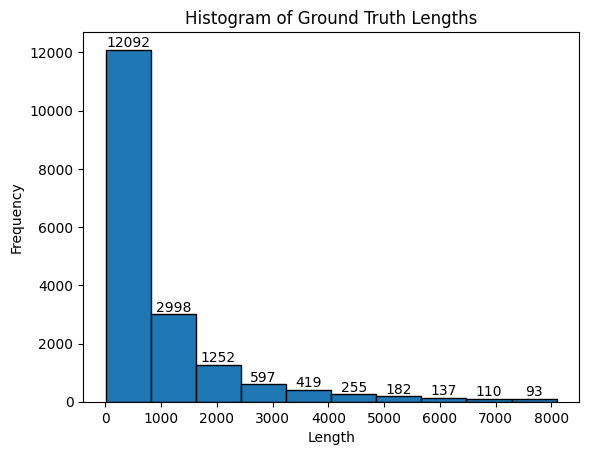

In [6]:
import matplotlib.pyplot as plt

lengths = [l for l in lengths if l <= 8096]

counts, bins, patches = plt.hist(lengths, bins=10, edgecolor='black')
plt.title('Histogram of Ground Truth Lengths')
plt.xlabel('Length')
plt.ylabel('Frequency')

# Mark the count number of each bin
for count, patch in zip(counts, patches):
    plt.text(patch.get_x() + patch.get_width() / 2, count, int(count), 
             ha='center', va='bottom')

plt.show()


In [7]:
idx_4096 = [idx for idx, length in enumerate(lengths) if length <= 4096]
filtered_data = data.select(idx_4096)

In [8]:
def make_map_fn(split, data_source):

    def process_fn(example, idx):
        messages = [dict(role="user", content=example["text"])]
        answer = example["patch"]

        data = {
            "data_source": data_source,
            "prompt": messages,
            "ability": "swe",
            "reward_model": {
                "style": "rule",
                "ground_truth": answer,
            },
            "extra_info": {"split": split, "index": idx},
        }
        return data

    return process_fn

train_data = filtered_data.map(make_map_fn("train", "swe-oracle-unidiff"), with_indices=True)
train_data.to_parquet("data/swe-oracle-train/swe-oracle-unidiff-train.parquet")

Creating parquet from Arrow format: 100%|██████████| 18/18 [00:21<00:00,  1.17s/ba]


4322433985

In [9]:
from datasets import load_dataset
data = load_dataset("data/princeton-nlp/SWE-bench_oracle", split="test")

lengths = []
for output in tqdm(data["patch"]):
    lengths.append(len(tokenizer.encode(output)))

idx_4096 = [idx for idx, length in enumerate(lengths) if length <= 4096]
filtered_data = data.select(idx_4096)

test_data = filtered_data.map(make_map_fn("test", "swe-oracle-unidiff"), with_indices=True)
test_data.to_parquet("data/swe-oracle-train/swe-oracle-unidiff-test.parquet")

  4%|▍         | 93/2294 [00:00<00:04, 442.42it/s]

Creating parquet from Arrow format: 100%|██████████| 3/3 [00:01<00:00,  1.57ba/s]


408384641

In [8]:
messages = [build_messages(text) for text in filtered_data["text"]]

In [9]:
lengths = []
for message in tqdm(messages):
    prompt = tokenizer.apply_chat_template(message, tokenize=False)
    lengths.append(len(tokenizer.encode(prompt)))

print(np.mean(lengths))
print(np.max(lengths))
print(np.min(lengths))


100%|██████████| 17373/17373 [25:35<00:00, 11.31it/s] 

36198.971737753986
526695
899


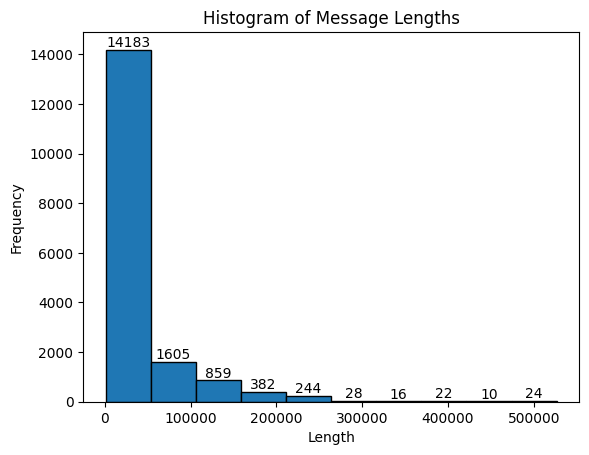

In [10]:
import matplotlib.pyplot as plt

counts, bins, patches = plt.hist(lengths, bins=10, edgecolor='black')
plt.title('Histogram of Message Lengths')
plt.xlabel('Length')
plt.ylabel('Frequency')

# Mark the count number of each bin
for count, patch in zip(counts, patches):
    plt.text(patch.get_x() + patch.get_width() / 2, count, int(count), 
             ha='center', va='bottom')

plt.show()


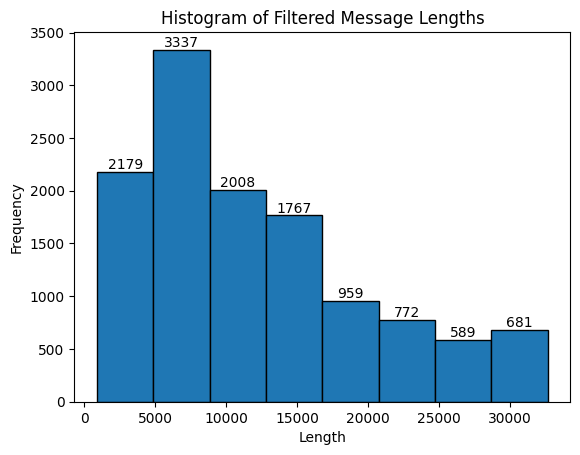

In [11]:
# Filter data with lengths > 32768
filtered_lengths = [length for length in lengths if length <= 32768]

# Redraw the histogram
counts, bins, patches = plt.hist(filtered_lengths, bins=8, edgecolor='black')
plt.title('Histogram of Filtered Message Lengths')
plt.xlabel('Length')
plt.ylabel('Frequency')

# Mark the count number of each bin
for count, patch in zip(counts, patches):
    plt.text(patch.get_x() + patch.get_width() / 2, count, int(count), 
             ha='center', va='bottom')

plt.show()


In [12]:
print(len([length for length in lengths if length <= 32768]) / len(data))
print(len([length for length in lengths if length <= 25600]) / len(data))


0.6532390923101451
0.5907955572089069


In [70]:
train_test = data.train_test_split(test_size=0.2)
train_data = train_test["train"]
test_data = train_test["test"]
print(len(train_data), len(test_data))

1835 459


In [74]:
def make_map_fn(split, data_source):

    def process_fn(example, idx):
        messages = [dict(role="user", content=example["text"])]
        answer = example["patch"]

        data = {
            "data_source": data_source,
            "prompt": messages,
            "ability": "swe",
            "reward_model": {
                "style": "rule",
                "ground_truth": answer,
            },
            "extra_info": {"split": split, "index": idx},
        }
        return data

    return process_fn

In [75]:
train_data = train_data.map(make_map_fn("train", "swe-oracle-unidiff"), with_indices=True)
test_data = test_data.map(make_map_fn("test", "swe-oracle-unidiff"), with_indices=True)

Map: 100%|██████████| 459/459 [00:00<00:00, 1157.48 examples/s]


In [76]:
train_data.to_parquet("data/swe-oracle-test/swe-oracle-unidiff-train.parquet")
test_data.to_parquet("data/swe-oracle-test/swe-oracle-unidiff-test.parquet")

Creating parquet from Arrow format:   0%|          | 0/2 [00:00<?, ?ba/s]

Creating parquet from Arrow format: 100%|██████████| 1/1 [00:00<00:00,  2.35ba/s]


87377075

In [68]:
print(data[0]["text"])

You will be provided with a partial code base and an issue statement explaining a problem to resolve.
<issue>
'WCS.all_world2pix' failed to converge when plotting WCS with non linear distortions
<!-- This comments are hidden when you submit the issue,
so you do not need to remove them! -->

<!-- Please be sure to check out our contributing guidelines,
https://github.com/astropy/astropy/blob/master/CONTRIBUTING.md .
Please be sure to check out our code of conduct,
https://github.com/astropy/astropy/blob/master/CODE_OF_CONDUCT.md . -->

<!-- Please have a search on our GitHub repository to see if a similar
issue has already been posted.
If a similar issue is closed, have a quick look to see if you are satisfied
by the resolution.
If not please go ahead and open an issue! -->

<!-- Please check that the development version still produces the same bug.
You can install development version with
pip install git+https://github.com/astropy/astropy
command. -->

### Description
When trying to pl